<a href="https://colab.research.google.com/github/gazalssr/HerdNet/blob/main/Model3_TL_finetuning_Final_saved_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO - Training and testing HerdNet on nadir aerial images

## Installations

In [1]:
# Check GPU
!nvidia-smi

Wed Nov 15 13:41:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install the dependencies
!pip install albumentations>=1.0.3
!pip install fiftyone>=0.14.3
!pip install hydra-core>=1.1.0
!pip install opencv-python>=4.5.1.48
!pip install pandas>=1.2.3
!pip install pillow>=8.2.0
!pip install scikit-image>=0.18.1
!pip install scikit-learn>=1.0.2
!pip install scipy>=1.6.2
!pip install wandb>=0.10.33
!pip install numpy>=1.20.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and install the code
import sys

!git clone https://github.com/gazalssr/HerdNet.git
#!cd '/content/HerdNet' && python setup.py install
!pip install -e /content/HerdNet
sys.path.append('/content/HerdNet')

Cloning into 'HerdNet'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 394 (delta 20), reused 23 (delta 14), pack-reused 339
Receiving objects: 100% (394/394), 1.83 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (231/231), done.
Obtaining file:///content/HerdNet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for animaloc


In [ ]:
!wandb login
import wandb

/bin/bash: line 1: wandb: command not found


ModuleNotFoundError: ignored

## Create datasets

In [ ]:
# Set the seed
from animaloc.utils.seed import set_seed

set_seed(9292)

Number of patches: 48


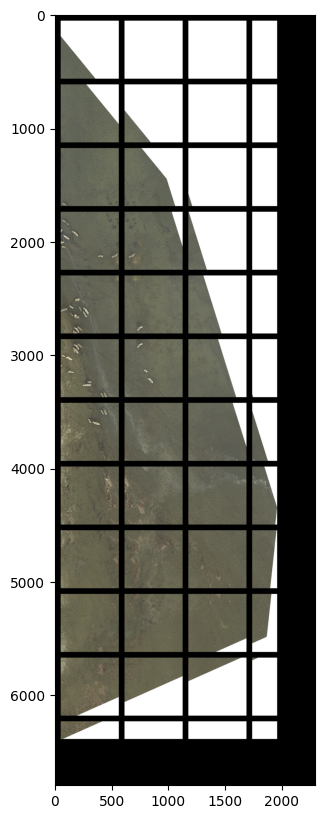

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

from animaloc.data.patches import ImageToPatches, AnnotatedImageToPatches

img_path = '//content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/CAH_7_90_2017_BR.jpg'

sample_img = Image.open(img_path)

patcher = ImageToPatches(sample_img, (512,512), overlap = 100)
patches = patcher.make_patches()

print(f'Number of patches: {len(patches)}')

plt.figure(figsize=(15,10))
_ = patcher.show()

In [ ]:
# Create training  patches using the patcher tool
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
from PIL import Image
# df = pd.read_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv')
# df = df.to_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv', index=False)
# mkdir('/content/drive/MyDrive/Train_patches')
mkdir('/content/Train_patches')
#!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/ 512 512 256 /content/drive/MyDrive/Train_patches -csv /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv -min 0.0 -all False
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/ 512 512 256 /content/Train_patches -csv /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv -min 0.0 -all False

Creating the buffer: 100% 4/4 [00:21<00:00,  5.39s/it]
Exporting patches: 100% 5/5 [00:30<00:00,  6.16s/it]


In [ ]:
# Create validation patches
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
# mkdir('/content/drive/MyDrive/val_patches')
mkdir('/content/val_patches')
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_training_session_1/ValCAH 512 512 256 /content/drive/MyDrive/val_patches -csv /content/drive/MyDrive/CAH_training_session_1/ValCAH/ValCAH_2017_1.csv -min 0.0 -all True
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Val_CAH_Sample/ 512 512 256 /content/val_patches -csv /content/drive/MyDrive/CAH_small_samples/Val_CAH_Sample/VAL_CAH_Sample.csv -min 0.0 -all False

Creating the buffer: 100% 2/2 [00:14<00:00,  7.16s/it]
Exporting patches: 100% 2/2 [00:20<00:00, 10.36s/it]


In [ ]:
%pdb

Automatic pdb calling has been turned OFF


In [ ]:
# Create test patches
from animaloc.utils.useful_funcs import mkdir
import pandas as pd

# mkdir('/content/drive/MyDrive/test_patches')
mkdir('/content/test_patches')
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_training_session_1/TestCAH 512 512 256 /content/drive/MyDrive/test_patches -csv /content/drive/MyDrive/CAH_training_session_1/TestCAH/TestCAH_2017_1.csv -min 0.0 -all False
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Test_CAH_Sample/ 512 512 256 /content/test_patches -csv /content/drive/MyDrive/CAH_small_samples/Test_CAH_Sample/Test_CAH_Sample.csv -min 0.0 -all False

Creating the buffer: 100% 1/1 [00:04<00:00,  4.24s/it]
Exporting patches: 100% 1/1 [00:12<00:00, 12.17s/it]


In [ ]:
#make a zip file from the patch folders  (Only run this when ypou add a new dataset)
#Zip file path (destination)       source file path
# import shutil
# shutil.make_archive('/content/drive/MyDrive/Train_patches_S', 'zip', '/content/Train_patches')
# shutil.make_archive('/content/drive/MyDrive/val_patches_S', 'zip', '/content/drive/MyDrive/val_patches')
# shutil.make_archive('/content/drive/MyDrive/test_patches_S', 'zip', '/content/drive/MyDrive/test_patches')
!zip -r '/content/drive/MyDrive/Train_patches_S.zip' '/content/Train_patches'
!zip -r '/content/drive/MyDrive/val_patches_S.zip' '/content/val_patches'
!zip -r '/content/drive/MyDrive/test_patches_S.zip' '/content/test_patches'

Streaming output truncated to the last 5000 lines.
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_MT2_589.jpg (deflated 0%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_TL_17.jpg (deflated 90%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_BL_5.jpg (deflated 90%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_MB1_536.jpg (deflated 0%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_MB2_26.jpg (deflated 0%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_MT2_532.jpg (deflated 0%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_TL_299.jpg (deflated 90%)
  adding: content/test_patches/content/test_patches/content/test_patches/FCH_7_00_50_MB2_761.jpg (deflated 0%)
  adding: content/test_patches/content/test_patches/content/test_

In [ ]:
shutil.make_archive('/content/drive/MyDrive/val_patches_S', 'zip', '/content/drive/MyDrive/val_patches')

'/content/drive/MyDrive/val_patches_S.zip'

In [ ]:
shutil.make_archive('/content/drive/MyDrive/test_patches_S', 'zip', '/content/drive/MyDrive/test_patches')

'/content/drive/MyDrive/test_patches_S.zip'

## Caribou dataset donwload

In [ ]:
#### Downloading and unziping the files
#zip file download (destination link)                  Zip file saving location (same as the link)
!gdown https://drive.google.com/uc?id=12VEutzFD-9hM7k5ldfU5G4WCt24MBiMj -O /content/Train_patches_S.zip
# #Zip file location           uzipped file saving location
!unzip -oq /content/Train_patches_S.zip -d /content/Train_patches

!gdown https://drive.google.com/uc?id=1-AMhyt7YM41spI--Y29OP90AZ9s36Qsc -O /content/Val_patches_S.zip
!unzip -oq /content/Val_patches_S.zip -d /content/val_patches

!gdown https://drive.google.com/uc?id=1-FTI14LsL4zplEMVgD1ozimDkZISCo8T -O /content/test_patches_S.zip
!unzip -oq /content/test_patches_S.zip -d /content/test_patches


Downloading...
From: https://drive.google.com/uc?id=12VEutzFD-9hM7k5ldfU5G4WCt24MBiMj
To: /content/Train_patches_S.zip
100% 311M/311M [00:01<00:00, 255MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-AMhyt7YM41spI--Y29OP90AZ9s36Qsc
To: /content/Val_patches_S.zip
100% 1.28G/1.28G [00:06<00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-FTI14LsL4zplEMVgD1ozimDkZISCo8T
To: /content/test_patches_S.zip
100% 1.25G/1.25G [00:04<00:00, 255MB/s]


In [ ]:
import pandas as pd

!ls /content//Train_patches/*.jpg
# csv_data= pd.read_csv('/content/Train_patches/gt.csv')
# print(csv_data)

/content//Train_patches/CAH_1_90_2017_0.jpg
/content//Train_patches/CAH_1_90_2017_100.jpg
/content//Train_patches/CAH_1_90_2017_101.jpg
/content//Train_patches/CAH_1_90_2017_102.jpg
/content//Train_patches/CAH_1_90_2017_103.jpg
/content//Train_patches/CAH_1_90_2017_104.jpg
/content//Train_patches/CAH_1_90_2017_105.jpg
/content//Train_patches/CAH_1_90_2017_106.jpg
/content//Train_patches/CAH_1_90_2017_107.jpg
/content//Train_patches/CAH_1_90_2017_108.jpg
/content//Train_patches/CAH_1_90_2017_109.jpg
/content//Train_patches/CAH_1_90_2017_10.jpg
/content//Train_patches/CAH_1_90_2017_110.jpg
/content//Train_patches/CAH_1_90_2017_111.jpg
/content//Train_patches/CAH_1_90_2017_112.jpg
/content//Train_patches/CAH_1_90_2017_113.jpg
/content//Train_patches/CAH_1_90_2017_114.jpg
/content//Train_patches/CAH_1_90_2017_115.jpg
/content//Train_patches/CAH_1_90_2017_116.jpg
/content//Train_patches/CAH_1_90_2017_117.jpg
/content//Train_patches/CAH_1_90_2017_118.jpg
/content//Train_patches/CAH_1_90_2017

5
9
31
4
7
35
82
82


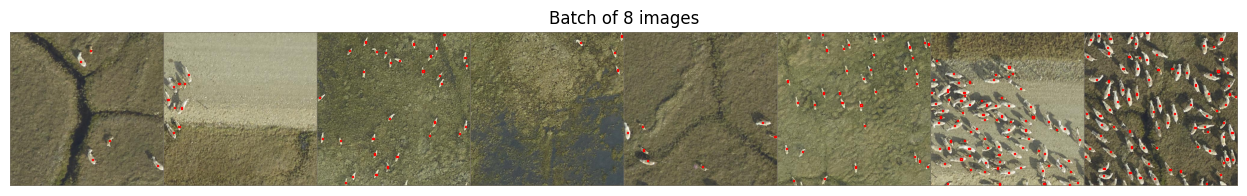

In [ ]:
%matplotlib inline
# Showing some samples of patches and the annotations
import matplotlib.pyplot as plt
from animaloc.datasets import CSVDataset
from animaloc.data.batch_utils import show_batch, collate_fn
from torch.utils.data import DataLoader
import torch
import albumentations as A
batch_size = 8
csv_path = '/content/drive/MyDrive/Train_patches/gt.csv'
image_path = '/content/drive/MyDrive/Train_patches'
dataset = CSVDataset(csv_path, image_path, [A.Normalize()])
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

sample_batch = next(iter(dataloader))
for i in range(len(sample_batch[1])):
  points = sample_batch[1][i]['points'].numpy()
  bbox= []
  for pt in points:
      bbox.append([pt[0]-2,pt[1]-2,pt[0]+2,pt[1]+2])
  print(len(sample_batch[1][i]['labels']))
  sample_batch[1][i]['annotations']=torch.tensor(bbox)
plt.figure(figsize=(16,2))
show_batch(sample_batch)

In [ ]:
# Training, validation and test datasets
import albumentations as A

from animaloc.datasets import FolderDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT

patch_size = 512
num_classes = 2
down_ratio: int = 2

train_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/Train_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/Train_patches',
    csv_file = '/content/Train_patches/gt.csv',
    root_dir = '/content/Train_patches',
    # Data Augmentation
    albu_transforms = [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(p=1.0),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
        # A.Blur(blur_limit=15, p=0.2),
        ],
    end_transforms = [MultiTransformsWrapper([
        FIDT(num_classes=num_classes, down_ratio=down_ratio),
        PointsToMask(radius=2, num_classes=num_classes, squeeze=True, down_ratio=int(patch_size//16))
        ])]
    )

val_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/val_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/val_patches',
    csv_file = '/content/val_patches/gt.csv',
    root_dir = '/content/val_patches',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

test_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/test_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/test_patches',
    csv_file = '/content/test_patches/gt.csv',
    root_dir = '/content/test_patches',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

In [ ]:
# Dataloaders
from torch.utils.data import DataLoader
# from animaloc.data.batch_utils import cat_list, collate_fn
# train_dataloader = DataLoader(dataset = train_dataset, collate_fn=collate_fn, batch_size = 2, shuffle = True)
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)
# val_dataloader = DataLoader(dataset = val_dataset, collate_fn=collate_fn, batch_size = 2, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = 1, shuffle = False)
# test_dataloader = DataLoader(dataset = test_dataset, collate_fn=collate_fn, batch_size = 2, shuffle = False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

## Define HerdNet for training

In [ ]:
# Path to your .pth file
import gdown
import torch
####################### Transfered weights ###########################
pth_path = '/content/drive/MyDrive/output/Binary.pth'
pretrained_dict = torch.load(pth_path)
# herdnet.load_state_dict(pretrained_dict, strict=False) # initialisation from a pre-task
# herdnet.load_state_dict(pretrained_dict['model_state_dict'])

In [ ]:
from animaloc.models import HerdNet
from torch import Tensor
from animaloc.models import LossWrapper
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss

herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio).cuda()

losses = [
    {'loss': FocalLoss(reduction='mean'), 'idx': 0, 'idy': 0, 'lambda': 1.0, 'name': 'focal_loss'},
    {'loss': CrossEntropyLoss(reduction='mean'), 'idx': 1, 'idy': 1, 'lambda': 1.0, 'name': 'ce_loss'}
    ]

herdnet = LossWrapper(herdnet, losses=losses)
herdnet.load_state_dict(pretrained_dict, strict=False) # /initialisation from a pre-task
# herdnet.load_state_dict(pretrained_dict['model_state_dict'])

_IncompatibleKeys(missing_keys=['model.base_0.base_layer.0.weight', 'model.base_0.base_layer.1.weight', 'model.base_0.base_layer.1.bias', 'model.base_0.base_layer.1.running_mean', 'model.base_0.base_layer.1.running_var', 'model.base_0.level0.0.weight', 'model.base_0.level0.1.weight', 'model.base_0.level0.1.bias', 'model.base_0.level0.1.running_mean', 'model.base_0.level0.1.running_var', 'model.base_0.level1.0.weight', 'model.base_0.level1.1.weight', 'model.base_0.level1.1.bias', 'model.base_0.level1.1.running_mean', 'model.base_0.level1.1.running_var', 'model.base_0.level2.tree1.conv1.weight', 'model.base_0.level2.tree1.bn1.weight', 'model.base_0.level2.tree1.bn1.bias', 'model.base_0.level2.tree1.bn1.running_mean', 'model.base_0.level2.tree1.bn1.running_var', 'model.base_0.level2.tree1.conv2.weight', 'model.base_0.level2.tree1.bn2.weight', 'model.base_0.level2.tree1.bn2.bias', 'model.base_0.level2.tree1.bn2.running_mean', 'model.base_0.level2.tree1.bn2.running_var', 'model.base_0.level

## Create the Trainer

In [ ]:
#############Get model layers ###########################
def get_parameter_names(model): # getting the model layers
  param_dict= dict()
  for l, (name,param) in enumerate(model.named_parameters()):
    #print(l,":\t",name,type(param),param.requires_grad)
    param_dict[name]= l
  return param_dict
result = get_parameter_names(herdnet)
print(result)

{'model.base_0.base_layer.0.weight': 0, 'model.base_0.base_layer.1.weight': 1, 'model.base_0.base_layer.1.bias': 2, 'model.base_0.level0.0.weight': 3, 'model.base_0.level0.1.weight': 4, 'model.base_0.level0.1.bias': 5, 'model.base_0.level1.0.weight': 6, 'model.base_0.level1.1.weight': 7, 'model.base_0.level1.1.bias': 8, 'model.base_0.level2.tree1.conv1.weight': 9, 'model.base_0.level2.tree1.bn1.weight': 10, 'model.base_0.level2.tree1.bn1.bias': 11, 'model.base_0.level2.tree1.conv2.weight': 12, 'model.base_0.level2.tree1.bn2.weight': 13, 'model.base_0.level2.tree1.bn2.bias': 14, 'model.base_0.level2.tree2.conv1.weight': 15, 'model.base_0.level2.tree2.bn1.weight': 16, 'model.base_0.level2.tree2.bn1.bias': 17, 'model.base_0.level2.tree2.conv2.weight': 18, 'model.base_0.level2.tree2.bn2.weight': 19, 'model.base_0.level2.tree2.bn2.bias': 20, 'model.base_0.level2.root.conv.weight': 21, 'model.base_0.level2.root.bn.weight': 22, 'model.base_0.level2.root.bn.bias': 23, 'model.base_0.level2.proj

In [ ]:
#Freeze the layers
def freeze_parts(model, get_parameter_names, layers_to_freeze, lr, unfreeze=False):
    params_to_update = []

    for l, (name, param) in enumerate(model.named_parameters()):
        res = any(ele in name for ele in layers_to_freeze)
        param.requires_grad = unfreeze if res else not unfreeze

        if param.requires_grad == True:
            params_to_update.append({
                "params": param,
                "lr": lr,
            })

        # Print parameters to update
        if param.requires_grad:
            print(f"Trainable parameter: {name}")
        else:
            print(f"Frozen parameter: {name}")

    return params_to_update


In [ ]:
lr = 1e-3 # learning rate
# layers_to_freeze= [] # nothing frozen
# layers_to_freeze= ['base_layer','level0','level1','level2','level3','level4','level5'] # we are feezing all the levels below level5
layers_to_freeze= ['fc','bottleneck_conv'] # we are feezing everything except cls_head

params_to_update= freeze_parts(herdnet.model,get_parameter_names,layers_to_freeze,lr,unfreeze=False)
# optimizer = Adam(params=params_to_update, lr=lr, weight_decay=weight_decay)


Frozen parameter: base_0.base_layer.0.weight
Frozen parameter: base_0.base_layer.1.weight
Frozen parameter: base_0.base_layer.1.bias
Frozen parameter: base_0.level0.0.weight
Frozen parameter: base_0.level0.1.weight
Frozen parameter: base_0.level0.1.bias
Frozen parameter: base_0.level1.0.weight
Frozen parameter: base_0.level1.1.weight
Frozen parameter: base_0.level1.1.bias
Frozen parameter: base_0.level2.tree1.conv1.weight
Frozen parameter: base_0.level2.tree1.bn1.weight
Frozen parameter: base_0.level2.tree1.bn1.bias
Frozen parameter: base_0.level2.tree1.conv2.weight
Frozen parameter: base_0.level2.tree1.bn2.weight
Frozen parameter: base_0.level2.tree1.bn2.bias
Frozen parameter: base_0.level2.tree2.conv1.weight
Frozen parameter: base_0.level2.tree2.bn1.weight
Frozen parameter: base_0.level2.tree2.bn1.bias
Frozen parameter: base_0.level2.tree2.conv2.weight
Frozen parameter: base_0.level2.tree2.bn2.weight
Frozen parameter: base_0.level2.tree2.bn2.bias
Frozen parameter: base_0.level2.root.

# Create the Trainer

In [ ]:
from torch.optim import Adam
from animaloc.train import Trainer
from torch.optim.lr_scheduler import StepLR
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

work_dir = '/content/drive/MyDrive/output'
mkdir(work_dir)

lr = 1e-4
weight_decay = 1e-3
epochs = 70
parameters= herdnet.parameters()
parameters=params_to_update
optimizer = Adam(params=parameters, lr=lr, weight_decay=weight_decay)
# optimizer = Adam(params=herdnet.params_to_update, lr=lr, weight_decay=weight_decay)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler.step()
metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=0,
    down_ratio=down_ratio,
    reduction='mean'
    )

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=None,
    work_dir=work_dir,
    header='validation'
    )

trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=evaluator,             # metric evaluation
    # val_dataloader= val_dataloader, # loss evaluation
    work_dir=work_dir
    )

## Initial training

In [ ]:
import wandb
if wandb.run is not None:
  wandb.finish()
wandb.init(project="herdnet-finetuning")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1162, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 306, in setup
    wandb_login._login(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 298, in _login
    wlogin.prompt_api_key()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 221, in prompt_api_key
    key, status = self._prompt_api_key()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_login.py", line 201, in _prompt_api_key
    key = apikey.prompt_api_key(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/

Error: ignored

In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='f1_score', wandb_flag =False)
# validate_on='f1_score'

INFO:20231114_training:[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:02 lr: 0.000020 loss: 44.8806 (44.8806) focal_loss: 44.4859 (44.4859) ce_loss: 0.3946 (0.3946) time: 0.3431 data: 0.1129 max mem: 1493


[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:02 lr: 0.000020 loss: 44.8806 (44.8806) focal_loss: 44.4859 (44.4859) ce_loss: 0.3946 (0.3946) time: 0.3431 data: 0.1129 max mem: 1493


INFO:20231114_training:[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:30 lr: 0.000515 loss: 28.0650 (34.2826) focal_loss: 27.7240 (33.9288) ce_loss: 0.3246 (0.3538) time: 0.2191 data: 0.0745 max mem: 1493


[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:30 lr: 0.000515 loss: 28.0650 (34.2826) focal_loss: 27.7240 (33.9288) ce_loss: 0.3246 (0.3538) time: 0.2191 data: 0.0745 max mem: 1493


INFO:20231114_training:[TRAINING] - Epoch: [1] [101/183] eta: 0:00:18 lr: 0.001000 loss: 34.1480 (32.8096) focal_loss: 33.7669 (32.4062) ce_loss: 0.3630 (0.4034) time: 0.2302 data: 0.0843 max mem: 1493


[TRAINING] - Epoch: [1] [101/183] eta: 0:00:18 lr: 0.001000 loss: 34.1480 (32.8096) focal_loss: 33.7669 (32.4062) ce_loss: 0.3630 (0.4034) time: 0.2302 data: 0.0843 max mem: 1493


INFO:20231114_training:[TRAINING] - Epoch: [1] [151/183] eta: 0:00:07 lr: 0.001000 loss: 19.5248 (31.8139) focal_loss: 19.1670 (31.4068) ce_loss: 0.3646 (0.4071) time: 0.2172 data: 0.0700 max mem: 1493


[TRAINING] - Epoch: [1] [151/183] eta: 0:00:07 lr: 0.001000 loss: 19.5248 (31.8139) focal_loss: 19.1670 (31.4068) ce_loss: 0.3646 (0.4071) time: 0.2172 data: 0.0700 max mem: 1493


INFO:20231114_training:[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.001000 loss: 36.4980 (31.9848) focal_loss: 36.2293 (31.5720) ce_loss: 0.3760 (0.4128) time: 0.2352 data: 0.0875 max mem: 1493
INFO:20231114_training:[TRAINING] - Epoch: [1] Total time: 0:00:41 (0.2263 s / it)
INFO:20231114_validation:[VALIDATION] - Epoch: [1] [  1/379] eta: 0:00:11 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0075 max mem: 1493


[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.001000 loss: 36.4980 (31.9848) focal_loss: 36.2293 (31.5720) ce_loss: 0.3760 (0.4128) time: 0.2352 data: 0.0875 max mem: 1493
[TRAINING] - Epoch: [1] Total time: 0:00:41 (0.2263 s / it)
[TRAINING] - Epoch: [1] mean loss: 31.9848
[VALIDATION] - Epoch: [1] [  1/379] eta: 0:00:11 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 11/379] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0282 data: 0.0066 max mem: 1493


[VALIDATION] - Epoch: [1] [ 11/379] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0282 data: 0.0066 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 21/379] eta: 0:00:10 n: 7 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0281 data: 0.0065 max mem: 1493


[VALIDATION] - Epoch: [1] [ 21/379] eta: 0:00:10 n: 7 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0281 data: 0.0065 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 31/379] eta: 0:00:09 n: 7 recall: 0.86 precision: 0.26 f1-score: 0.4 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0285 data: 0.0067 max mem: 1493


[VALIDATION] - Epoch: [1] [ 31/379] eta: 0:00:09 n: 7 recall: 0.86 precision: 0.26 f1-score: 0.4 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0285 data: 0.0067 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 41/379] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0291 data: 0.0070 max mem: 1493


[VALIDATION] - Epoch: [1] [ 41/379] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0291 data: 0.0070 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 51/379] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0291 data: 0.0069 max mem: 1493


[VALIDATION] - Epoch: [1] [ 51/379] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0291 data: 0.0069 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 61/379] eta: 0:00:09 n: 33 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0295 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [ 61/379] eta: 0:00:09 n: 33 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0295 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 71/379] eta: 0:00:08 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0295 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [ 71/379] eta: 0:00:08 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0295 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 81/379] eta: 0:00:08 n: 22 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0069 max mem: 1493


[VALIDATION] - Epoch: [1] [ 81/379] eta: 0:00:08 n: 22 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0069 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [ 91/379] eta: 0:00:08 n: 28 recall: 0.96 precision: 0.42 f1-score: 0.59 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0292 data: 0.0069 max mem: 1493


[VALIDATION] - Epoch: [1] [ 91/379] eta: 0:00:08 n: 28 recall: 0.96 precision: 0.42 f1-score: 0.59 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0292 data: 0.0069 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [101/379] eta: 0:00:08 n: 24 recall: 0.92 precision: 0.37 f1-score: 0.53 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0292 data: 0.0070 max mem: 1493


[VALIDATION] - Epoch: [1] [101/379] eta: 0:00:08 n: 24 recall: 0.92 precision: 0.37 f1-score: 0.53 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0292 data: 0.0070 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [111/379] eta: 0:00:07 n: 33 recall: 0.91 precision: 0.4 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0291 data: 0.0069 max mem: 1493


[VALIDATION] - Epoch: [1] [111/379] eta: 0:00:07 n: 33 recall: 0.91 precision: 0.4 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0291 data: 0.0069 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [121/379] eta: 0:00:07 n: 59 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0297 data: 0.0069 max mem: 1493


[VALIDATION] - Epoch: [1] [121/379] eta: 0:00:07 n: 59 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0297 data: 0.0069 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [131/379] eta: 0:00:07 n: 59 recall: 0.98 precision: 0.37 f1-score: 0.54 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0304 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [131/379] eta: 0:00:07 n: 59 recall: 0.98 precision: 0.37 f1-score: 0.54 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0304 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [141/379] eta: 0:00:07 n: 60 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0419 data: 0.0073 max mem: 1493


[VALIDATION] - Epoch: [1] [141/379] eta: 0:00:07 n: 60 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0419 data: 0.0073 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [151/379] eta: 0:00:07 n: 77 recall: 0.94 precision: 0.5 f1-score: 0.65 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0419 data: 0.0073 max mem: 1493


[VALIDATION] - Epoch: [1] [151/379] eta: 0:00:07 n: 77 recall: 0.94 precision: 0.5 f1-score: 0.65 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0419 data: 0.0073 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [161/379] eta: 0:00:06 n: 49 recall: 0.92 precision: 0.43 f1-score: 0.58 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0303 data: 0.0072 max mem: 1493


[VALIDATION] - Epoch: [1] [161/379] eta: 0:00:06 n: 49 recall: 0.92 precision: 0.43 f1-score: 0.58 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0303 data: 0.0072 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [171/379] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.44 f1-score: 0.61 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0302 data: 0.0072 max mem: 1493


[VALIDATION] - Epoch: [1] [171/379] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.44 f1-score: 0.61 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0302 data: 0.0072 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [181/379] eta: 0:00:06 n: 46 recall: 0.93 precision: 0.57 f1-score: 0.7 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0301 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [181/379] eta: 0:00:06 n: 46 recall: 0.93 precision: 0.57 f1-score: 0.7 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0301 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [191/379] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [191/379] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [201/379] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0070 max mem: 1493


[VALIDATION] - Epoch: [1] [201/379] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0070 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [211/379] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0070 max mem: 1493


[VALIDATION] - Epoch: [1] [211/379] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0070 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [221/379] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0071 max mem: 1493


[VALIDATION] - Epoch: [1] [221/379] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0071 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [231/379] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.49 f1-score: 0.66 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0300 data: 0.0075 max mem: 1493


[VALIDATION] - Epoch: [1] [231/379] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.49 f1-score: 0.66 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0300 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [241/379] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0077 max mem: 1493


[VALIDATION] - Epoch: [1] [241/379] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0077 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [251/379] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0075 max mem: 1493


[VALIDATION] - Epoch: [1] [251/379] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [261/379] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.62 f1-score: 0.76 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0074 max mem: 1493


[VALIDATION] - Epoch: [1] [261/379] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.62 f1-score: 0.76 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0074 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [271/379] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0077 max mem: 1493


[VALIDATION] - Epoch: [1] [271/379] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0077 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [281/379] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0076 max mem: 1493


[VALIDATION] - Epoch: [1] [281/379] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0076 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [291/379] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0074 max mem: 1493


[VALIDATION] - Epoch: [1] [291/379] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0074 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [301/379] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.56 f1-score: 0.72 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0074 max mem: 1493


[VALIDATION] - Epoch: [1] [301/379] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.56 f1-score: 0.72 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0074 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [311/379] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.53 f1-score: 0.68 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0304 data: 0.0075 max mem: 1493


[VALIDATION] - Epoch: [1] [311/379] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.53 f1-score: 0.68 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0304 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [321/379] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.47 f1-score: 0.63 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0075 max mem: 1493


[VALIDATION] - Epoch: [1] [321/379] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.47 f1-score: 0.63 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [331/379] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.55 f1-score: 0.71 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0074 max mem: 1493


[VALIDATION] - Epoch: [1] [331/379] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.55 f1-score: 0.71 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0074 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [341/379] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.59 f1-score: 0.73 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0075 max mem: 1493


[VALIDATION] - Epoch: [1] [341/379] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.59 f1-score: 0.73 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0075 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [351/379] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.51 f1-score: 0.67 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0078 max mem: 1493


[VALIDATION] - Epoch: [1] [351/379] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.51 f1-score: 0.67 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0078 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [361/379] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0076 max mem: 1493


[VALIDATION] - Epoch: [1] [361/379] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0076 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [371/379] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.55 f1-score: 0.7 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0073 max mem: 1493


[VALIDATION] - Epoch: [1] [371/379] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.55 f1-score: 0.7 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0073 max mem: 1493


INFO:20231114_validation:[VALIDATION] - Epoch: [1] [379/379] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0074 max mem: 1493
INFO:20231114_validation:[VALIDATION] - Epoch: [1] Total time: 0:00:11 (0.0307 s / it)


[VALIDATION] - Epoch: [1] [379/379] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0074 max mem: 1493
[VALIDATION] - Epoch: [1] Total time: 0:00:11 (0.0307 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.5719
Best model saved - Epoch 1 - Validation value: 0.571923


INFO:20231114_training:[TRAINING] - Epoch: [2] [  1/183] eta: 0:00:39 lr: 0.001000 loss: 36.4980 (31.8740) focal_loss: 36.2293 (31.4609) ce_loss: 0.3827 (0.4131) time: 0.2178 data: 0.0673 max mem: 1493


[TRAINING] - Epoch: [2] [  1/183] eta: 0:00:39 lr: 0.001000 loss: 36.4980 (31.8740) focal_loss: 36.2293 (31.4609) ce_loss: 0.3827 (0.4131) time: 0.2178 data: 0.0673 max mem: 1493


KeyboardInterrupt: ignored

In [ ]:
##Unfreeze the layers
layers_to_unfreeze = ['base_layer','level0','level1','level2','level3','level4','level5','fc','bottleneck_conv']
params_to_update_UF = freeze_parts(herdnet.model, get_parameter_names, layers_to_unfreeze, lr=1e-3, unfreeze=True)

Trainable parameter: base_0.base_layer.0.weight
Trainable parameter: base_0.base_layer.1.weight
Trainable parameter: base_0.base_layer.1.bias
Trainable parameter: base_0.level0.0.weight
Trainable parameter: base_0.level0.1.weight
Trainable parameter: base_0.level0.1.bias
Trainable parameter: base_0.level1.0.weight
Trainable parameter: base_0.level1.1.weight
Trainable parameter: base_0.level1.1.bias
Trainable parameter: base_0.level2.tree1.conv1.weight
Trainable parameter: base_0.level2.tree1.bn1.weight
Trainable parameter: base_0.level2.tree1.bn1.bias
Trainable parameter: base_0.level2.tree1.conv2.weight
Trainable parameter: base_0.level2.tree1.bn2.weight
Trainable parameter: base_0.level2.tree1.bn2.bias
Trainable parameter: base_0.level2.tree2.conv1.weight
Trainable parameter: base_0.level2.tree2.bn1.weight
Trainable parameter: base_0.level2.tree2.bn1.bias
Trainable parameter: base_0.level2.tree2.conv2.weight
Trainable parameter: base_0.level2.tree2.bn2.weight
Trainable parameter: bas

In [ ]:
work_dir = '/content/drive/MyDrive/output'
mkdir(work_dir)

lr = 1e-2
weight_decay = 1e-3
epochs = 70
parameters=params_to_update_UF
# optimizer = Adam(params=params_to_update_UF, lr=lr, weight_decay=)
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)


metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=0,
    down_ratio=down_ratio,
    reduction='mean'
    )

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=None,
    work_dir=work_dir,
    header='validation'
    )

trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=evaluator,
    work_dir=work_dir
    )


## continue traing with unfreezing the freezed layers



In [ ]:
import wandb
# if wandb.run is not None:
#   wandb.finish()
wandb.init(project="herdnet-finetuning")

In [ ]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='accuracy', validate_on='f1_score', wandb_flag =True)


INFO:20231109_training:[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:06 lr: 0.000199 loss: 1.4951 (1.4951) focal_loss: 1.2053 (1.2053) ce_loss: 0.2898 (0.2898) time: 0.3654 data: 0.0637 max mem: 2222


[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:06 lr: 0.000199 loss: 1.4951 (1.4951) focal_loss: 1.2053 (1.2053) ce_loss: 0.2898 (0.2898) time: 0.3654 data: 0.0637 max mem: 2222


INFO:20231109_training:[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:41 lr: 0.005149 loss: 39.8023 (35.7234) focal_loss: 39.2084 (35.1907) ce_loss: 0.5939 (0.5327) time: 0.3101 data: 0.0785 max mem: 2344


[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:41 lr: 0.005149 loss: 39.8023 (35.7234) focal_loss: 39.2084 (35.1907) ce_loss: 0.5939 (0.5327) time: 0.3101 data: 0.0785 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [1] [101/183] eta: 0:00:25 lr: 0.010000 loss: 34.8575 (38.4557) focal_loss: 34.1027 (37.8587) ce_loss: 0.6597 (0.5970) time: 0.3095 data: 0.0742 max mem: 2344


[TRAINING] - Epoch: [1] [101/183] eta: 0:00:25 lr: 0.010000 loss: 34.8575 (38.4557) focal_loss: 34.1027 (37.8587) ce_loss: 0.6597 (0.5970) time: 0.3095 data: 0.0742 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [1] [151/183] eta: 0:00:10 lr: 0.010000 loss: 37.2556 (38.5781) focal_loss: 36.4495 (37.9489) ce_loss: 0.7126 (0.6291) time: 0.3166 data: 0.0821 max mem: 2344


[TRAINING] - Epoch: [1] [151/183] eta: 0:00:10 lr: 0.010000 loss: 37.2556 (38.5781) focal_loss: 36.4495 (37.9489) ce_loss: 0.7126 (0.6291) time: 0.3166 data: 0.0821 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.3340 (38.3561) focal_loss: 29.6536 (37.7139) ce_loss: 0.6900 (0.6422) time: 0.3136 data: 0.0827 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [1] Total time: 0:00:57 (0.3132 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:23 n: 2 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0076 max mem: 2344


[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.3340 (38.3561) focal_loss: 29.6536 (37.7139) ce_loss: 0.6900 (0.6422) time: 0.3136 data: 0.0827 max mem: 2344
[TRAINING] - Epoch: [1] Total time: 0:00:57 (0.3132 s / it)
[TRAINING] - Epoch: [1] mean loss: 38.3561
[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:23 n: 2 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:23 n: 12 recall: 0.58 precision: 0.88 f1-score: 0.7 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:23 n: 12 recall: 0.58 precision: 0.88 f1-score: 0.7 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.48 f1-score: 0.62 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.48 f1-score: 0.62 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:23 n: 10 recall: 0.7 precision: 0.7 f1-score: 0.7 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:23 n: 10 recall: 0.7 precision: 0.7 f1-score: 0.7 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:23 n: 15 recall: 0.8 precision: 0.41 f1-score: 0.55 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:23 n: 15 recall: 0.8 precision: 0.41 f1-score: 0.55 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:22 n: 23 recall: 0.87 precision: 0.59 f1-score: 0.7 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:22 n: 23 recall: 0.87 precision: 0.59 f1-score: 0.7 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.5 f1-score: 0.65 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.5 f1-score: 0.65 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:22 n: 26 recall: 0.88 precision: 0.66 f1-score: 0.75 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:22 n: 26 recall: 0.88 precision: 0.66 f1-score: 0.75 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:21 n: 13 recall: 0.92 precision: 0.8 f1-score: 0.86 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:21 n: 13 recall: 0.92 precision: 0.8 f1-score: 0.86 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:21 n: 27 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:21 n: 27 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:21 n: 8 recall: 0.75 precision: 0.38 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:21 n: 8 recall: 0.75 precision: 0.38 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:20 n: 8 recall: 0.88 precision: 0.41 f1-score: 0.56 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:20 n: 8 recall: 0.88 precision: 0.41 f1-score: 0.56 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:20 n: 6 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:20 n: 6 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:19 n: 26 recall: 0.85 precision: 0.59 f1-score: 0.7 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0289 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:19 n: 26 recall: 0.85 precision: 0.59 f1-score: 0.7 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0289 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:19 n: 43 recall: 0.91 precision: 0.49 f1-score: 0.63 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:19 n: 43 recall: 0.91 precision: 0.49 f1-score: 0.63 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:19 n: 15 recall: 0.8 precision: 0.52 f1-score: 0.63 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:19 n: 15 recall: 0.8 precision: 0.52 f1-score: 0.63 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:18 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:18 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.5 f1-score: 0.63 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.5 f1-score: 0.63 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:17 n: 15 recall: 0.6 precision: 0.53 f1-score: 0.56 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:17 n: 15 recall: 0.6 precision: 0.53 f1-score: 0.56 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:17 n: 14 recall: 0.5 precision: 0.37 f1-score: 0.42 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:17 n: 14 recall: 0.5 precision: 0.37 f1-score: 0.42 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:16 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:16 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:16 n: 17 recall: 0.76 precision: 0.39 f1-score: 0.52 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:16 n: 17 recall: 0.76 precision: 0.39 f1-score: 0.52 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:16 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:16 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:16 n: 11 recall: 0.64 precision: 0.28 f1-score: 0.39 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:16 n: 11 recall: 0.64 precision: 0.28 f1-score: 0.39 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0290 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0290 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:13 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:13 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0288 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0288 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:13 n: 18 recall: 0.5 precision: 0.64 f1-score: 0.56 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:13 n: 18 recall: 0.5 precision: 0.64 f1-score: 0.56 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:12 n: 7 recall: 0.29 precision: 0.11 f1-score: 0.15 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:12 n: 7 recall: 0.29 precision: 0.11 f1-score: 0.15 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:12 n: 12 recall: 0.67 precision: 0.53 f1-score: 0.59 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:12 n: 12 recall: 0.67 precision: 0.53 f1-score: 0.59 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:11 n: 20 recall: 0.5 precision: 0.71 f1-score: 0.59 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:11 n: 20 recall: 0.5 precision: 0.71 f1-score: 0.59 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:11 n: 10 recall: 0.6 precision: 0.55 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:11 n: 10 recall: 0.6 precision: 0.55 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:11 n: 15 recall: 0.67 precision: 0.48 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:11 n: 15 recall: 0.67 precision: 0.48 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:11 n: 18 recall: 0.61 precision: 0.65 f1-score: 0.63 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:11 n: 18 recall: 0.61 precision: 0.65 f1-score: 0.63 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:10 n: 24 recall: 0.33 precision: 0.73 f1-score: 0.46 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:10 n: 24 recall: 0.33 precision: 0.73 f1-score: 0.46 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:10 n: 37 recall: 0.46 precision: 0.68 f1-score: 0.55 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:10 n: 37 recall: 0.46 precision: 0.68 f1-score: 0.55 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:10 n: 54 recall: 0.67 precision: 0.51 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:10 n: 54 recall: 0.67 precision: 0.51 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:09 n: 62 recall: 0.76 precision: 0.49 f1-score: 0.59 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:09 n: 62 recall: 0.76 precision: 0.49 f1-score: 0.59 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:09 n: 53 recall: 0.74 precision: 0.48 f1-score: 0.58 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:09 n: 53 recall: 0.74 precision: 0.48 f1-score: 0.58 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:09 n: 32 recall: 0.69 precision: 0.63 f1-score: 0.66 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:09 n: 32 recall: 0.69 precision: 0.63 f1-score: 0.66 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:08 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:08 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0071 max mem: 2344


[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0071 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0287 data: 0.0071 max mem: 2344


[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0287 data: 0.0071 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0288 data: 0.0071 max mem: 2344


[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0288 data: 0.0071 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0286 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0286 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:06 n: 14 recall: 0.86 precision: 0.5 f1-score: 0.63 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0289 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:06 n: 14 recall: 0.86 precision: 0.5 f1-score: 0.63 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0289 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:06 n: 4 recall: 0.25 precision: 0.5 f1-score: 0.33 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:06 n: 4 recall: 0.25 precision: 0.5 f1-score: 0.33 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:06 n: 65 recall: 0.52 precision: 0.58 f1-score: 0.55 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:06 n: 65 recall: 0.52 precision: 0.58 f1-score: 0.55 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:05 n: 46 recall: 0.72 precision: 0.5 f1-score: 0.59 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:05 n: 46 recall: 0.72 precision: 0.5 f1-score: 0.59 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:05 n: 12 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:05 n: 12 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.31 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.31 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:04 n: 15 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:04 n: 15 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:04 n: 30 recall: 0.87 precision: 0.51 f1-score: 0.64 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:04 n: 30 recall: 0.87 precision: 0.51 f1-score: 0.64 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:04 n: 18 recall: 0.89 precision: 0.42 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:04 n: 18 recall: 0.89 precision: 0.42 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:03 n: 10 recall: 0.9 precision: 0.28 f1-score: 0.43 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:03 n: 10 recall: 0.9 precision: 0.28 f1-score: 0.43 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:02 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:02 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:02 n: 22 recall: 0.86 precision: 0.37 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:02 n: 22 recall: 0.86 precision: 0.37 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:02 n: 36 recall: 0.81 precision: 0.42 f1-score: 0.55 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:02 n: 36 recall: 0.81 precision: 0.42 f1-score: 0.55 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:01 n: 57 recall: 0.67 precision: 0.51 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:01 n: 57 recall: 0.67 precision: 0.51 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:01 n: 74 recall: 0.64 precision: 0.45 f1-score: 0.53 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:01 n: 74 recall: 0.64 precision: 0.45 f1-score: 0.53 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:01 n: 30 recall: 0.7 precision: 0.4 f1-score: 0.51 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:01 n: 30 recall: 0.7 precision: 0.4 f1-score: 0.51 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:00 n: 39 recall: 0.62 precision: 0.67 f1-score: 0.64 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:00 n: 39 recall: 0.62 precision: 0.67 f1-score: 0.64 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.56 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.56 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 0.78 precision: 0.54 f1-score: 0.64 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 0.78 precision: 0.54 f1-score: 0.64 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0076 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [1] Total time: 0:00:25 (0.0304 s / it)


[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0076 max mem: 2344
[VALIDATION] - Epoch: [1] Total time: 0:00:25 (0.0304 s / it)
[VALIDATION] - Epoch: [1] accuracy: 1.0000
Best model saved - Epoch 1 - Validation value: 1.000000


INFO:20231109_training:[TRAINING] - Epoch: [2] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 30.3340 (38.2265) focal_loss: 29.6536 (37.5846) ce_loss: 0.6873 (0.6419) time: 0.4003 data: 0.0742 max mem: 2344


[TRAINING] - Epoch: [2] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 30.3340 (38.2265) focal_loss: 29.6536 (37.5846) ce_loss: 0.6873 (0.6419) time: 0.4003 data: 0.0742 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [2] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 25.8700 (37.0171) focal_loss: 25.2189 (36.3654) ce_loss: 0.6872 (0.6517) time: 0.3194 data: 0.0886 max mem: 2344


[TRAINING] - Epoch: [2] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 25.8700 (37.0171) focal_loss: 25.2189 (36.3654) ce_loss: 0.6872 (0.6517) time: 0.3194 data: 0.0886 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [2] [101/183] eta: 0:00:26 lr: 0.010000 loss: 27.7499 (36.1826) focal_loss: 27.1071 (35.5228) ce_loss: 0.6747 (0.6598) time: 0.3110 data: 0.0786 max mem: 2344


[TRAINING] - Epoch: [2] [101/183] eta: 0:00:26 lr: 0.010000 loss: 27.7499 (36.1826) focal_loss: 27.1071 (35.5228) ce_loss: 0.6747 (0.6598) time: 0.3110 data: 0.0786 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [2] [151/183] eta: 0:00:10 lr: 0.010000 loss: 24.3241 (35.4325) focal_loss: 23.5572 (34.7657) ce_loss: 0.6997 (0.6668) time: 0.3155 data: 0.0822 max mem: 2344


[TRAINING] - Epoch: [2] [151/183] eta: 0:00:10 lr: 0.010000 loss: 24.3241 (35.4325) focal_loss: 23.5572 (34.7657) ce_loss: 0.6997 (0.6668) time: 0.3155 data: 0.0822 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [2] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.9863 (35.0956) focal_loss: 30.3018 (34.4251) ce_loss: 0.7351 (0.6705) time: 0.3115 data: 0.0800 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [2] Total time: 0:00:57 (0.3129 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [2] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0291 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [2] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.9863 (35.0956) focal_loss: 30.3018 (34.4251) ce_loss: 0.7351 (0.6705) time: 0.3115 data: 0.0800 max mem: 2344
[TRAINING] - Epoch: [2] Total time: 0:00:57 (0.3129 s / it)
[TRAINING] - Epoch: [2] mean loss: 31.8351
[VALIDATION] - Epoch: [2] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0291 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 41/829] eta: 0:00:23 n: 15 recall: 0.87 precision: 0.42 f1-score: 0.57 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [ 41/829] eta: 0:00:23 n: 15 recall: 0.87 precision: 0.42 f1-score: 0.57 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [2] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0322 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [2] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0322 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0317 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [2] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0317 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [2] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [2] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [2] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [2] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [2] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0301 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [2] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0301 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [2] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [2] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.08 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.08 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.19 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.19 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0308 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [2] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0308 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0310 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [2] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0310 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.17 f1-score: 0.29 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.17 f1-score: 0.29 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.3 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.3 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [2] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.15 f1-score: 0.27 MAE: 289.0 MSE: 83521.0 RMSE: 289.0 time: 0.0338 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [2] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.15 f1-score: 0.27 MAE: 289.0 MSE: 83521.0 RMSE: 289.0 time: 0.0338 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 262.0 MSE: 68644.0 RMSE: 262.0 time: 0.0350 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [2] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 262.0 MSE: 68644.0 RMSE: 262.0 time: 0.0350 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 266.0 MSE: 70756.0 RMSE: 266.0 time: 0.0354 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [2] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 266.0 MSE: 70756.0 RMSE: 266.0 time: 0.0354 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0352 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [2] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0352 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0340 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [2] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0340 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [2] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [2] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [2] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [2] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 247.0 MSE: 61009.0 RMSE: 247.0 time: 0.0320 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 247.0 MSE: 61009.0 RMSE: 247.0 time: 0.0320 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0333 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0333 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [2] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0317 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0317 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0326 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [2] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0326 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [2] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [2] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0328 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0328 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0332 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [2] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0332 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [2] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0340 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [2] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0340 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0338 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [2] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0338 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [2] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [2] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [2] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [2] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.28 f1-score: 0.44 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [2] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.28 f1-score: 0.44 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0324 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [2] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0324 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0322 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [2] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0322 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [2] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0322 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [2] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [2] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0322 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [2] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [2] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [3] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 30.9863 (35.1349) focal_loss: 30.3018 (34.4642) ce_loss: 0.7341 (0.6706) time: 0.4016 data: 0.0982 max mem: 2344


[TRAINING] - Epoch: [3] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 30.9863 (35.1349) focal_loss: 30.3018 (34.4642) ce_loss: 0.7341 (0.6706) time: 0.4016 data: 0.0982 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [3] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.3420 (34.0226) focal_loss: 21.7054 (33.3507) ce_loss: 0.6689 (0.6719) time: 0.3064 data: 0.0758 max mem: 2344


[TRAINING] - Epoch: [3] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.3420 (34.0226) focal_loss: 21.7054 (33.3507) ce_loss: 0.6689 (0.6719) time: 0.3064 data: 0.0758 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [3] [101/183] eta: 0:00:25 lr: 0.010000 loss: 33.3250 (33.5762) focal_loss: 32.5330 (32.9007) ce_loss: 0.6976 (0.6755) time: 0.3130 data: 0.0819 max mem: 2344


[TRAINING] - Epoch: [3] [101/183] eta: 0:00:25 lr: 0.010000 loss: 33.3250 (33.5762) focal_loss: 32.5330 (32.9007) ce_loss: 0.6976 (0.6755) time: 0.3130 data: 0.0819 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [3] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.6695 (33.1960) focal_loss: 22.9755 (32.5168) ce_loss: 0.7070 (0.6792) time: 0.3065 data: 0.0753 max mem: 2344


[TRAINING] - Epoch: [3] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.6695 (33.1960) focal_loss: 22.9755 (32.5168) ce_loss: 0.7070 (0.6792) time: 0.3065 data: 0.0753 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [3] [183/183] eta: 0:00:00 lr: 0.010000 loss: 31.3064 (33.0758) focal_loss: 30.5169 (32.3950) ce_loss: 0.7127 (0.6808) time: 0.3106 data: 0.0787 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [3] Total time: 0:00:57 (0.3120 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [3] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0290 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [3] [183/183] eta: 0:00:00 lr: 0.010000 loss: 31.3064 (33.0758) focal_loss: 30.5169 (32.3950) ce_loss: 0.7127 (0.6808) time: 0.3106 data: 0.0787 max mem: 2344
[TRAINING] - Epoch: [3] Total time: 0:00:57 (0.3120 s / it)
[TRAINING] - Epoch: [3] mean loss: 29.0363
[VALIDATION] - Epoch: [3] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0290 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [3] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0297 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [3] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0297 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [3] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [3] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [3] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [3] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0291 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [3] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0291 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0290 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [3] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0290 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [3] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [3] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0307 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0307 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0309 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0309 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.07 f1-score: 0.13 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [3] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.07 f1-score: 0.13 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0311 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0311 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0314 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0314 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0311 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [3] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0311 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0313 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [3] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0313 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0316 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0316 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0428 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [3] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0428 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 295.0 MSE: 87025.0 RMSE: 295.0 time: 0.0440 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 295.0 MSE: 87025.0 RMSE: 295.0 time: 0.0440 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.12 f1-score: 0.21 MAE: 379.0 MSE: 143641.0 RMSE: 379.0 time: 0.0342 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [3] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.12 f1-score: 0.21 MAE: 379.0 MSE: 143641.0 RMSE: 379.0 time: 0.0342 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.13 f1-score: 0.24 MAE: 390.0 MSE: 152100.0 RMSE: 390.0 time: 0.0350 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [3] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.13 f1-score: 0.24 MAE: 390.0 MSE: 152100.0 RMSE: 390.0 time: 0.0350 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.14 f1-score: 0.25 MAE: 317.0 MSE: 100489.0 RMSE: 317.0 time: 0.0361 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [3] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.14 f1-score: 0.25 MAE: 317.0 MSE: 100489.0 RMSE: 317.0 time: 0.0361 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0363 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [3] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0363 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0345 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [3] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0345 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0317 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0317 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0312 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0312 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0310 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0310 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 285.0 MSE: 81225.0 RMSE: 285.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 285.0 MSE: 81225.0 RMSE: 285.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0335 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0335 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0332 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0332 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.32 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0326 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [3] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.32 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0326 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0327 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0327 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0332 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [3] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0332 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [3] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0345 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [3] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0345 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [3] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0348 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [3] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0348 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0347 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [3] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0347 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0346 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [3] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0346 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0347 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [3] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0347 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0343 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [3] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0343 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [3] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 282.0 MSE: 79524.0 RMSE: 282.0 time: 0.0337 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [3] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 282.0 MSE: 79524.0 RMSE: 282.0 time: 0.0337 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 235.0 MSE: 55225.0 RMSE: 235.0 time: 0.0330 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [3] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 235.0 MSE: 55225.0 RMSE: 235.0 time: 0.0330 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0323 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [3] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0323 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0331 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0331 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0330 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [3] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0330 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0323 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [3] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0323 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [3] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0322 data: 0.0079 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [3] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [3] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0322 data: 0.0079 max mem: 2344
[VALIDATION] - Epoch: [3] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [3] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [4] [  1/183] eta: 0:01:24 lr: 0.010000 loss: 31.3064 (33.0950) focal_loss: 30.5169 (32.4140) ce_loss: 0.7185 (0.6811) time: 0.4595 data: 0.1281 max mem: 2344


[TRAINING] - Epoch: [4] [  1/183] eta: 0:01:24 lr: 0.010000 loss: 31.3064 (33.0950) focal_loss: 30.5169 (32.4140) ce_loss: 0.7185 (0.6811) time: 0.4595 data: 0.1281 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [4] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 37.6150 (33.1444) focal_loss: 36.8448 (32.4589) ce_loss: 0.7702 (0.6855) time: 0.3181 data: 0.0879 max mem: 2344


[TRAINING] - Epoch: [4] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 37.6150 (33.1444) focal_loss: 36.8448 (32.4589) ce_loss: 0.7702 (0.6855) time: 0.3181 data: 0.0879 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [4] [101/183] eta: 0:00:26 lr: 0.010000 loss: 19.9586 (32.5425) focal_loss: 19.2803 (31.8565) ce_loss: 0.6721 (0.6860) time: 0.3036 data: 0.0723 max mem: 2344


[TRAINING] - Epoch: [4] [101/183] eta: 0:00:26 lr: 0.010000 loss: 19.9586 (32.5425) focal_loss: 19.2803 (31.8565) ce_loss: 0.6721 (0.6860) time: 0.3036 data: 0.0723 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [4] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.5373 (32.0329) focal_loss: 19.9075 (31.3477) ce_loss: 0.6428 (0.6853) time: 0.3030 data: 0.0705 max mem: 2344


[TRAINING] - Epoch: [4] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.5373 (32.0329) focal_loss: 19.9075 (31.3477) ce_loss: 0.6428 (0.6853) time: 0.3030 data: 0.0705 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [4] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.0882 (31.7938) focal_loss: 23.4402 (31.1084) ce_loss: 0.6950 (0.6854) time: 0.3129 data: 0.0809 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [4] Total time: 0:00:57 (0.3130 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [4] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0082 max mem: 2344


[TRAINING] - Epoch: [4] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.0882 (31.7938) focal_loss: 23.4402 (31.1084) ce_loss: 0.6950 (0.6854) time: 0.3129 data: 0.0809 max mem: 2344
[TRAINING] - Epoch: [4] Total time: 0:00:57 (0.3130 s / it)
[TRAINING] - Epoch: [4] mean loss: 27.9479
[VALIDATION] - Epoch: [4] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [4] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [4] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [4] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0287 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [4] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0287 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [4] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [221/829] eta: 0:00:17 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [4] [221/829] eta: 0:00:17 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [4] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.16 f1-score: 0.27 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.16 f1-score: 0.27 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [4] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [4] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [4] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [4] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [4] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.22 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [4] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.22 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [4] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [4] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0317 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0317 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [501/829] eta: 0:00:09 n: 53 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [501/829] eta: 0:00:09 n: 53 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0327 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0327 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [4] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [4] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0298 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [4] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0298 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [561/829] eta: 0:00:08 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [561/829] eta: 0:00:08 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [4] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [4] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0308 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [4] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0308 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.38 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.38 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [4] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [4] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [4] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [4] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [4] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [4] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [4] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [4] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [4] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0335 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [4] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0335 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [4] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [4] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [4] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.36 f1-score: 0.52 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0326 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [4] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.36 f1-score: 0.52 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0326 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.38 f1-score: 0.55 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [4] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.38 f1-score: 0.55 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [4] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [4] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [4] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0324 data: 0.0087 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [4] Total time: 0:00:26 (0.0317 s / it)


[VALIDATION] - Epoch: [4] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0324 data: 0.0087 max mem: 2344
[VALIDATION] - Epoch: [4] Total time: 0:00:26 (0.0317 s / it)
[VALIDATION] - Epoch: [4] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [5] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 24.0882 (31.8197) focal_loss: 23.4402 (31.1342) ce_loss: 0.6950 (0.6856) time: 0.3379 data: 0.1086 max mem: 2344


[TRAINING] - Epoch: [5] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 24.0882 (31.8197) focal_loss: 23.4402 (31.1342) ce_loss: 0.6950 (0.6856) time: 0.3379 data: 0.1086 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [5] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 31.2912 (31.7065) focal_loss: 30.5195 (31.0189) ce_loss: 0.7410 (0.6876) time: 0.3283 data: 0.0982 max mem: 2344


[TRAINING] - Epoch: [5] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 31.2912 (31.7065) focal_loss: 30.5195 (31.0189) ce_loss: 0.7410 (0.6876) time: 0.3283 data: 0.0982 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [5] [101/183] eta: 0:00:26 lr: 0.010000 loss: 24.4075 (31.3961) focal_loss: 23.6848 (30.7083) ce_loss: 0.6851 (0.6878) time: 0.3143 data: 0.0836 max mem: 2344


[TRAINING] - Epoch: [5] [101/183] eta: 0:00:26 lr: 0.010000 loss: 24.4075 (31.3961) focal_loss: 23.6848 (30.7083) ce_loss: 0.6851 (0.6878) time: 0.3143 data: 0.0836 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [5] [151/183] eta: 0:00:10 lr: 0.010000 loss: 25.0332 (31.1080) focal_loss: 24.3303 (30.4193) ce_loss: 0.7029 (0.6887) time: 0.3156 data: 0.0830 max mem: 2344


[TRAINING] - Epoch: [5] [151/183] eta: 0:00:10 lr: 0.010000 loss: 25.0332 (31.1080) focal_loss: 24.3303 (30.4193) ce_loss: 0.7029 (0.6887) time: 0.3156 data: 0.0830 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [5] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.7681 (30.8580) focal_loss: 24.1190 (30.1699) ce_loss: 0.6710 (0.6881) time: 0.3140 data: 0.0816 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [5] Total time: 0:00:57 (0.3124 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [5] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [5] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.7681 (30.8580) focal_loss: 24.1190 (30.1699) ce_loss: 0.6710 (0.6881) time: 0.3140 data: 0.0816 max mem: 2344
[TRAINING] - Epoch: [5] Total time: 0:00:57 (0.3124 s / it)
[TRAINING] - Epoch: [5] mean loss: 27.1146
[VALIDATION] - Epoch: [5] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 11/829] eta: 0:00:24 n: 12 recall: 0.83 precision: 0.48 f1-score: 0.61 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [ 11/829] eta: 0:00:24 n: 12 recall: 0.83 precision: 0.48 f1-score: 0.61 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [5] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [5] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.3 f1-score: 0.45 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.3 f1-score: 0.45 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [5] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [5] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [5] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [5] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [231/829] eta: 0:00:17 n: 14 recall: 0.79 precision: 0.28 f1-score: 0.42 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [231/829] eta: 0:00:17 n: 14 recall: 0.79 precision: 0.28 f1-score: 0.42 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [5] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [5] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [5] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [5] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.34 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.34 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [5] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [431/829] eta: 0:00:11 n: 10 recall: 0.7 precision: 0.23 f1-score: 0.34 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [431/829] eta: 0:00:11 n: 10 recall: 0.7 precision: 0.23 f1-score: 0.34 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.29 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.29 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [5] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.23 f1-score: 0.38 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [5] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.23 f1-score: 0.38 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 191.0 MSE: 36481.0 RMSE: 191.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [5] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 191.0 MSE: 36481.0 RMSE: 191.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0351 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [5] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0351 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.22 f1-score: 0.35 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0351 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [5] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.22 f1-score: 0.35 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0351 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0354 data: 0.0096 max mem: 2344


[VALIDATION] - Epoch: [5] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0354 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0341 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [5] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0341 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [5] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [5] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [5] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.14 f1-score: 0.25 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0329 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.14 f1-score: 0.25 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0329 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.31 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0327 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.31 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0327 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0330 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0330 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0329 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0329 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0323 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0323 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [5] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [5] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.36 f1-score: 0.52 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [5] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.36 f1-score: 0.52 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.36 f1-score: 0.53 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0322 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.36 f1-score: 0.53 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0322 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0319 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [5] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0319 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [5] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [5] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [5] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [5] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [5] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0308 data: 0.0078 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [5] Total time: 0:00:26 (0.0318 s / it)


[VALIDATION] - Epoch: [5] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0308 data: 0.0078 max mem: 2344
[VALIDATION] - Epoch: [5] Total time: 0:00:26 (0.0318 s / it)
[VALIDATION] - Epoch: [5] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [6] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 24.7681 (30.8360) focal_loss: 24.1190 (30.1480) ce_loss: 0.6491 (0.6880) time: 0.3248 data: 0.0910 max mem: 2344


[TRAINING] - Epoch: [6] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 24.7681 (30.8360) focal_loss: 24.1190 (30.1480) ce_loss: 0.6491 (0.6880) time: 0.3248 data: 0.0910 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [6] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 30.9146 (30.7172) focal_loss: 30.2300 (30.0277) ce_loss: 0.7149 (0.6895) time: 0.3203 data: 0.0895 max mem: 2344


[TRAINING] - Epoch: [6] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 30.9146 (30.7172) focal_loss: 30.2300 (30.0277) ce_loss: 0.7149 (0.6895) time: 0.3203 data: 0.0895 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [6] [101/183] eta: 0:00:25 lr: 0.010000 loss: 24.1313 (30.3371) focal_loss: 23.4580 (29.6477) ce_loss: 0.6733 (0.6894) time: 0.3112 data: 0.0802 max mem: 2344


[TRAINING] - Epoch: [6] [101/183] eta: 0:00:25 lr: 0.010000 loss: 24.1313 (30.3371) focal_loss: 23.4580 (29.6477) ce_loss: 0.6733 (0.6894) time: 0.3112 data: 0.0802 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [6] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.9835 (29.9930) focal_loss: 20.2490 (29.3038) ce_loss: 0.6816 (0.6892) time: 0.3099 data: 0.0784 max mem: 2344


[TRAINING] - Epoch: [6] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.9835 (29.9930) focal_loss: 20.2490 (29.3038) ce_loss: 0.6816 (0.6892) time: 0.3099 data: 0.0784 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [6] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.1198 (29.9440) focal_loss: 23.4901 (29.2544) ce_loss: 0.6685 (0.6897) time: 0.3067 data: 0.0753 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [6] Total time: 0:00:57 (0.3120 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [6] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0082 max mem: 2344


[TRAINING] - Epoch: [6] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.1198 (29.9440) focal_loss: 23.4901 (29.2544) ce_loss: 0.6685 (0.6897) time: 0.3067 data: 0.0753 max mem: 2344
[TRAINING] - Epoch: [6] Total time: 0:00:57 (0.3120 s / it)
[TRAINING] - Epoch: [6] mean loss: 25.3742
[VALIDATION] - Epoch: [6] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [6] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [6] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [6] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [6] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [6] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [6] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [6] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [6] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [6] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [6] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [6] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [6] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0295 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [6] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0295 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [6] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [6] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0299 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0299 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0301 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [6] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0301 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.1 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0302 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.1 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0302 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0309 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [6] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0309 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [6] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [6] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [6] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [6] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0313 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [6] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0313 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0318 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0318 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 239.0 MSE: 57121.0 RMSE: 239.0 time: 0.0333 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [6] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 239.0 MSE: 57121.0 RMSE: 239.0 time: 0.0333 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 311.0 MSE: 96721.0 RMSE: 311.0 time: 0.0344 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [6] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 311.0 MSE: 96721.0 RMSE: 311.0 time: 0.0344 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0352 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [6] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0352 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0356 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [6] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0356 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0341 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [6] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0341 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [6] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [6] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [6] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [6] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [6] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [6] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0318 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [6] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0318 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0343 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [6] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0343 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0346 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [6] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0346 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0335 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [6] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0335 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [6] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [6] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [6] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [6] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [6] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [6] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0346 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [6] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0346 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0342 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [6] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0342 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0339 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [6] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0339 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0339 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [6] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0339 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [6] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [6] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [6] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [6] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0320 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [6] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0320 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [6] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [6] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [6] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [6] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [6] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [6] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [6] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [7] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 24.1198 (29.9278) focal_loss: 23.4901 (29.2381) ce_loss: 0.6712 (0.6897) time: 0.4027 data: 0.0860 max mem: 2344


[TRAINING] - Epoch: [7] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 24.1198 (29.9278) focal_loss: 23.4901 (29.2381) ce_loss: 0.6712 (0.6897) time: 0.4027 data: 0.0860 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [7] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.6247 (29.5275) focal_loss: 22.1230 (28.8418) ce_loss: 0.5118 (0.6857) time: 0.3120 data: 0.0816 max mem: 2344


[TRAINING] - Epoch: [7] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.6247 (29.5275) focal_loss: 22.1230 (28.8418) ce_loss: 0.5118 (0.6857) time: 0.3120 data: 0.0816 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [7] [101/183] eta: 0:00:25 lr: 0.010000 loss: 25.3433 (29.4751) focal_loss: 24.9873 (28.7976) ce_loss: 0.3986 (0.6776) time: 0.3133 data: 0.0825 max mem: 2344


[TRAINING] - Epoch: [7] [101/183] eta: 0:00:25 lr: 0.010000 loss: 25.3433 (29.4751) focal_loss: 24.9873 (28.7976) ce_loss: 0.3986 (0.6776) time: 0.3133 data: 0.0825 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [7] [151/183] eta: 0:00:10 lr: 0.010000 loss: 31.8083 (29.3414) focal_loss: 31.6065 (28.6774) ce_loss: 0.2790 (0.6640) time: 0.3109 data: 0.0793 max mem: 2344


[TRAINING] - Epoch: [7] [151/183] eta: 0:00:10 lr: 0.010000 loss: 31.8083 (29.3414) focal_loss: 31.6065 (28.6774) ce_loss: 0.2790 (0.6640) time: 0.3109 data: 0.0793 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [7] [183/183] eta: 0:00:00 lr: 0.010000 loss: 25.1370 (29.4231) focal_loss: 24.8554 (28.7669) ce_loss: 0.2816 (0.6562) time: 0.3175 data: 0.0869 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [7] Total time: 0:00:57 (0.3138 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [7] [  1/829] eta: 0:00:59 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0720 data: 0.0087 max mem: 2344


[TRAINING] - Epoch: [7] [183/183] eta: 0:00:00 lr: 0.010000 loss: 25.1370 (29.4231) focal_loss: 24.8554 (28.7669) ce_loss: 0.2816 (0.6562) time: 0.3175 data: 0.0869 max mem: 2344
[TRAINING] - Epoch: [7] Total time: 0:00:57 (0.3138 s / it)
[TRAINING] - Epoch: [7] mean loss: 26.2977
[VALIDATION] - Epoch: [7] [  1/829] eta: 0:00:59 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0720 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 11/829] eta: 0:00:27 n: 12 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0330 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [ 11/829] eta: 0:00:27 n: 12 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0330 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [7] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.62 f1-score: 0.77 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.62 f1-score: 0.77 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [7] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [7] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [7] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [7] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [7] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [7] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.19 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.19 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [7] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [7] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [7] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [7] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [7] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [7] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [7] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.07 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.07 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.08 f1-score: 0.15 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [7] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.08 f1-score: 0.15 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [7] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [7] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0312 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0312 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [7] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.35 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [7] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 252.0 MSE: 63504.0 RMSE: 252.0 time: 0.0462 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [7] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 252.0 MSE: 63504.0 RMSE: 252.0 time: 0.0462 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0468 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [7] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0468 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0348 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [7] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0348 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [7] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [7] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [7] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [7] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [7] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0314 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [7] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0314 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [7] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 220.0 MSE: 48400.0 RMSE: 220.0 time: 0.0317 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [7] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 220.0 MSE: 48400.0 RMSE: 220.0 time: 0.0317 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [7] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [7] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [7] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [7] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0347 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [7] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0347 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0342 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [7] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0342 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0344 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [7] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0344 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0356 data: 0.0096 max mem: 2344


[VALIDATION] - Epoch: [7] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0356 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0354 data: 0.0097 max mem: 2344


[VALIDATION] - Epoch: [7] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0354 data: 0.0097 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0346 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [7] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0346 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0347 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [7] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0347 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.31 f1-score: 0.48 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [7] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.31 f1-score: 0.48 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [7] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.23 f1-score: 0.36 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0341 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [7] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.23 f1-score: 0.36 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0341 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [7] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [7] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0328 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [7] Total time: 0:00:27 (0.0329 s / it)


[VALIDATION] - Epoch: [7] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0328 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [7] Total time: 0:00:27 (0.0329 s / it)
[VALIDATION] - Epoch: [7] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [8] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 25.1370 (29.4156) focal_loss: 24.8554 (28.7597) ce_loss: 0.2816 (0.6558) time: 0.4145 data: 0.0908 max mem: 2344


[TRAINING] - Epoch: [8] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 25.1370 (29.4156) focal_loss: 24.8554 (28.7597) ce_loss: 0.2816 (0.6558) time: 0.4145 data: 0.0908 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [8] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.7655 (29.2722) focal_loss: 22.6006 (28.6327) ce_loss: 0.1354 (0.6395) time: 0.3157 data: 0.0855 max mem: 2344


[TRAINING] - Epoch: [8] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.7655 (29.2722) focal_loss: 22.6006 (28.6327) ce_loss: 0.1354 (0.6395) time: 0.3157 data: 0.0855 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [8] [101/183] eta: 0:00:25 lr: 0.010000 loss: 25.9214 (29.1196) focal_loss: 25.7162 (28.4950) ce_loss: 0.1734 (0.6246) time: 0.3117 data: 0.0806 max mem: 2344


[TRAINING] - Epoch: [8] [101/183] eta: 0:00:25 lr: 0.010000 loss: 25.9214 (29.1196) focal_loss: 25.7162 (28.4950) ce_loss: 0.1734 (0.6246) time: 0.3117 data: 0.0806 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [8] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.5653 (28.9257) focal_loss: 23.3265 (28.3158) ce_loss: 0.1664 (0.6099) time: 0.3075 data: 0.0759 max mem: 2344


[TRAINING] - Epoch: [8] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.5653 (28.9257) focal_loss: 23.3265 (28.3158) ce_loss: 0.1664 (0.6099) time: 0.3075 data: 0.0759 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [8] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.8151 (28.8791) focal_loss: 22.6169 (28.2774) ce_loss: 0.1983 (0.6017) time: 0.3206 data: 0.0889 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [8] Total time: 0:00:57 (0.3122 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [8] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [8] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.8151 (28.8791) focal_loss: 22.6169 (28.2774) ce_loss: 0.1983 (0.6017) time: 0.3206 data: 0.0889 max mem: 2344
[TRAINING] - Epoch: [8] Total time: 0:00:57 (0.3122 s / it)
[TRAINING] - Epoch: [8] mean loss: 25.0708
[VALIDATION] - Epoch: [8] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [8] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [8] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [8] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [8] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0289 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [8] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0289 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0289 data: 0.0071 max mem: 2344


[VALIDATION] - Epoch: [8] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0289 data: 0.0071 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.29 f1-score: 0.43 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [8] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.29 f1-score: 0.43 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [8] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [8] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [271/829] eta: 0:00:16 n: 15 recall: 0.8 precision: 0.27 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [271/829] eta: 0:00:16 n: 15 recall: 0.8 precision: 0.27 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.22 f1-score: 0.36 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.22 f1-score: 0.36 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [8] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [8] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [8] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [8] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [8] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [8] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [8] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0316 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [8] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0316 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [8] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [8] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.29 f1-score: 0.43 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0317 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [8] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.29 f1-score: 0.43 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0317 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [8] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.31 f1-score: 0.46 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.31 f1-score: 0.46 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.34 f1-score: 0.5 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0326 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [8] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.34 f1-score: 0.5 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0326 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0330 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0330 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0329 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0329 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [8] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [8] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [8] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [8] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.31 f1-score: 0.47 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [8] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.31 f1-score: 0.47 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [631/829] eta: 0:00:06 n: 46 recall: 0.96 precision: 0.27 f1-score: 0.43 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [8] [631/829] eta: 0:00:06 n: 46 recall: 0.96 precision: 0.27 f1-score: 0.43 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [641/829] eta: 0:00:05 n: 12 recall: 0.83 precision: 0.22 f1-score: 0.34 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [641/829] eta: 0:00:05 n: 12 recall: 0.83 precision: 0.22 f1-score: 0.34 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [8] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0320 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [8] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0320 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [8] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0323 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [8] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0323 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0324 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [8] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0324 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [8] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.39 f1-score: 0.56 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0317 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [8] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.39 f1-score: 0.56 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0317 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.35 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [8] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.35 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [8] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.41 f1-score: 0.57 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [8] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.41 f1-score: 0.57 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [8] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0311 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [8] Total time: 0:00:26 (0.0316 s / it)


[VALIDATION] - Epoch: [8] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0311 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [8] Total time: 0:00:26 (0.0316 s / it)
[VALIDATION] - Epoch: [8] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [9] [  1/183] eta: 0:01:00 lr: 0.010000 loss: 22.0787 (28.8738) focal_loss: 21.8861 (28.2724) ce_loss: 0.1926 (0.6014) time: 0.3284 data: 0.0984 max mem: 2344


[TRAINING] - Epoch: [9] [  1/183] eta: 0:01:00 lr: 0.010000 loss: 22.0787 (28.8738) focal_loss: 21.8861 (28.2724) ce_loss: 0.1926 (0.6014) time: 0.3284 data: 0.0984 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [9] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 24.8984 (28.8110) focal_loss: 24.7612 (28.2230) ce_loss: 0.1856 (0.5879) time: 0.3203 data: 0.0901 max mem: 2344


[TRAINING] - Epoch: [9] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 24.8984 (28.8110) focal_loss: 24.7612 (28.2230) ce_loss: 0.1856 (0.5879) time: 0.3203 data: 0.0901 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [9] [101/183] eta: 0:00:26 lr: 0.010000 loss: 23.6329 (28.7931) focal_loss: 23.2075 (28.2164) ce_loss: 0.2188 (0.5766) time: 0.3144 data: 0.0829 max mem: 2344


[TRAINING] - Epoch: [9] [101/183] eta: 0:00:26 lr: 0.010000 loss: 23.6329 (28.7931) focal_loss: 23.2075 (28.2164) ce_loss: 0.2188 (0.5766) time: 0.3144 data: 0.0829 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [9] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.7867 (28.7700) focal_loss: 23.5680 (28.2050) ce_loss: 0.2086 (0.5650) time: 0.3196 data: 0.0883 max mem: 2344


[TRAINING] - Epoch: [9] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.7867 (28.7700) focal_loss: 23.5680 (28.2050) ce_loss: 0.2086 (0.5650) time: 0.3196 data: 0.0883 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [9] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.7099 (28.5915) focal_loss: 14.5761 (28.0344) ce_loss: 0.1399 (0.5571) time: 0.3007 data: 0.0700 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [9] Total time: 0:00:57 (0.3117 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [9] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0088 max mem: 2344


[TRAINING] - Epoch: [9] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.7099 (28.5915) focal_loss: 14.5761 (28.0344) ce_loss: 0.1399 (0.5571) time: 0.3007 data: 0.0700 max mem: 2344
[TRAINING] - Epoch: [9] Total time: 0:00:57 (0.3117 s / it)
[TRAINING] - Epoch: [9] mean loss: 26.2909
[VALIDATION] - Epoch: [9] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.33 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [9] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.33 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [9] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0313 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [9] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0313 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [9] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [9] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [9] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [9] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [9] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [9] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [9] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [9] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [9] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0295 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [9] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0295 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [9] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [9] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0294 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [9] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0294 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0292 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [9] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0292 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [9] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [9] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [9] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [9] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [9] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [9] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [9] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [9] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 204.0 MSE: 41616.0 RMSE: 204.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [9] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 204.0 MSE: 41616.0 RMSE: 204.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0311 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0311 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [9] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.08 f1-score: 0.14 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.08 f1-score: 0.14 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [9] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0310 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [9] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0310 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0308 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [9] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0308 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [9] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0338 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [9] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0338 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 311.0 MSE: 96721.0 RMSE: 311.0 time: 0.0352 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [9] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 311.0 MSE: 96721.0 RMSE: 311.0 time: 0.0352 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0366 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [9] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0366 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.2 f1-score: 0.33 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0365 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [9] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.2 f1-score: 0.33 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0365 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0355 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [9] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0355 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [9] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [9] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [9] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [9] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.17 f1-score: 0.28 MAE: 321.0 MSE: 103041.0 RMSE: 321.0 time: 0.0324 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.17 f1-score: 0.28 MAE: 321.0 MSE: 103041.0 RMSE: 321.0 time: 0.0324 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 214.0 MSE: 45796.0 RMSE: 214.0 time: 0.0339 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [9] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 214.0 MSE: 45796.0 RMSE: 214.0 time: 0.0339 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.26 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.26 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [9] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0328 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [9] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0328 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0331 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0331 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [9] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0338 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [9] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0338 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0339 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [9] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0339 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0346 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [9] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0346 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [9] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0337 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [9] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0337 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 254.0 MSE: 64516.0 RMSE: 254.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [9] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 254.0 MSE: 64516.0 RMSE: 254.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [9] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0340 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [9] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0340 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0338 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [9] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0338 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0333 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [9] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0333 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [9] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0331 data: 0.0087 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [9] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [9] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0331 data: 0.0087 max mem: 2344
[VALIDATION] - Epoch: [9] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [9] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [10] [  1/183] eta: 0:01:19 lr: 0.010000 loss: 14.7099 (28.5979) focal_loss: 14.5761 (28.0409) ce_loss: 0.1399 (0.5570) time: 0.4320 data: 0.1169 max mem: 2344


[TRAINING] - Epoch: [10] [  1/183] eta: 0:01:19 lr: 0.010000 loss: 14.7099 (28.5979) focal_loss: 14.5761 (28.0409) ce_loss: 0.1399 (0.5570) time: 0.4320 data: 0.1169 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [10] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.1229 (28.4171) focal_loss: 22.8747 (27.8713) ce_loss: 0.1687 (0.5457) time: 0.3096 data: 0.0802 max mem: 2344


[TRAINING] - Epoch: [10] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.1229 (28.4171) focal_loss: 22.8747 (27.8713) ce_loss: 0.1687 (0.5457) time: 0.3096 data: 0.0802 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [10] [101/183] eta: 0:00:25 lr: 0.010000 loss: 26.4958 (28.3850) focal_loss: 26.3957 (27.8493) ce_loss: 0.1452 (0.5357) time: 0.3137 data: 0.0830 max mem: 2344


[TRAINING] - Epoch: [10] [101/183] eta: 0:00:25 lr: 0.010000 loss: 26.4958 (28.3850) focal_loss: 26.3957 (27.8493) ce_loss: 0.1452 (0.5357) time: 0.3137 data: 0.0830 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [10] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.1500 (28.1822) focal_loss: 21.9873 (27.6568) ce_loss: 0.1475 (0.5255) time: 0.3069 data: 0.0755 max mem: 2344


[TRAINING] - Epoch: [10] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.1500 (28.1822) focal_loss: 21.9873 (27.6568) ce_loss: 0.1475 (0.5255) time: 0.3069 data: 0.0755 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [10] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.4447 (28.0996) focal_loss: 19.3008 (27.5806) ce_loss: 0.1309 (0.5189) time: 0.3088 data: 0.0772 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [10] Total time: 0:00:57 (0.3127 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [10] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0087 max mem: 2344


[TRAINING] - Epoch: [10] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.4447 (28.0996) focal_loss: 19.3008 (27.5806) ce_loss: 0.1309 (0.5189) time: 0.3088 data: 0.0772 max mem: 2344
[TRAINING] - Epoch: [10] Total time: 0:00:57 (0.3127 s / it)
[TRAINING] - Epoch: [10] mean loss: 23.6722
[VALIDATION] - Epoch: [10] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.31 f1-score: 0.46 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [10] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.31 f1-score: 0.46 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.43 f1-score: 0.61 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.43 f1-score: 0.61 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [10] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [10] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.14 f1-score: 0.25 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [10] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.14 f1-score: 0.25 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [10] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0315 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0315 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [10] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [10] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [10] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0301 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [10] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0301 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0297 data: 0.0071 max mem: 2344


[VALIDATION] - Epoch: [10] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0297 data: 0.0071 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.11 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0302 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [10] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.11 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0302 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0309 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [10] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0309 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0307 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [10] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0307 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0305 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0305 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [10] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [10] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0326 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0326 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.15 f1-score: 0.26 MAE: 285.0 MSE: 81225.0 RMSE: 285.0 time: 0.0339 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.15 f1-score: 0.26 MAE: 285.0 MSE: 81225.0 RMSE: 285.0 time: 0.0339 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.18 f1-score: 0.31 MAE: 268.0 MSE: 71824.0 RMSE: 268.0 time: 0.0344 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.18 f1-score: 0.31 MAE: 268.0 MSE: 71824.0 RMSE: 268.0 time: 0.0344 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 276.0 MSE: 76176.0 RMSE: 276.0 time: 0.0352 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 276.0 MSE: 76176.0 RMSE: 276.0 time: 0.0352 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0355 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0355 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0345 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0345 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0318 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0318 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [10] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0311 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [10] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0311 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [10] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [10] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [10] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [10] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 267.0 MSE: 71289.0 RMSE: 267.0 time: 0.0337 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [10] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 267.0 MSE: 71289.0 RMSE: 267.0 time: 0.0337 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0358 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [10] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0358 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0352 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [10] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0352 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [10] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [10] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0342 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [10] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0342 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0468 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [10] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0468 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0472 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [10] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0472 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [10] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0349 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [10] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0349 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0347 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [10] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0347 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0346 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [10] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0346 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0347 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [10] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0347 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0343 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [10] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0343 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 226.0 MSE: 51076.0 RMSE: 226.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [10] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 226.0 MSE: 51076.0 RMSE: 226.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [10] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [10] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.21 f1-score: 0.34 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [10] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.21 f1-score: 0.34 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0333 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [10] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0333 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0323 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [10] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0323 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [10] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0323 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [10] Total time: 0:00:27 (0.0329 s / it)


[VALIDATION] - Epoch: [10] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0323 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [10] Total time: 0:00:27 (0.0329 s / it)
[VALIDATION] - Epoch: [10] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [11] [  1/183] eta: 0:01:09 lr: 0.010000 loss: 19.4447 (28.0922) focal_loss: 19.3008 (27.5735) ce_loss: 0.1309 (0.5187) time: 0.3815 data: 0.0893 max mem: 2344


[TRAINING] - Epoch: [11] [  1/183] eta: 0:01:09 lr: 0.010000 loss: 19.4447 (28.0922) focal_loss: 19.3008 (27.5735) ce_loss: 0.1309 (0.5187) time: 0.3815 data: 0.0893 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [11] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.5459 (27.9145) focal_loss: 22.4112 (27.4052) ce_loss: 0.1347 (0.5093) time: 0.3075 data: 0.0783 max mem: 2344


[TRAINING] - Epoch: [11] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.5459 (27.9145) focal_loss: 22.4112 (27.4052) ce_loss: 0.1347 (0.5093) time: 0.3075 data: 0.0783 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [11] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.7919 (27.7232) focal_loss: 20.7239 (27.2219) ce_loss: 0.1387 (0.5012) time: 0.3092 data: 0.0779 max mem: 2344


[TRAINING] - Epoch: [11] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.7919 (27.7232) focal_loss: 20.7239 (27.2219) ce_loss: 0.1387 (0.5012) time: 0.3092 data: 0.0779 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [11] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.6048 (27.6525) focal_loss: 22.5402 (27.1593) ce_loss: 0.1335 (0.4932) time: 0.3130 data: 0.0814 max mem: 2344


[TRAINING] - Epoch: [11] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.6048 (27.6525) focal_loss: 22.5402 (27.1593) ce_loss: 0.1335 (0.4932) time: 0.3130 data: 0.0814 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [11] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.9363 (27.6013) focal_loss: 20.8152 (27.1135) ce_loss: 0.1301 (0.4878) time: 0.3161 data: 0.0849 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [11] Total time: 0:00:57 (0.3134 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [11] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0091 max mem: 2344


[TRAINING] - Epoch: [11] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.9363 (27.6013) focal_loss: 20.8152 (27.1135) ce_loss: 0.1301 (0.4878) time: 0.3161 data: 0.0849 max mem: 2344
[TRAINING] - Epoch: [11] Total time: 0:00:57 (0.3134 s / it)
[TRAINING] - Epoch: [11] mean loss: 22.6187
[VALIDATION] - Epoch: [11] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [11] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [11] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 447.0 MSE: 199809.0 RMSE: 447.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 447.0 MSE: 199809.0 RMSE: 447.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [11] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [11] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 283.0 MSE: 80089.0 RMSE: 283.0 time: 0.0314 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 283.0 MSE: 80089.0 RMSE: 283.0 time: 0.0314 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [11] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [11] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [11] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [11] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [11] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [11] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [11] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [11] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [11] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0308 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0308 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [11] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [11] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0343 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [11] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0343 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 212.0 MSE: 44944.0 RMSE: 212.0 time: 0.0348 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [11] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 212.0 MSE: 44944.0 RMSE: 212.0 time: 0.0348 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.22 f1-score: 0.35 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0356 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [11] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.22 f1-score: 0.35 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0356 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [11] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0302 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [11] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0302 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [11] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [11] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [11] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0315 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [11] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0315 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0336 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [11] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0336 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.25 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [11] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.25 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.3 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0331 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [11] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.3 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0331 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [11] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [11] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0346 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [11] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0346 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0347 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [11] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0347 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0350 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [11] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0350 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0351 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [11] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0351 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0349 data: 0.0096 max mem: 2344


[VALIDATION] - Epoch: [11] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0349 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0345 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [11] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0345 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.3 f1-score: 0.46 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [11] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.3 f1-score: 0.46 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [11] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0343 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [11] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0343 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0346 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [11] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0346 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [11] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [11] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0328 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [11] Total time: 0:00:26 (0.0325 s / it)


[VALIDATION] - Epoch: [11] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0328 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [11] Total time: 0:00:26 (0.0325 s / it)
[VALIDATION] - Epoch: [11] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [12] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 20.7549 (27.5903) focal_loss: 20.6676 (27.1027) ce_loss: 0.1287 (0.4876) time: 0.3878 data: 0.0682 max mem: 2344


[TRAINING] - Epoch: [12] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 20.7549 (27.5903) focal_loss: 20.6676 (27.1027) ce_loss: 0.1287 (0.4876) time: 0.3878 data: 0.0682 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [12] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.2215 (27.4464) focal_loss: 19.1079 (26.9669) ce_loss: 0.1221 (0.4795) time: 0.3176 data: 0.0877 max mem: 2344


[TRAINING] - Epoch: [12] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.2215 (27.4464) focal_loss: 19.1079 (26.9669) ce_loss: 0.1221 (0.4795) time: 0.3176 data: 0.0877 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [12] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.1843 (27.3145) focal_loss: 20.0465 (26.8428) ce_loss: 0.1379 (0.4717) time: 0.3157 data: 0.0848 max mem: 2344


[TRAINING] - Epoch: [12] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.1843 (27.3145) focal_loss: 20.0465 (26.8428) ce_loss: 0.1379 (0.4717) time: 0.3157 data: 0.0848 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [12] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.4228 (27.2374) focal_loss: 23.3168 (26.7731) ce_loss: 0.1174 (0.4644) time: 0.3193 data: 0.0882 max mem: 2344


[TRAINING] - Epoch: [12] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.4228 (27.2374) focal_loss: 23.3168 (26.7731) ce_loss: 0.1174 (0.4644) time: 0.3193 data: 0.0882 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [12] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2891 (27.1479) focal_loss: 19.1579 (26.6882) ce_loss: 0.1235 (0.4597) time: 0.3122 data: 0.0803 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [12] Total time: 0:00:57 (0.3128 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [12] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0095 max mem: 2344


[TRAINING] - Epoch: [12] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2891 (27.1479) focal_loss: 19.1579 (26.6882) ce_loss: 0.1235 (0.4597) time: 0.3122 data: 0.0803 max mem: 2344
[TRAINING] - Epoch: [12] Total time: 0:00:57 (0.3128 s / it)
[TRAINING] - Epoch: [12] mean loss: 22.1602
[VALIDATION] - Epoch: [12] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [12] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [12] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [12] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [12] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [12] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.19 f1-score: 0.31 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.19 f1-score: 0.31 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [12] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [12] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [12] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.12 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [12] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.12 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [12] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [12] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [12] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [12] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.2 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.2 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0319 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [12] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0319 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0323 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [12] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0323 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [12] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [12] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [501/829] eta: 0:00:10 n: 53 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0341 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [12] [501/829] eta: 0:00:10 n: 53 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0341 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [12] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [12] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [12] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [12] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [12] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [12] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [12] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [12] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.33 f1-score: 0.5 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.33 f1-score: 0.5 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [12] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0314 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [12] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0314 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [12] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [12] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [12] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [12] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [12] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [12] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [12] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.37 f1-score: 0.53 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [12] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.37 f1-score: 0.53 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.37 f1-score: 0.54 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [12] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.37 f1-score: 0.54 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0315 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [12] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0315 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [12] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [12] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0308 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [12] Total time: 0:00:26 (0.0318 s / it)


[VALIDATION] - Epoch: [12] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0308 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [12] Total time: 0:00:26 (0.0318 s / it)
[VALIDATION] - Epoch: [12] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [13] [  1/183] eta: 0:01:02 lr: 0.010000 loss: 19.5880 (27.1445) focal_loss: 19.4573 (26.6849) ce_loss: 0.1275 (0.4596) time: 0.3419 data: 0.1105 max mem: 2344


[TRAINING] - Epoch: [13] [  1/183] eta: 0:01:02 lr: 0.010000 loss: 19.5880 (27.1445) focal_loss: 19.4573 (26.6849) ce_loss: 0.1275 (0.4596) time: 0.3419 data: 0.1105 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [13] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8569 (27.0305) focal_loss: 19.6509 (26.5767) ce_loss: 0.1907 (0.4538) time: 0.3123 data: 0.0822 max mem: 2344


[TRAINING] - Epoch: [13] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8569 (27.0305) focal_loss: 19.6509 (26.5767) ce_loss: 0.1907 (0.4538) time: 0.3123 data: 0.0822 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [13] [101/183] eta: 0:00:26 lr: 0.010000 loss: 21.1883 (26.9290) focal_loss: 20.9963 (26.4810) ce_loss: 0.1470 (0.4480) time: 0.3223 data: 0.0913 max mem: 2344


[TRAINING] - Epoch: [13] [101/183] eta: 0:00:26 lr: 0.010000 loss: 21.1883 (26.9290) focal_loss: 20.9963 (26.4810) ce_loss: 0.1470 (0.4480) time: 0.3223 data: 0.0913 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [13] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.6397 (26.8518) focal_loss: 19.5035 (26.4091) ce_loss: 0.1341 (0.4427) time: 0.3102 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [13] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.6397 (26.8518) focal_loss: 19.5035 (26.4091) ce_loss: 0.1341 (0.4427) time: 0.3102 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [13] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.2785 (26.7601) focal_loss: 18.1297 (26.3208) ce_loss: 0.1828 (0.4394) time: 0.3014 data: 0.0700 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [13] Total time: 0:00:57 (0.3117 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [13] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0290 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [13] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.2785 (26.7601) focal_loss: 18.1297 (26.3208) ce_loss: 0.1828 (0.4394) time: 0.3014 data: 0.0700 max mem: 2344
[TRAINING] - Epoch: [13] Total time: 0:00:57 (0.3117 s / it)
[TRAINING] - Epoch: [13] mean loss: 22.1070
[VALIDATION] - Epoch: [13] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0290 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0290 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [13] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0290 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [13] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [13] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [13] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [13] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [13] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [13] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [13] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [13] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [13] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0292 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [13] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0292 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0301 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0301 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0305 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0305 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0307 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [13] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0307 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0305 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0305 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0303 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0303 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [13] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [13] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [13] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [13] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 208.0 MSE: 43264.0 RMSE: 208.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [13] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 208.0 MSE: 43264.0 RMSE: 208.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0342 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0342 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0347 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [13] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0347 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0350 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [13] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0350 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0342 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0311 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0311 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [13] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [13] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [13] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0341 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [13] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0341 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.36 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [13] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.36 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [13] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0337 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [13] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0337 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [13] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [13] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [13] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [13] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0329 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0329 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0330 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [13] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0330 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0333 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0333 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0330 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [13] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0330 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0330 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [13] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0330 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.25 f1-score: 0.4 MAE: 220.0 MSE: 48400.0 RMSE: 220.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [13] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.25 f1-score: 0.4 MAE: 220.0 MSE: 48400.0 RMSE: 220.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [13] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [13] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [13] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0318 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [13] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [13] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0318 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [13] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [13] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [14] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 18.2785 (26.7543) focal_loss: 18.1297 (26.3151) ce_loss: 0.1663 (0.4392) time: 0.3868 data: 0.0828 max mem: 2344


[TRAINING] - Epoch: [14] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 18.2785 (26.7543) focal_loss: 18.1297 (26.3151) ce_loss: 0.1663 (0.4392) time: 0.3868 data: 0.0828 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [14] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.4700 (26.6306) focal_loss: 17.2997 (26.1971) ce_loss: 0.1504 (0.4335) time: 0.3055 data: 0.0765 max mem: 2344


[TRAINING] - Epoch: [14] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.4700 (26.6306) focal_loss: 17.2997 (26.1971) ce_loss: 0.1504 (0.4335) time: 0.3055 data: 0.0765 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [14] [101/183] eta: 0:00:25 lr: 0.010000 loss: 42.9257 (26.9079) focal_loss: 42.5938 (26.4773) ce_loss: 0.3154 (0.4307) time: 0.3084 data: 0.0787 max mem: 2344


[TRAINING] - Epoch: [14] [101/183] eta: 0:00:25 lr: 0.010000 loss: 42.9257 (26.9079) focal_loss: 42.5938 (26.4773) ce_loss: 0.3154 (0.4307) time: 0.3084 data: 0.0787 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [14] [151/183] eta: 0:00:10 lr: 0.010000 loss: 41.2531 (27.1045) focal_loss: 41.0395 (26.6778) ce_loss: 0.1675 (0.4267) time: 0.3120 data: 0.0820 max mem: 2344


[TRAINING] - Epoch: [14] [151/183] eta: 0:00:10 lr: 0.010000 loss: 41.2531 (27.1045) focal_loss: 41.0395 (26.6778) ce_loss: 0.1675 (0.4267) time: 0.3120 data: 0.0820 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [14] [183/183] eta: 0:00:00 lr: 0.010000 loss: 25.1732 (27.1478) focal_loss: 24.9581 (26.7223) ce_loss: 0.2203 (0.4255) time: 0.3130 data: 0.0830 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [14] Total time: 0:00:56 (0.3111 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [14] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0096 max mem: 2344


[TRAINING] - Epoch: [14] [183/183] eta: 0:00:00 lr: 0.010000 loss: 25.1732 (27.1478) focal_loss: 24.9581 (26.7223) ce_loss: 0.2203 (0.4255) time: 0.3130 data: 0.0830 max mem: 2344
[TRAINING] - Epoch: [14] Total time: 0:00:56 (0.3111 s / it)
[TRAINING] - Epoch: [14] mean loss: 32.1876
[VALIDATION] - Epoch: [14] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.38 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.38 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [14] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [14] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [14] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [14] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [231/829] eta: 0:00:18 n: 14 recall: 0.79 precision: 0.05 f1-score: 0.1 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [231/829] eta: 0:00:18 n: 14 recall: 0.79 precision: 0.05 f1-score: 0.1 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [14] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [14] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [271/829] eta: 0:00:17 n: 15 recall: 0.87 precision: 0.25 f1-score: 0.38 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [14] [271/829] eta: 0:00:17 n: 15 recall: 0.87 precision: 0.25 f1-score: 0.38 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.08 f1-score: 0.15 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.08 f1-score: 0.15 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 283.0 MSE: 80089.0 RMSE: 283.0 time: 0.0314 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 283.0 MSE: 80089.0 RMSE: 283.0 time: 0.0314 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.08 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.08 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [14] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [14] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.09 f1-score: 0.17 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.09 f1-score: 0.17 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.36 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.36 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.21 f1-score: 0.35 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [14] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.21 f1-score: 0.35 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 270.0 MSE: 72900.0 RMSE: 270.0 time: 0.0336 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [14] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 270.0 MSE: 72900.0 RMSE: 270.0 time: 0.0336 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0345 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [14] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0345 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.15 f1-score: 0.26 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0349 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [14] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.15 f1-score: 0.26 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0349 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0343 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0343 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [14] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [14] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [14] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [14] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [14] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.18 f1-score: 0.3 MAE: 290.0 MSE: 84100.0 RMSE: 290.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.18 f1-score: 0.3 MAE: 290.0 MSE: 84100.0 RMSE: 290.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0331 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [14] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0331 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.28 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0447 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.28 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0447 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.32 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0440 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.32 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0440 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0324 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [14] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0324 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [14] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [14] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [14] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [14] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [14] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [14] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [14] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0342 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [14] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0342 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0347 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [14] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0347 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [761/829] eta: 0:00:02 n: 36 recall: 0.81 precision: 0.33 f1-score: 0.46 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0346 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [14] [761/829] eta: 0:00:02 n: 36 recall: 0.81 precision: 0.33 f1-score: 0.46 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0346 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [771/829] eta: 0:00:01 n: 57 recall: 0.79 precision: 0.33 f1-score: 0.47 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0345 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [14] [771/829] eta: 0:00:01 n: 57 recall: 0.79 precision: 0.33 f1-score: 0.47 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0345 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [781/829] eta: 0:00:01 n: 74 recall: 0.89 precision: 0.31 f1-score: 0.46 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [14] [781/829] eta: 0:00:01 n: 74 recall: 0.89 precision: 0.31 f1-score: 0.46 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [14] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [801/829] eta: 0:00:00 n: 39 recall: 0.79 precision: 0.33 f1-score: 0.46 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0331 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [801/829] eta: 0:00:00 n: 39 recall: 0.79 precision: 0.33 f1-score: 0.46 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0331 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [14] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [821/829] eta: 0:00:00 n: 27 recall: 0.85 precision: 0.31 f1-score: 0.46 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0329 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [14] [821/829] eta: 0:00:00 n: 27 recall: 0.85 precision: 0.31 f1-score: 0.46 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0329 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [14] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0325 data: 0.0088 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [14] Total time: 0:00:27 (0.0329 s / it)


[VALIDATION] - Epoch: [14] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0325 data: 0.0088 max mem: 2344
[VALIDATION] - Epoch: [14] Total time: 0:00:27 (0.0329 s / it)
[VALIDATION] - Epoch: [14] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [15] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 25.1732 (27.1469) focal_loss: 24.9581 (26.7214) ce_loss: 0.2225 (0.4254) time: 0.4110 data: 0.0899 max mem: 2344


[TRAINING] - Epoch: [15] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 25.1732 (27.1469) focal_loss: 24.9581 (26.7214) ce_loss: 0.2225 (0.4254) time: 0.4110 data: 0.0899 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [15] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.4565 (27.1723) focal_loss: 23.2430 (26.7510) ce_loss: 0.1775 (0.4212) time: 0.3097 data: 0.0804 max mem: 2344


[TRAINING] - Epoch: [15] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.4565 (27.1723) focal_loss: 23.2430 (26.7510) ce_loss: 0.1775 (0.4212) time: 0.3097 data: 0.0804 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [15] [101/183] eta: 0:00:25 lr: 0.010000 loss: 26.4092 (27.2001) focal_loss: 26.2107 (26.7828) ce_loss: 0.1914 (0.4173) time: 0.3122 data: 0.0820 max mem: 2344


[TRAINING] - Epoch: [15] [101/183] eta: 0:00:25 lr: 0.010000 loss: 26.4092 (27.2001) focal_loss: 26.2107 (26.7828) ce_loss: 0.1914 (0.4173) time: 0.3122 data: 0.0820 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [15] [151/183] eta: 0:00:10 lr: 0.010000 loss: 30.4406 (27.2298) focal_loss: 30.2416 (26.8168) ce_loss: 0.1558 (0.4130) time: 0.3191 data: 0.0886 max mem: 2344


[TRAINING] - Epoch: [15] [151/183] eta: 0:00:10 lr: 0.010000 loss: 30.4406 (27.2298) focal_loss: 30.2416 (26.8168) ce_loss: 0.1558 (0.4130) time: 0.3191 data: 0.0886 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [15] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.6378 (27.2519) focal_loss: 23.4710 (26.8418) ce_loss: 0.1375 (0.4101) time: 0.3132 data: 0.0831 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [15] Total time: 0:00:57 (0.3117 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [15] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0309 data: 0.0087 max mem: 2344


[TRAINING] - Epoch: [15] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.6378 (27.2519) focal_loss: 23.4710 (26.8418) ce_loss: 0.1375 (0.4101) time: 0.3132 data: 0.0831 max mem: 2344
[TRAINING] - Epoch: [15] Total time: 0:00:57 (0.3117 s / it)
[TRAINING] - Epoch: [15] mean loss: 28.7087
[VALIDATION] - Epoch: [15] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [15] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [15] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [15] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [15] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [15] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.21 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [15] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.21 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [15] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [15] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [15] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [15] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.05 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [15] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.05 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.1 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [15] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.1 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [15] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.16 f1-score: 0.27 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.16 f1-score: 0.27 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0337 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [15] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0337 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.24 f1-score: 0.38 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0347 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [15] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.24 f1-score: 0.38 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0347 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0354 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [15] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0354 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0356 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [15] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0356 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0339 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0339 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [15] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 279.0 MSE: 77841.0 RMSE: 279.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [15] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 279.0 MSE: 77841.0 RMSE: 279.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0329 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0329 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [15] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [15] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0328 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0328 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0331 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [15] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0331 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.41 f1-score: 0.57 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0320 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [15] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.41 f1-score: 0.57 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0320 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [15] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [15] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [15] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.43 f1-score: 0.6 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [15] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.43 f1-score: 0.6 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [15] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0319 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [15] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [15] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0319 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [15] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [15] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [16] [  1/183] eta: 0:01:22 lr: 0.010000 loss: 23.6378 (27.2543) focal_loss: 23.4710 (26.8443) ce_loss: 0.1375 (0.4100) time: 0.4508 data: 0.1288 max mem: 2344


[TRAINING] - Epoch: [16] [  1/183] eta: 0:01:22 lr: 0.010000 loss: 23.6378 (27.2543) focal_loss: 23.4710 (26.8443) ce_loss: 0.1375 (0.4100) time: 0.4508 data: 0.1288 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [16] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 28.6399 (27.2450) focal_loss: 28.4681 (26.8392) ce_loss: 0.1499 (0.4058) time: 0.3098 data: 0.0812 max mem: 2344


[TRAINING] - Epoch: [16] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 28.6399 (27.2450) focal_loss: 28.4681 (26.8392) ce_loss: 0.1499 (0.4058) time: 0.3098 data: 0.0812 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [16] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.6270 (27.1793) focal_loss: 21.4280 (26.7777) ce_loss: 0.1630 (0.4016) time: 0.3112 data: 0.0818 max mem: 2344


[TRAINING] - Epoch: [16] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.6270 (27.1793) focal_loss: 21.4280 (26.7777) ce_loss: 0.1630 (0.4016) time: 0.3112 data: 0.0818 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [16] [151/183] eta: 0:00:10 lr: 0.010000 loss: 29.7087 (27.1887) focal_loss: 29.5822 (26.7904) ce_loss: 0.1667 (0.3984) time: 0.3171 data: 0.0873 max mem: 2344


[TRAINING] - Epoch: [16] [151/183] eta: 0:00:10 lr: 0.010000 loss: 29.7087 (27.1887) focal_loss: 29.5822 (26.7904) ce_loss: 0.1667 (0.3984) time: 0.3171 data: 0.0873 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [16] [183/183] eta: 0:00:00 lr: 0.010000 loss: 26.6302 (27.1534) focal_loss: 26.5637 (26.7573) ce_loss: 0.1536 (0.3961) time: 0.3084 data: 0.0782 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [16] Total time: 0:00:56 (0.3102 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [16] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0293 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [16] [183/183] eta: 0:00:00 lr: 0.010000 loss: 26.6302 (27.1534) focal_loss: 26.5637 (26.7573) ce_loss: 0.1536 (0.3961) time: 0.3084 data: 0.0782 max mem: 2344
[TRAINING] - Epoch: [16] Total time: 0:00:56 (0.3102 s / it)
[TRAINING] - Epoch: [16] mean loss: 25.6764
[VALIDATION] - Epoch: [16] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0293 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [16] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [16] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [16] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [16] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [16] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [16] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0308 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [16] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0308 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [16] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [16] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [16] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [16] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0296 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [16] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0296 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [16] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [16] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0301 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [16] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0301 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.17 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.17 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [441/829] eta: 0:00:11 n: 15 recall: 0.67 precision: 0.36 f1-score: 0.47 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [441/829] eta: 0:00:11 n: 15 recall: 0.67 precision: 0.36 f1-score: 0.47 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [451/829] eta: 0:00:11 n: 18 recall: 0.72 precision: 0.43 f1-score: 0.54 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [451/829] eta: 0:00:11 n: 18 recall: 0.72 precision: 0.43 f1-score: 0.54 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.35 f1-score: 0.5 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.35 f1-score: 0.5 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.37 f1-score: 0.53 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.37 f1-score: 0.53 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.32 f1-score: 0.47 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.32 f1-score: 0.47 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.34 f1-score: 0.49 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0329 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [16] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.34 f1-score: 0.49 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0329 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [501/829] eta: 0:00:09 n: 53 recall: 0.91 precision: 0.37 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0339 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [501/829] eta: 0:00:09 n: 53 recall: 0.91 precision: 0.37 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0339 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [16] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [16] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [16] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0306 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [16] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0306 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [16] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0320 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0320 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [16] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.09 f1-score: 0.16 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0356 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [16] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.09 f1-score: 0.16 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0356 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.11 f1-score: 0.19 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0354 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [16] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.11 f1-score: 0.19 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0354 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [16] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0338 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [16] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0338 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0337 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0337 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0331 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [16] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0331 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0328 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [16] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0328 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0328 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [16] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0328 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [16] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [16] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [761/829] eta: 0:00:02 n: 36 recall: 0.86 precision: 0.39 f1-score: 0.54 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [16] [761/829] eta: 0:00:02 n: 36 recall: 0.86 precision: 0.39 f1-score: 0.54 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.4 f1-score: 0.55 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.4 f1-score: 0.55 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.41 f1-score: 0.56 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [16] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.41 f1-score: 0.56 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.54 f1-score: 0.69 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [16] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.54 f1-score: 0.69 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.17 f1-score: 0.28 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [16] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.17 f1-score: 0.28 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [16] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [16] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0322 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [16] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [16] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0322 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [16] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [16] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [17] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 24.8311 (27.1526) focal_loss: 24.7023 (26.7566) ce_loss: 0.1424 (0.3960) time: 0.3641 data: 0.0809 max mem: 2344


[TRAINING] - Epoch: [17] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 24.8311 (27.1526) focal_loss: 24.7023 (26.7566) ce_loss: 0.1424 (0.3960) time: 0.3641 data: 0.0809 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [17] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.8232 (27.1256) focal_loss: 22.6568 (26.7335) ce_loss: 0.1439 (0.3920) time: 0.3106 data: 0.0819 max mem: 2344


[TRAINING] - Epoch: [17] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.8232 (27.1256) focal_loss: 22.6568 (26.7335) ce_loss: 0.1439 (0.3920) time: 0.3106 data: 0.0819 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [17] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8803 (27.0445) focal_loss: 18.7506 (26.6563) ce_loss: 0.1380 (0.3882) time: 0.3011 data: 0.0713 max mem: 2344


[TRAINING] - Epoch: [17] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8803 (27.0445) focal_loss: 18.7506 (26.6563) ce_loss: 0.1380 (0.3882) time: 0.3011 data: 0.0713 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [17] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.0131 (27.0019) focal_loss: 21.8324 (26.6173) ce_loss: 0.1429 (0.3846) time: 0.3059 data: 0.0755 max mem: 2344


[TRAINING] - Epoch: [17] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.0131 (27.0019) focal_loss: 21.8324 (26.6173) ce_loss: 0.1429 (0.3846) time: 0.3059 data: 0.0755 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [17] [183/183] eta: 0:00:00 lr: 0.010000 loss: 26.1279 (26.9717) focal_loss: 25.9585 (26.5895) ce_loss: 0.1655 (0.3822) time: 0.3124 data: 0.0818 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [17] Total time: 0:00:56 (0.3111 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [17] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [17] [183/183] eta: 0:00:00 lr: 0.010000 loss: 26.1279 (26.9717) focal_loss: 25.9585 (26.5895) ce_loss: 0.1655 (0.3822) time: 0.3124 data: 0.0818 max mem: 2344
[TRAINING] - Epoch: [17] Total time: 0:00:56 (0.3111 s / it)
[TRAINING] - Epoch: [17] mean loss: 24.0639
[VALIDATION] - Epoch: [17] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [17] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 31/829] eta: 0:00:23 n: 10 recall: 0.8 precision: 0.24 f1-score: 0.36 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [ 31/829] eta: 0:00:23 n: 10 recall: 0.8 precision: 0.24 f1-score: 0.36 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [17] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.12 f1-score: 0.21 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.12 f1-score: 0.21 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [17] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [17] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [17] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 253.0 MSE: 64009.0 RMSE: 253.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [17] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 253.0 MSE: 64009.0 RMSE: 253.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [17] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [381/829] eta: 0:00:13 n: 18 recall: 0.83 precision: 0.26 f1-score: 0.4 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [17] [381/829] eta: 0:00:13 n: 18 recall: 0.83 precision: 0.26 f1-score: 0.4 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.14 f1-score: 0.24 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.14 f1-score: 0.24 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0307 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0307 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0306 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0306 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.22 f1-score: 0.34 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.22 f1-score: 0.34 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.29 f1-score: 0.43 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [17] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.29 f1-score: 0.43 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.37 f1-score: 0.52 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [17] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.37 f1-score: 0.52 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [17] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0340 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0340 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0345 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [17] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0345 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0337 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [17] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0337 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [17] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0309 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0309 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0306 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0306 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [17] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [17] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [17] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [17] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [17] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [17] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.13 f1-score: 0.22 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [17] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.13 f1-score: 0.22 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.19 f1-score: 0.31 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0326 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [17] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.19 f1-score: 0.31 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0326 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [17] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [17] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [17] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [17] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0341 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [17] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0341 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0339 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [17] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0339 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.42 f1-score: 0.58 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0335 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [17] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.42 f1-score: 0.58 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0335 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [17] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [17] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [17] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [17] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [17] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [17] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0086 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [17] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [17] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0086 max mem: 2344
[VALIDATION] - Epoch: [17] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [17] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [18] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 26.1279 (26.9738) focal_loss: 25.9585 (26.5916) ce_loss: 0.1655 (0.3822) time: 0.3926 data: 0.1054 max mem: 2344


[TRAINING] - Epoch: [18] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 26.1279 (26.9738) focal_loss: 25.9585 (26.5916) ce_loss: 0.1655 (0.3822) time: 0.3926 data: 0.1054 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [18] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.4992 (26.9048) focal_loss: 18.3724 (26.5261) ce_loss: 0.1547 (0.3787) time: 0.3054 data: 0.0766 max mem: 2344


[TRAINING] - Epoch: [18] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.4992 (26.9048) focal_loss: 18.3724 (26.5261) ce_loss: 0.1547 (0.3787) time: 0.3054 data: 0.0766 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [18] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.6226 (26.8289) focal_loss: 16.5335 (26.4538) ce_loss: 0.1117 (0.3750) time: 0.3098 data: 0.0812 max mem: 2344


[TRAINING] - Epoch: [18] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.6226 (26.8289) focal_loss: 16.5335 (26.4538) ce_loss: 0.1117 (0.3750) time: 0.3098 data: 0.0812 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [18] [151/183] eta: 0:00:10 lr: 0.010000 loss: 24.9935 (26.7705) focal_loss: 24.8496 (26.3989) ce_loss: 0.1468 (0.3716) time: 0.3175 data: 0.0878 max mem: 2344


[TRAINING] - Epoch: [18] [151/183] eta: 0:00:10 lr: 0.010000 loss: 24.9935 (26.7705) focal_loss: 24.8496 (26.3989) ce_loss: 0.1468 (0.3716) time: 0.3175 data: 0.0878 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [18] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.8803 (26.7812) focal_loss: 30.7385 (26.4114) ce_loss: 0.1549 (0.3698) time: 0.3234 data: 0.0933 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [18] Total time: 0:00:57 (0.3116 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [18] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [18] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.8803 (26.7812) focal_loss: 30.7385 (26.4114) ce_loss: 0.1549 (0.3698) time: 0.3234 data: 0.0933 max mem: 2344
[TRAINING] - Epoch: [18] Total time: 0:00:57 (0.3116 s / it)
[TRAINING] - Epoch: [18] mean loss: 23.5427
[VALIDATION] - Epoch: [18] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.44 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [18] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.44 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.48 f1-score: 0.64 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.48 f1-score: 0.64 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [18] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [18] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [18] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.22 f1-score: 0.35 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.22 f1-score: 0.35 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [18] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [18] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [18] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [18] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [18] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [18] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [18] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.1 f1-score: 0.17 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [18] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.1 f1-score: 0.17 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.27 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.27 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.41 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [18] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.41 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [18] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [431/829] eta: 0:00:11 n: 10 recall: 0.7 precision: 0.27 f1-score: 0.39 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [431/829] eta: 0:00:11 n: 10 recall: 0.7 precision: 0.27 f1-score: 0.39 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.29 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.29 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.29 f1-score: 0.44 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [18] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.29 f1-score: 0.44 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [18] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.26 f1-score: 0.4 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0319 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.26 f1-score: 0.4 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0319 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [481/829] eta: 0:00:10 n: 54 recall: 0.87 precision: 0.3 f1-score: 0.45 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [18] [481/829] eta: 0:00:10 n: 54 recall: 0.87 precision: 0.3 f1-score: 0.45 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.32 f1-score: 0.47 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0343 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [18] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.32 f1-score: 0.47 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0343 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0345 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [18] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0345 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [511/829] eta: 0:00:09 n: 32 recall: 0.88 precision: 0.34 f1-score: 0.49 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [18] [511/829] eta: 0:00:09 n: 32 recall: 0.88 precision: 0.34 f1-score: 0.49 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [18] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [18] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [18] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [18] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [18] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [18] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [601/829] eta: 0:00:06 n: 14 recall: 0.93 precision: 0.21 f1-score: 0.35 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [18] [601/829] eta: 0:00:06 n: 14 recall: 0.93 precision: 0.21 f1-score: 0.35 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [18] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.31 f1-score: 0.47 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [18] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.31 f1-score: 0.47 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0327 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0327 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.17 f1-score: 0.28 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0323 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.17 f1-score: 0.28 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0323 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [18] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [18] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [18] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [18] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [18] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [18] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0456 data: 0.0212 max mem: 2344


[VALIDATION] - Epoch: [18] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0456 data: 0.0212 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0458 data: 0.0214 max mem: 2344


[VALIDATION] - Epoch: [18] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0458 data: 0.0214 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [18] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [18] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.36 f1-score: 0.52 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.36 f1-score: 0.52 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [18] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.43 f1-score: 0.59 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [18] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.43 f1-score: 0.59 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [18] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0320 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [18] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [18] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0320 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [18] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [18] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [19] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 28.1533 (26.7772) focal_loss: 28.0366 (26.4074) ce_loss: 0.1581 (0.3698) time: 0.3041 data: 0.0755 max mem: 2344


[TRAINING] - Epoch: [19] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 28.1533 (26.7772) focal_loss: 28.0366 (26.4074) ce_loss: 0.1581 (0.3698) time: 0.3041 data: 0.0755 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [19] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.6693 (26.6948) focal_loss: 14.5935 (26.3280) ce_loss: 0.1132 (0.3668) time: 0.3085 data: 0.0796 max mem: 2344


[TRAINING] - Epoch: [19] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.6693 (26.6948) focal_loss: 14.5935 (26.3280) ce_loss: 0.1132 (0.3668) time: 0.3085 data: 0.0796 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [19] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.1837 (26.6634) focal_loss: 22.9783 (26.2996) ce_loss: 0.1382 (0.3637) time: 0.3175 data: 0.0882 max mem: 2344


[TRAINING] - Epoch: [19] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.1837 (26.6634) focal_loss: 22.9783 (26.2996) ce_loss: 0.1382 (0.3637) time: 0.3175 data: 0.0882 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [19] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5264 (26.6042) focal_loss: 18.3250 (26.2434) ce_loss: 0.1151 (0.3609) time: 0.3100 data: 0.0798 max mem: 2344


[TRAINING] - Epoch: [19] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5264 (26.6042) focal_loss: 18.3250 (26.2434) ce_loss: 0.1151 (0.3609) time: 0.3100 data: 0.0798 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [19] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.1641 (26.5744) focal_loss: 22.0161 (26.2156) ce_loss: 0.1221 (0.3588) time: 0.3084 data: 0.0785 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [19] Total time: 0:00:56 (0.3115 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [19] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0087 max mem: 2344


[TRAINING] - Epoch: [19] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.1641 (26.5744) focal_loss: 22.0161 (26.2156) ce_loss: 0.1221 (0.3588) time: 0.3084 data: 0.0785 max mem: 2344
[TRAINING] - Epoch: [19] Total time: 0:00:56 (0.3115 s / it)
[TRAINING] - Epoch: [19] mean loss: 22.8528
[VALIDATION] - Epoch: [19] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [19] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [19] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [19] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 303.0 MSE: 91809.0 RMSE: 303.0 time: 0.0313 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 303.0 MSE: 91809.0 RMSE: 303.0 time: 0.0313 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [19] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 252.0 MSE: 63504.0 RMSE: 252.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 252.0 MSE: 63504.0 RMSE: 252.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [19] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [19] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0316 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0316 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [19] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [19] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.28 f1-score: 0.42 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [19] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.28 f1-score: 0.42 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [19] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [19] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [19] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [19] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [19] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [19] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.08 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [19] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.08 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0301 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [19] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0301 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [19] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0299 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [19] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0299 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0301 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [19] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0301 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [19] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0302 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [19] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0302 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.16 f1-score: 0.27 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0305 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [19] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.16 f1-score: 0.27 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0305 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [19] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [19] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.24 f1-score: 0.39 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [19] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.24 f1-score: 0.39 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.4 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.4 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0338 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0338 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0342 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [19] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0342 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [19] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [19] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0437 data: 0.0208 max mem: 2344


[VALIDATION] - Epoch: [19] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0437 data: 0.0208 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0432 data: 0.0206 max mem: 2344


[VALIDATION] - Epoch: [19] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0432 data: 0.0206 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [19] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [19] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.24 f1-score: 0.38 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.24 f1-score: 0.38 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [19] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [19] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [19] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [19] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [19] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [19] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0325 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [19] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0325 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.51 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [19] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.51 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [19] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0314 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [19] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0314 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [19] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0076 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [19] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [19] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0076 max mem: 2344
[VALIDATION] - Epoch: [19] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [19] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [20] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 21.4966 (26.5685) focal_loss: 21.3788 (26.2097) ce_loss: 0.1221 (0.3588) time: 0.3020 data: 0.0688 max mem: 2344


[TRAINING] - Epoch: [20] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 21.4966 (26.5685) focal_loss: 21.3788 (26.2097) ce_loss: 0.1221 (0.3588) time: 0.3020 data: 0.0688 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [20] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8945 (26.5168) focal_loss: 19.7597 (26.1611) ce_loss: 0.1404 (0.3557) time: 0.3093 data: 0.0803 max mem: 2344


[TRAINING] - Epoch: [20] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8945 (26.5168) focal_loss: 19.7597 (26.1611) ce_loss: 0.1404 (0.3557) time: 0.3093 data: 0.0803 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [20] [101/183] eta: 0:00:26 lr: 0.010000 loss: 22.6711 (26.4629) focal_loss: 22.5323 (26.1101) ce_loss: 0.1353 (0.3529) time: 0.3104 data: 0.0804 max mem: 2344


[TRAINING] - Epoch: [20] [101/183] eta: 0:00:26 lr: 0.010000 loss: 22.6711 (26.4629) focal_loss: 22.5323 (26.1101) ce_loss: 0.1353 (0.3529) time: 0.3104 data: 0.0804 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [20] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.0379 (26.3671) focal_loss: 17.9514 (26.0173) ce_loss: 0.1004 (0.3498) time: 0.3077 data: 0.0766 max mem: 2344


[TRAINING] - Epoch: [20] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.0379 (26.3671) focal_loss: 17.9514 (26.0173) ce_loss: 0.1004 (0.3498) time: 0.3077 data: 0.0766 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [20] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.5764 (26.3511) focal_loss: 21.4145 (26.0030) ce_loss: 0.1491 (0.3481) time: 0.3140 data: 0.0839 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [20] Total time: 0:00:57 (0.3134 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [20] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0114 max mem: 2344


[TRAINING] - Epoch: [20] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.5764 (26.3511) focal_loss: 21.4145 (26.0030) ce_loss: 0.1491 (0.3481) time: 0.3140 data: 0.0839 max mem: 2344
[TRAINING] - Epoch: [20] Total time: 0:00:57 (0.3134 s / it)
[TRAINING] - Epoch: [20] mean loss: 22.1078
[VALIDATION] - Epoch: [20] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0114 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [20] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [20] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0415 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0415 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0414 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0414 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [101/829] eta: 0:00:23 n: 27 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [101/829] eta: 0:00:23 n: 27 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [121/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [121/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [20] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [20] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [20] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [20] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [191/829] eta: 0:00:20 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [191/829] eta: 0:00:20 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.16 f1-score: 0.27 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.16 f1-score: 0.27 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [20] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [20] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [20] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [341/829] eta: 0:00:15 n: 3 recall: 0.67 precision: 0.12 f1-score: 0.21 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0312 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [20] [341/829] eta: 0:00:15 n: 3 recall: 0.67 precision: 0.12 f1-score: 0.21 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0312 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 182.0 MSE: 33124.0 RMSE: 182.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 182.0 MSE: 33124.0 RMSE: 182.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.13 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.13 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [20] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [20] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [20] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [441/829] eta: 0:00:12 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [20] [441/829] eta: 0:00:12 n: 15 recall: 0.87 precision: 0.23 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0306 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [20] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0306 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.21 f1-score: 0.34 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0317 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.21 f1-score: 0.34 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0317 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.22 f1-score: 0.36 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0332 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.22 f1-score: 0.36 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0332 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [20] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [20] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [20] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [20] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [20] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [20] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [20] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [20] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [20] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 188.0 MSE: 35344.0 RMSE: 188.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [20] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [20] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [20] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [20] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [20] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0331 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0331 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [20] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [20] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [20] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [20] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [20] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [20] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [20] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0334 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [20] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0334 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0341 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [20] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0341 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [20] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [20] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [20] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [20] Total time: 0:00:26 (0.0326 s / it)


[VALIDATION] - Epoch: [20] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [20] Total time: 0:00:26 (0.0326 s / it)
[VALIDATION] - Epoch: [20] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [21] [  1/183] eta: 0:01:08 lr: 0.010000 loss: 22.2913 (26.3503) focal_loss: 22.1422 (26.0023) ce_loss: 0.1491 (0.3480) time: 0.3733 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [21] [  1/183] eta: 0:01:08 lr: 0.010000 loss: 22.2913 (26.3503) focal_loss: 22.1422 (26.0023) ce_loss: 0.1491 (0.3480) time: 0.3733 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [21] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 21.4221 (26.2847) focal_loss: 21.2916 (25.9395) ce_loss: 0.1402 (0.3452) time: 0.3139 data: 0.0839 max mem: 2344


[TRAINING] - Epoch: [21] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 21.4221 (26.2847) focal_loss: 21.2916 (25.9395) ce_loss: 0.1402 (0.3452) time: 0.3139 data: 0.0839 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [21] [101/183] eta: 0:00:25 lr: 0.010000 loss: 24.2148 (26.2253) focal_loss: 24.1747 (25.8827) ce_loss: 0.1188 (0.3426) time: 0.3156 data: 0.0850 max mem: 2344


[TRAINING] - Epoch: [21] [101/183] eta: 0:00:25 lr: 0.010000 loss: 24.2148 (26.2253) focal_loss: 24.1747 (25.8827) ce_loss: 0.1188 (0.3426) time: 0.3156 data: 0.0850 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [21] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.8554 (26.1895) focal_loss: 19.6895 (25.8492) ce_loss: 0.1125 (0.3404) time: 0.3129 data: 0.0828 max mem: 2344


[TRAINING] - Epoch: [21] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.8554 (26.1895) focal_loss: 19.6895 (25.8492) ce_loss: 0.1125 (0.3404) time: 0.3129 data: 0.0828 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [21] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0705 (26.1321) focal_loss: 14.9843 (25.7933) ce_loss: 0.1378 (0.3388) time: 0.3025 data: 0.0726 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [21] Total time: 0:00:57 (0.3116 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [21] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0082 max mem: 2344


[TRAINING] - Epoch: [21] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0705 (26.1321) focal_loss: 14.9843 (25.7933) ce_loss: 0.1378 (0.3388) time: 0.3025 data: 0.0726 max mem: 2344
[TRAINING] - Epoch: [21] Total time: 0:00:57 (0.3116 s / it)
[TRAINING] - Epoch: [21] mean loss: 21.7528
[VALIDATION] - Epoch: [21] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0290 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [21] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0290 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [21] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0290 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [21] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0290 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0289 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [21] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0289 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [21] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [21] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [21] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.2 f1-score: 0.33 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.2 f1-score: 0.33 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [21] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [21] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [21] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [21] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [21] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [21] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [21] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [21] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0316 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0316 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.19 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0316 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.19 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0316 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [21] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0335 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0335 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [21] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0357 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [21] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0357 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0354 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [21] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0354 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0341 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0341 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0320 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0320 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [21] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [21] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [21] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [21] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [21] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [21] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 240.0 MSE: 57600.0 RMSE: 240.0 time: 0.0318 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [21] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 240.0 MSE: 57600.0 RMSE: 240.0 time: 0.0318 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0337 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [21] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0337 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.27 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [21] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.27 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [21] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [21] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [21] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [21] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [21] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [21] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [21] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0331 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [21] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0331 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0336 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [21] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0336 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [21] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0340 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [21] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0340 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0337 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [21] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0337 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0332 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [21] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0332 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [21] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0339 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [21] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0339 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0339 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [21] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0339 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [21] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [21] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0318 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [21] Total time: 0:00:26 (0.0325 s / it)


[VALIDATION] - Epoch: [21] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0318 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [21] Total time: 0:00:26 (0.0325 s / it)
[VALIDATION] - Epoch: [21] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [22] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 12.7017 (26.1274) focal_loss: 12.4630 (25.7886) ce_loss: 0.1378 (0.3388) time: 0.3859 data: 0.0877 max mem: 2344


[TRAINING] - Epoch: [22] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 12.7017 (26.1274) focal_loss: 12.4630 (25.7886) ce_loss: 0.1378 (0.3388) time: 0.3859 data: 0.0877 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [22] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 18.8679 (26.0791) focal_loss: 18.6981 (25.7430) ce_loss: 0.1214 (0.3361) time: 0.3197 data: 0.0906 max mem: 2344


[TRAINING] - Epoch: [22] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 18.8679 (26.0791) focal_loss: 18.6981 (25.7430) ce_loss: 0.1214 (0.3361) time: 0.3197 data: 0.0906 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [22] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8501 (25.9857) focal_loss: 18.7676 (25.6520) ce_loss: 0.1370 (0.3336) time: 0.3105 data: 0.0812 max mem: 2344


[TRAINING] - Epoch: [22] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8501 (25.9857) focal_loss: 18.7676 (25.6520) ce_loss: 0.1370 (0.3336) time: 0.3105 data: 0.0812 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [22] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.6310 (25.9736) focal_loss: 21.4869 (25.6421) ce_loss: 0.1441 (0.3315) time: 0.3165 data: 0.0868 max mem: 2344


[TRAINING] - Epoch: [22] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.6310 (25.9736) focal_loss: 21.4869 (25.6421) ce_loss: 0.1441 (0.3315) time: 0.3165 data: 0.0868 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [22] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.0251 (25.9718) focal_loss: 22.9213 (25.6417) ce_loss: 0.1525 (0.3301) time: 0.3044 data: 0.0752 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [22] Total time: 0:00:57 (0.3120 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [22] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0293 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [22] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.0251 (25.9718) focal_loss: 22.9213 (25.6417) ce_loss: 0.1525 (0.3301) time: 0.3044 data: 0.0752 max mem: 2344
[TRAINING] - Epoch: [22] Total time: 0:00:57 (0.3120 s / it)
[TRAINING] - Epoch: [22] mean loss: 22.6049
[VALIDATION] - Epoch: [22] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0293 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [22] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [22] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [22] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [22] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0313 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0313 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0313 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [22] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0313 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0317 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [22] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0317 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0318 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [22] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0318 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [22] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [22] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [22] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [22] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [22] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [22] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.03 f1-score: 0.06 MAE: 174.0 MSE: 30276.0 RMSE: 174.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.03 f1-score: 0.06 MAE: 174.0 MSE: 30276.0 RMSE: 174.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0331 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0331 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0328 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0328 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 315.0 MSE: 99225.0 RMSE: 315.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 315.0 MSE: 99225.0 RMSE: 315.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 429.0 MSE: 184041.0 RMSE: 429.0 time: 0.0357 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 429.0 MSE: 184041.0 RMSE: 429.0 time: 0.0357 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 462.0 MSE: 213444.0 RMSE: 462.0 time: 0.0375 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [22] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 462.0 MSE: 213444.0 RMSE: 462.0 time: 0.0375 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 367.0 MSE: 134689.0 RMSE: 367.0 time: 0.0386 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [22] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 367.0 MSE: 134689.0 RMSE: 367.0 time: 0.0386 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0389 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [22] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0389 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0373 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [22] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0373 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [22] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [22] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0327 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [22] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0327 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 417.0 MSE: 173889.0 RMSE: 417.0 time: 0.0347 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [22] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 417.0 MSE: 173889.0 RMSE: 417.0 time: 0.0347 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 317.0 MSE: 100489.0 RMSE: 317.0 time: 0.0364 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [22] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 317.0 MSE: 100489.0 RMSE: 317.0 time: 0.0364 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [641/829] eta: 0:00:06 n: 12 recall: 0.92 precision: 0.13 f1-score: 0.23 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0352 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [641/829] eta: 0:00:06 n: 12 recall: 0.92 precision: 0.13 f1-score: 0.23 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0352 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.13 f1-score: 0.23 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0474 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.13 f1-score: 0.23 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0474 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0469 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0469 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0342 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0342 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0352 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [22] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0352 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0351 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0351 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0349 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [22] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0349 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0352 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [22] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0352 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0356 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [22] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0356 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0353 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0353 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0345 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [22] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0345 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0342 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0342 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0344 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0344 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 248.0 MSE: 61504.0 RMSE: 248.0 time: 0.0337 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 248.0 MSE: 61504.0 RMSE: 248.0 time: 0.0337 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0333 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [22] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0333 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0338 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [22] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0338 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 223.0 MSE: 49729.0 RMSE: 223.0 time: 0.0343 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 223.0 MSE: 49729.0 RMSE: 223.0 time: 0.0343 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0337 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [22] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0337 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [22] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0329 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [22] Total time: 0:00:28 (0.0339 s / it)


[VALIDATION] - Epoch: [22] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0329 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [22] Total time: 0:00:28 (0.0339 s / it)
[VALIDATION] - Epoch: [22] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [23] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 19.3336 (25.9689) focal_loss: 19.1259 (25.6388) ce_loss: 0.1610 (0.3301) time: 0.3672 data: 0.0805 max mem: 2344


[TRAINING] - Epoch: [23] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 19.3336 (25.9689) focal_loss: 19.1259 (25.6388) ce_loss: 0.1610 (0.3301) time: 0.3672 data: 0.0805 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [23] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 23.5530 (26.0356) focal_loss: 23.3347 (25.7066) ce_loss: 0.2150 (0.3290) time: 0.3079 data: 0.0798 max mem: 2344


[TRAINING] - Epoch: [23] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 23.5530 (26.0356) focal_loss: 23.3347 (25.7066) ce_loss: 0.2150 (0.3290) time: 0.3079 data: 0.0798 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [23] [101/183] eta: 0:00:26 lr: 0.010000 loss: 28.9366 (26.0414) focal_loss: 28.7627 (25.7140) ce_loss: 0.1717 (0.3274) time: 0.3119 data: 0.0824 max mem: 2344


[TRAINING] - Epoch: [23] [101/183] eta: 0:00:26 lr: 0.010000 loss: 28.9366 (26.0414) focal_loss: 28.7627 (25.7140) ce_loss: 0.1717 (0.3274) time: 0.3119 data: 0.0824 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [23] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.0924 (26.0162) focal_loss: 19.9986 (25.6906) ce_loss: 0.1370 (0.3256) time: 0.3081 data: 0.0779 max mem: 2344


[TRAINING] - Epoch: [23] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.0924 (26.0162) focal_loss: 19.9986 (25.6906) ce_loss: 0.1370 (0.3256) time: 0.3081 data: 0.0779 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [23] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.1958 (25.9901) focal_loss: 24.1259 (25.6658) ce_loss: 0.1412 (0.3243) time: 0.3046 data: 0.0754 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [23] Total time: 0:00:57 (0.3119 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [23] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0103 max mem: 2344


[TRAINING] - Epoch: [23] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.1958 (25.9901) focal_loss: 24.1259 (25.6658) ce_loss: 0.1412 (0.3243) time: 0.3046 data: 0.0754 max mem: 2344
[TRAINING] - Epoch: [23] Total time: 0:00:57 (0.3119 s / it)
[TRAINING] - Epoch: [23] mean loss: 26.3925
[VALIDATION] - Epoch: [23] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0103 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 11/829] eta: 0:00:25 n: 12 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [23] [ 11/829] eta: 0:00:25 n: 12 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [23] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [23] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [23] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [23] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [23] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [23] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [23] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [23] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.17 f1-score: 0.29 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [23] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.17 f1-score: 0.29 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.15 f1-score: 0.26 MAE: 293.0 MSE: 85849.0 RMSE: 293.0 time: 0.0338 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [23] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.15 f1-score: 0.26 MAE: 293.0 MSE: 85849.0 RMSE: 293.0 time: 0.0338 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 292.0 MSE: 85264.0 RMSE: 292.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [23] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 292.0 MSE: 85264.0 RMSE: 292.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 260.0 MSE: 67600.0 RMSE: 260.0 time: 0.0353 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [23] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 260.0 MSE: 67600.0 RMSE: 260.0 time: 0.0353 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0354 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0354 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0342 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0342 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [23] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [23] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [23] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [23] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [23] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 242.0 MSE: 58564.0 RMSE: 242.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [23] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 242.0 MSE: 58564.0 RMSE: 242.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0341 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0341 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [23] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [23] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [23] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [23] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0340 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [23] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0340 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0348 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [23] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0348 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0349 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [23] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0349 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0348 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [23] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0348 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0349 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [23] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0349 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [23] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0348 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [23] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0348 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [23] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0350 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [23] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0350 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0348 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [23] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0348 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.26 f1-score: 0.42 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0345 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [23] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.26 f1-score: 0.42 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0345 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0337 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [23] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0337 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [23] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [23] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [23] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0322 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [23] Total time: 0:00:27 (0.0327 s / it)


[VALIDATION] - Epoch: [23] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0322 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [23] Total time: 0:00:27 (0.0327 s / it)
[VALIDATION] - Epoch: [23] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [24] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 24.1958 (25.9902) focal_loss: 24.1259 (25.6660) ce_loss: 0.1289 (0.3242) time: 0.3851 data: 0.0911 max mem: 2344


[TRAINING] - Epoch: [24] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 24.1958 (25.9902) focal_loss: 24.1259 (25.6660) ce_loss: 0.1289 (0.3242) time: 0.3851 data: 0.0911 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [24] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.6224 (25.9701) focal_loss: 18.2532 (25.6476) ce_loss: 0.1597 (0.3224) time: 0.3094 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [24] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.6224 (25.9701) focal_loss: 18.2532 (25.6476) ce_loss: 0.1597 (0.3224) time: 0.3094 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [24] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.6663 (25.9247) focal_loss: 23.5347 (25.6041) ce_loss: 0.1529 (0.3207) time: 0.3079 data: 0.0786 max mem: 2344


[TRAINING] - Epoch: [24] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.6663 (25.9247) focal_loss: 23.5347 (25.6041) ce_loss: 0.1529 (0.3207) time: 0.3079 data: 0.0786 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [24] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.7786 (25.8931) focal_loss: 20.6041 (25.5743) ce_loss: 0.1374 (0.3189) time: 0.3064 data: 0.0769 max mem: 2344


[TRAINING] - Epoch: [24] [151/183] eta: 0:00:10 lr: 0.010000 loss: 20.7786 (25.8931) focal_loss: 20.6041 (25.5743) ce_loss: 0.1374 (0.3189) time: 0.3064 data: 0.0769 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [24] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.1959 (25.8571) focal_loss: 20.0217 (25.5393) ce_loss: 0.1547 (0.3178) time: 0.3134 data: 0.0831 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [24] Total time: 0:00:56 (0.3114 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [24] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [24] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.1959 (25.8571) focal_loss: 20.0217 (25.5393) ce_loss: 0.1547 (0.3178) time: 0.3134 data: 0.0831 max mem: 2344
[TRAINING] - Epoch: [24] Total time: 0:00:56 (0.3114 s / it)
[TRAINING] - Epoch: [24] mean loss: 22.7980
[VALIDATION] - Epoch: [24] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [24] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [24] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [24] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [24] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [24] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.18 f1-score: 0.29 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.18 f1-score: 0.29 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [24] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.07 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [24] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.07 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 215.0 MSE: 46225.0 RMSE: 215.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.19 f1-score: 0.32 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.19 f1-score: 0.32 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.17 f1-score: 0.28 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.17 f1-score: 0.28 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0314 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0314 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0326 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0326 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 240.0 MSE: 57600.0 RMSE: 240.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 240.0 MSE: 57600.0 RMSE: 240.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0342 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [24] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0342 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0336 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [24] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0336 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [24] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [24] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [24] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [24] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 313.0 MSE: 97969.0 RMSE: 313.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [24] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 313.0 MSE: 97969.0 RMSE: 313.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0347 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [24] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0347 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0341 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [24] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0341 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0446 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0446 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0440 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [24] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0440 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0323 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0323 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [24] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [24] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [24] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [24] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [24] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0340 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [24] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0340 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [24] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [24] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.32 f1-score: 0.47 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0331 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [24] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.32 f1-score: 0.47 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0331 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [24] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0342 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [24] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0342 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [24] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [24] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.31 f1-score: 0.46 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [24] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0324 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [24] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [24] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0324 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [24] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [24] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [25] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 20.7190 (25.8585) focal_loss: 20.5900 (25.5408) ce_loss: 0.1741 (0.3178) time: 0.3612 data: 0.0960 max mem: 2344


[TRAINING] - Epoch: [25] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 20.7190 (25.8585) focal_loss: 20.5900 (25.5408) ce_loss: 0.1741 (0.3178) time: 0.3612 data: 0.0960 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [25] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.0817 (25.8131) focal_loss: 15.8890 (25.4972) ce_loss: 0.1600 (0.3159) time: 0.3123 data: 0.0830 max mem: 2344


[TRAINING] - Epoch: [25] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.0817 (25.8131) focal_loss: 15.8890 (25.4972) ce_loss: 0.1600 (0.3159) time: 0.3123 data: 0.0830 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [25] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.1539 (25.7832) focal_loss: 23.0580 (25.4692) ce_loss: 0.1247 (0.3139) time: 0.3206 data: 0.0911 max mem: 2344


[TRAINING] - Epoch: [25] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.1539 (25.7832) focal_loss: 23.0580 (25.4692) ce_loss: 0.1247 (0.3139) time: 0.3206 data: 0.0911 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [25] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.3255 (25.7043) focal_loss: 16.1630 (25.3921) ce_loss: 0.1186 (0.3122) time: 0.3091 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [25] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.3255 (25.7043) focal_loss: 16.1630 (25.3921) ce_loss: 0.1186 (0.3122) time: 0.3091 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [25] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.5500 (25.6795) focal_loss: 22.4235 (25.3684) ce_loss: 0.1480 (0.3112) time: 0.3060 data: 0.0760 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [25] Total time: 0:00:56 (0.3101 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [25] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [25] [183/183] eta: 0:00:00 lr: 0.010000 loss: 22.5500 (25.6795) focal_loss: 22.4235 (25.3684) ce_loss: 0.1480 (0.3112) time: 0.3060 data: 0.0760 max mem: 2344
[TRAINING] - Epoch: [25] Total time: 0:00:56 (0.3101 s / it)
[TRAINING] - Epoch: [25] mean loss: 21.4187
[VALIDATION] - Epoch: [25] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [25] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [25] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 61/829] eta: 0:00:26 n: 23 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0433 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [ 61/829] eta: 0:00:26 n: 23 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0433 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0437 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [25] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0437 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 81/829] eta: 0:00:25 n: 26 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0319 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [ 81/829] eta: 0:00:25 n: 26 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0319 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0320 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [25] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0320 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [101/829] eta: 0:00:24 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [101/829] eta: 0:00:24 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [25] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [121/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [121/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [141/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [141/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [151/829] eta: 0:00:21 n: 26 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [151/829] eta: 0:00:21 n: 26 recall: 0.96 precision: 0.36 f1-score: 0.53 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [171/829] eta: 0:00:21 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [25] [171/829] eta: 0:00:21 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [191/829] eta: 0:00:20 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [25] [191/829] eta: 0:00:20 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0288 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [25] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0288 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [25] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [221/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [25] [221/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [25] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [25] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [25] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [25] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [25] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [25] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [25] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [25] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [25] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.04 f1-score: 0.08 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [25] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.04 f1-score: 0.08 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [411/829] eta: 0:00:13 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [411/829] eta: 0:00:13 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [25] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0319 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [25] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0319 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [441/829] eta: 0:00:12 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [25] [441/829] eta: 0:00:12 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [25] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.19 f1-score: 0.32 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 241.0 MSE: 58081.0 RMSE: 241.0 time: 0.0333 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 241.0 MSE: 58081.0 RMSE: 241.0 time: 0.0333 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 304.0 MSE: 92416.0 RMSE: 304.0 time: 0.0342 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.17 f1-score: 0.29 MAE: 304.0 MSE: 92416.0 RMSE: 304.0 time: 0.0342 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 233.0 MSE: 54289.0 RMSE: 233.0 time: 0.0352 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [25] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 233.0 MSE: 54289.0 RMSE: 233.0 time: 0.0352 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0360 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [511/829] eta: 0:00:10 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0360 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0356 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [25] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0356 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [25] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0311 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [25] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0311 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [25] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 367.0 MSE: 134689.0 RMSE: 367.0 time: 0.0329 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [25] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 367.0 MSE: 134689.0 RMSE: 367.0 time: 0.0329 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 262.0 MSE: 68644.0 RMSE: 262.0 time: 0.0348 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [25] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 262.0 MSE: 68644.0 RMSE: 262.0 time: 0.0348 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0347 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0347 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [25] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [25] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [25] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0347 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0348 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [25] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0348 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0343 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [25] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0343 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0341 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [25] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0341 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0352 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0352 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0347 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0347 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0338 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [25] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 183.0 MSE: 33489.0 RMSE: 183.0 time: 0.0338 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [25] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0343 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [25] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0343 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0347 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [25] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0347 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [25] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [25] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [25] Total time: 0:00:27 (0.0333 s / it)


[VALIDATION] - Epoch: [25] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [25] Total time: 0:00:27 (0.0333 s / it)
[VALIDATION] - Epoch: [25] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [26] [  1/183] eta: 0:01:12 lr: 0.010000 loss: 22.5500 (25.6756) focal_loss: 22.4235 (25.3644) ce_loss: 0.1379 (0.3111) time: 0.3943 data: 0.0784 max mem: 2344


[TRAINING] - Epoch: [26] [  1/183] eta: 0:01:12 lr: 0.010000 loss: 22.5500 (25.6756) focal_loss: 22.4235 (25.3644) ce_loss: 0.1379 (0.3111) time: 0.3943 data: 0.0784 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [26] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.1883 (25.6164) focal_loss: 17.0646 (25.3072) ce_loss: 0.1243 (0.3093) time: 0.3065 data: 0.0782 max mem: 2344


[TRAINING] - Epoch: [26] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.1883 (25.6164) focal_loss: 17.0646 (25.3072) ce_loss: 0.1243 (0.3093) time: 0.3065 data: 0.0782 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [26] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.1263 (25.5697) focal_loss: 15.9129 (25.2622) ce_loss: 0.1276 (0.3074) time: 0.3086 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [26] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.1263 (25.5697) focal_loss: 15.9129 (25.2622) ce_loss: 0.1276 (0.3074) time: 0.3086 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [26] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.4699 (25.4997) focal_loss: 19.1237 (25.1940) ce_loss: 0.1347 (0.3056) time: 0.3136 data: 0.0844 max mem: 2344


[TRAINING] - Epoch: [26] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.4699 (25.4997) focal_loss: 19.1237 (25.1940) ce_loss: 0.1347 (0.3056) time: 0.3136 data: 0.0844 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [26] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.1956 (25.4894) focal_loss: 23.0756 (25.1849) ce_loss: 0.1261 (0.3044) time: 0.3114 data: 0.0818 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [26] Total time: 0:00:57 (0.3116 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [26] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [26] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.1956 (25.4894) focal_loss: 23.0756 (25.1849) ce_loss: 0.1261 (0.3044) time: 0.3114 data: 0.0818 max mem: 2344
[TRAINING] - Epoch: [26] Total time: 0:00:57 (0.3116 s / it)
[TRAINING] - Epoch: [26] mean loss: 20.7349
[VALIDATION] - Epoch: [26] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [26] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [26] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [26] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [101/829] eta: 0:00:21 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [101/829] eta: 0:00:21 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [26] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [26] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [26] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [26] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [26] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [26] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0314 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [26] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0314 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [26] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [26] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [26] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [26] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [26] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [26] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [26] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [26] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [26] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [26] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [26] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [26] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [26] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.2 f1-score: 0.33 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.2 f1-score: 0.33 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [26] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.31 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [26] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.31 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.19 f1-score: 0.32 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [26] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.19 f1-score: 0.32 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [26] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0331 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [26] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0331 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [26] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0346 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [26] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0346 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0335 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [26] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0335 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0312 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [26] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0312 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [26] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [26] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [26] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0316 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0316 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [26] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0324 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [26] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 264.0 MSE: 69696.0 RMSE: 264.0 time: 0.0324 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0346 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [26] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0346 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0347 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [26] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0347 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0339 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [26] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0339 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0339 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [26] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0339 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0341 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [26] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0341 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0339 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [26] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0339 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0338 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [26] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0338 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [26] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [26] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [26] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [26] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0342 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [26] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0342 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0340 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [26] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0340 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [26] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [26] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [26] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [26] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.35 f1-score: 0.51 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [26] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.35 f1-score: 0.51 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [26] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [26] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [26] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0315 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [26] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [26] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0315 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [26] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [26] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [27] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 21.9254 (25.4867) focal_loss: 21.7491 (25.1823) ce_loss: 0.1281 (0.3044) time: 0.3694 data: 0.0697 max mem: 2344


[TRAINING] - Epoch: [27] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 21.9254 (25.4867) focal_loss: 21.7491 (25.1823) ce_loss: 0.1281 (0.3044) time: 0.3694 data: 0.0697 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [27] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.4023 (25.4352) focal_loss: 16.2100 (25.1324) ce_loss: 0.1565 (0.3028) time: 0.3048 data: 0.0766 max mem: 2344


[TRAINING] - Epoch: [27] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.4023 (25.4352) focal_loss: 16.2100 (25.1324) ce_loss: 0.1565 (0.3028) time: 0.3048 data: 0.0766 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [27] [101/183] eta: 0:00:25 lr: 0.010000 loss: 19.1429 (25.3976) focal_loss: 18.9157 (25.0964) ce_loss: 0.1403 (0.3012) time: 0.3111 data: 0.0823 max mem: 2344


[TRAINING] - Epoch: [27] [101/183] eta: 0:00:25 lr: 0.010000 loss: 19.1429 (25.3976) focal_loss: 18.9157 (25.0964) ce_loss: 0.1403 (0.3012) time: 0.3111 data: 0.0823 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [27] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.9401 (25.3604) focal_loss: 23.7720 (25.0609) ce_loss: 0.1357 (0.2995) time: 0.3121 data: 0.0829 max mem: 2344


[TRAINING] - Epoch: [27] [151/183] eta: 0:00:10 lr: 0.010000 loss: 23.9401 (25.3604) focal_loss: 23.7720 (25.0609) ce_loss: 0.1357 (0.2995) time: 0.3121 data: 0.0829 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [27] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0696 (25.3203) focal_loss: 15.9579 (25.0219) ce_loss: 0.1195 (0.2984) time: 0.3115 data: 0.0810 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [27] Total time: 0:00:57 (0.3119 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [27] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [27] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0696 (25.3203) focal_loss: 15.9579 (25.0219) ce_loss: 0.1195 (0.2984) time: 0.3115 data: 0.0810 max mem: 2344
[TRAINING] - Epoch: [27] Total time: 0:00:57 (0.3119 s / it)
[TRAINING] - Epoch: [27] mean loss: 20.9240
[VALIDATION] - Epoch: [27] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 11/829] eta: 0:00:25 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [27] [ 11/829] eta: 0:00:25 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [27] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [27] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 51/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [27] [ 51/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [27] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [27] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [27] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [27] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [27] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.16 f1-score: 0.28 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.16 f1-score: 0.28 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [27] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [27] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [27] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0325 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [27] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.1 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0325 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.21 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0317 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [27] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.21 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0317 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [27] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0318 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [27] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0318 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [27] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [27] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [27] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 250.0 MSE: 62500.0 RMSE: 250.0 time: 0.0349 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [27] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 250.0 MSE: 62500.0 RMSE: 250.0 time: 0.0349 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0355 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [27] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0355 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0359 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [27] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0359 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0345 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [27] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0345 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [27] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [27] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [27] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [27] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.2 f1-score: 0.34 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [27] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.2 f1-score: 0.34 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0340 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [27] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0340 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [27] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0325 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [27] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0325 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [27] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [27] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [27] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0464 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [27] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0464 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0469 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [27] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0469 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [27] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [27] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [27] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0348 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [27] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0348 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0351 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [27] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0351 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0350 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [27] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0350 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0347 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [27] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0347 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0342 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [27] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0342 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [27] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [27] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0344 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [27] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0344 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0343 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [27] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0343 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [27] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0336 data: 0.0088 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [27] Total time: 0:00:27 (0.0332 s / it)


[VALIDATION] - Epoch: [27] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0336 data: 0.0088 max mem: 2344
[VALIDATION] - Epoch: [27] Total time: 0:00:27 (0.0332 s / it)
[VALIDATION] - Epoch: [27] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [28] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.6720 (25.3169) focal_loss: 14.5586 (25.0186) ce_loss: 0.1145 (0.2983) time: 0.3095 data: 0.0819 max mem: 2344


[TRAINING] - Epoch: [28] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.6720 (25.3169) focal_loss: 14.5586 (25.0186) ce_loss: 0.1145 (0.2983) time: 0.3095 data: 0.0819 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [28] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.6206 (25.2601) focal_loss: 19.5228 (24.9631) ce_loss: 0.1799 (0.2970) time: 0.3162 data: 0.0879 max mem: 2344


[TRAINING] - Epoch: [28] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.6206 (25.2601) focal_loss: 19.5228 (24.9631) ce_loss: 0.1799 (0.2970) time: 0.3162 data: 0.0879 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [28] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.7755 (25.2299) focal_loss: 21.6680 (24.9342) ce_loss: 0.1256 (0.2957) time: 0.3220 data: 0.0930 max mem: 2344


[TRAINING] - Epoch: [28] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.7755 (25.2299) focal_loss: 21.6680 (24.9342) ce_loss: 0.1256 (0.2957) time: 0.3220 data: 0.0930 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [28] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.8137 (25.1672) focal_loss: 18.6629 (24.8732) ce_loss: 0.1146 (0.2941) time: 0.3104 data: 0.0806 max mem: 2344


[TRAINING] - Epoch: [28] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.8137 (25.1672) focal_loss: 18.6629 (24.8732) ce_loss: 0.1146 (0.2941) time: 0.3104 data: 0.0806 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [28] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4776 (25.1483) focal_loss: 16.3254 (24.8551) ce_loss: 0.1388 (0.2932) time: 0.3131 data: 0.0831 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [28] Total time: 0:00:56 (0.3110 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [28] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [28] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4776 (25.1483) focal_loss: 16.3254 (24.8551) ce_loss: 0.1388 (0.2932) time: 0.3131 data: 0.0831 max mem: 2344
[TRAINING] - Epoch: [28] Total time: 0:00:56 (0.3110 s / it)
[TRAINING] - Epoch: [28] mean loss: 20.5047
[VALIDATION] - Epoch: [28] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.48 f1-score: 0.64 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.48 f1-score: 0.64 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.6 f1-score: 0.72 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.6 f1-score: 0.72 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0408 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0408 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0405 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [ 71/829] eta: 0:00:25 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0405 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [ 91/829] eta: 0:00:23 n: 13 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [ 91/829] eta: 0:00:23 n: 13 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [101/829] eta: 0:00:23 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [101/829] eta: 0:00:23 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [121/829] eta: 0:00:22 n: 8 recall: 0.88 precision: 0.37 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [121/829] eta: 0:00:22 n: 8 recall: 0.88 precision: 0.37 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [131/829] eta: 0:00:22 n: 6 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [131/829] eta: 0:00:22 n: 6 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [151/829] eta: 0:00:21 n: 26 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [151/829] eta: 0:00:21 n: 26 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [28] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [28] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.45 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.45 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [231/829] eta: 0:00:18 n: 14 recall: 0.79 precision: 0.39 f1-score: 0.52 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [231/829] eta: 0:00:18 n: 14 recall: 0.79 precision: 0.39 f1-score: 0.52 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [261/829] eta: 0:00:17 n: 17 recall: 0.76 precision: 0.31 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [261/829] eta: 0:00:17 n: 17 recall: 0.76 precision: 0.31 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [271/829] eta: 0:00:17 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [271/829] eta: 0:00:17 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [28] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0292 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [28] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0292 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [381/829] eta: 0:00:13 n: 18 recall: 0.83 precision: 0.33 f1-score: 0.47 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [381/829] eta: 0:00:13 n: 18 recall: 0.83 precision: 0.33 f1-score: 0.47 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [28] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [28] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.3 f1-score: 0.43 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [28] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.3 f1-score: 0.43 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [441/829] eta: 0:00:11 n: 15 recall: 0.6 precision: 0.3 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [441/829] eta: 0:00:11 n: 15 recall: 0.6 precision: 0.3 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [451/829] eta: 0:00:11 n: 18 recall: 0.56 precision: 0.33 f1-score: 0.42 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [451/829] eta: 0:00:11 n: 18 recall: 0.56 precision: 0.33 f1-score: 0.42 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [461/829] eta: 0:00:11 n: 24 recall: 0.83 precision: 0.49 f1-score: 0.62 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [28] [461/829] eta: 0:00:11 n: 24 recall: 0.83 precision: 0.49 f1-score: 0.62 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [471/829] eta: 0:00:10 n: 37 recall: 0.86 precision: 0.46 f1-score: 0.6 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [471/829] eta: 0:00:10 n: 37 recall: 0.86 precision: 0.46 f1-score: 0.6 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.42 f1-score: 0.58 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0322 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [28] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.42 f1-score: 0.58 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0322 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0329 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [28] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0329 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [28] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [28] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [28] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [28] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [28] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [28] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [28] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [28] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.28 f1-score: 0.44 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0318 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.28 f1-score: 0.44 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0318 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.39 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0313 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [28] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.39 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0313 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [28] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [28] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [28] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.39 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [28] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.39 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [28] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [28] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [28] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0329 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [28] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0329 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [28] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.4 f1-score: 0.56 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.44 f1-score: 0.6 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.44 f1-score: 0.6 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.4 f1-score: 0.55 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [28] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.4 f1-score: 0.55 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.48 f1-score: 0.62 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [28] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.48 f1-score: 0.62 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [28] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0308 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [28] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [28] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0308 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [28] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [28] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [29] [  1/183] eta: 0:01:04 lr: 0.010000 loss: 18.2345 (25.1475) focal_loss: 18.1086 (24.8544) ce_loss: 0.1404 (0.2931) time: 0.3512 data: 0.1190 max mem: 2344


[TRAINING] - Epoch: [29] [  1/183] eta: 0:01:04 lr: 0.010000 loss: 18.2345 (25.1475) focal_loss: 18.1086 (24.8544) ce_loss: 0.1404 (0.2931) time: 0.3512 data: 0.1190 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [29] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 12.5739 (25.0848) focal_loss: 12.4710 (24.7932) ce_loss: 0.1336 (0.2916) time: 0.3045 data: 0.0765 max mem: 2344


[TRAINING] - Epoch: [29] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 12.5739 (25.0848) focal_loss: 12.4710 (24.7932) ce_loss: 0.1336 (0.2916) time: 0.3045 data: 0.0765 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [29] [101/183] eta: 0:00:25 lr: 0.010000 loss: 22.3656 (25.0498) focal_loss: 22.2398 (24.7597) ce_loss: 0.1285 (0.2901) time: 0.3089 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [29] [101/183] eta: 0:00:25 lr: 0.010000 loss: 22.3656 (25.0498) focal_loss: 22.2398 (24.7597) ce_loss: 0.1285 (0.2901) time: 0.3089 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [29] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.1222 (25.0040) focal_loss: 21.0168 (24.7152) ce_loss: 0.1260 (0.2888) time: 0.3145 data: 0.0847 max mem: 2344


[TRAINING] - Epoch: [29] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.1222 (25.0040) focal_loss: 21.0168 (24.7152) ce_loss: 0.1260 (0.2888) time: 0.3145 data: 0.0847 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [29] [183/183] eta: 0:00:00 lr: 0.010000 loss: 13.9302 (24.9825) focal_loss: 13.8238 (24.6945) ce_loss: 0.1513 (0.2880) time: 0.3027 data: 0.0737 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [29] Total time: 0:00:56 (0.3107 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [29] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0089 max mem: 2344


[TRAINING] - Epoch: [29] [183/183] eta: 0:00:00 lr: 0.010000 loss: 13.9302 (24.9825) focal_loss: 13.8238 (24.6945) ce_loss: 0.1513 (0.2880) time: 0.3027 data: 0.0737 max mem: 2344
[TRAINING] - Epoch: [29] Total time: 0:00:56 (0.3107 s / it)
[TRAINING] - Epoch: [29] mean loss: 20.3390
[VALIDATION] - Epoch: [29] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0303 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.6 f1-score: 0.75 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [29] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.6 f1-score: 0.75 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [29] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [29] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [29] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0310 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0310 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [29] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0322 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [29] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0322 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0327 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [29] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0327 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0324 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [29] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0324 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [29] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.15 f1-score: 0.26 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.15 f1-score: 0.26 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [29] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.16 f1-score: 0.27 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.16 f1-score: 0.27 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [29] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [29] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [29] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.22 f1-score: 0.35 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [29] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.22 f1-score: 0.35 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [29] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.22 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [29] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.22 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [29] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0419 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [29] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0419 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0419 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [29] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0419 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [29] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [29] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [29] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [471/829] eta: 0:00:11 n: 37 recall: 0.92 precision: 0.21 f1-score: 0.35 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [29] [471/829] eta: 0:00:11 n: 37 recall: 0.92 precision: 0.21 f1-score: 0.35 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.24 f1-score: 0.39 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.24 f1-score: 0.39 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.27 f1-score: 0.42 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0328 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.27 f1-score: 0.42 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0328 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0340 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [29] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0340 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [29] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [29] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [29] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [29] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0322 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [29] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0322 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0334 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [29] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0334 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [29] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [29] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0330 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [29] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0330 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0339 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [29] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0339 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0338 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [29] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0338 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [29] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [29] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [29] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [29] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.28 f1-score: 0.44 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [29] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.28 f1-score: 0.44 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [29] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [29] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [29] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [29] Total time: 0:00:27 (0.0327 s / it)


[VALIDATION] - Epoch: [29] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [29] Total time: 0:00:27 (0.0327 s / it)
[VALIDATION] - Epoch: [29] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [30] [  1/183] eta: 0:00:52 lr: 0.010000 loss: 13.3180 (24.9787) focal_loss: 13.1941 (24.6907) ce_loss: 0.1404 (0.2880) time: 0.2878 data: 0.0597 max mem: 2344


[TRAINING] - Epoch: [30] [  1/183] eta: 0:00:52 lr: 0.010000 loss: 13.3180 (24.9787) focal_loss: 13.1941 (24.6907) ce_loss: 0.1404 (0.2880) time: 0.2878 data: 0.0597 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [30] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 20.2319 (24.9529) focal_loss: 20.0678 (24.6663) ce_loss: 0.1208 (0.2866) time: 0.3081 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [30] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 20.2319 (24.9529) focal_loss: 20.0678 (24.6663) ce_loss: 0.1208 (0.2866) time: 0.3081 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [30] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.4650 (24.8990) focal_loss: 17.3249 (24.6137) ce_loss: 0.1401 (0.2853) time: 0.3055 data: 0.0767 max mem: 2344


[TRAINING] - Epoch: [30] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.4650 (24.8990) focal_loss: 17.3249 (24.6137) ce_loss: 0.1401 (0.2853) time: 0.3055 data: 0.0767 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [30] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.8731 (24.8416) focal_loss: 22.7868 (24.5574) ce_loss: 0.1344 (0.2841) time: 0.3089 data: 0.0795 max mem: 2344


[TRAINING] - Epoch: [30] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.8731 (24.8416) focal_loss: 22.7868 (24.5574) ce_loss: 0.1344 (0.2841) time: 0.3089 data: 0.0795 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [30] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.6127 (24.8941) focal_loss: 30.2588 (24.6102) ce_loss: 0.2376 (0.2840) time: 0.3098 data: 0.0809 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [30] Total time: 0:00:56 (0.3094 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [30] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0314 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [30] [183/183] eta: 0:00:00 lr: 0.010000 loss: 30.6127 (24.8941) focal_loss: 30.2588 (24.6102) ce_loss: 0.2376 (0.2840) time: 0.3098 data: 0.0809 max mem: 2344
[TRAINING] - Epoch: [30] Total time: 0:00:56 (0.3094 s / it)
[TRAINING] - Epoch: [30] mean loss: 22.3327
[VALIDATION] - Epoch: [30] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 11/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0319 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [ 11/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0319 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 222.0 MSE: 49284.0 RMSE: 222.0 time: 0.0319 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 222.0 MSE: 49284.0 RMSE: 222.0 time: 0.0319 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 31/829] eta: 0:00:25 n: 10 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0321 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [ 31/829] eta: 0:00:25 n: 10 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0321 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 41/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0319 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [30] [ 41/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0319 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 51/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 738.0 MSE: 544644.0 RMSE: 738.0 time: 0.0328 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [ 51/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 738.0 MSE: 544644.0 RMSE: 738.0 time: 0.0328 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 397.0 MSE: 157609.0 RMSE: 397.0 time: 0.0339 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [ 61/829] eta: 0:00:25 n: 23 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 397.0 MSE: 157609.0 RMSE: 397.0 time: 0.0339 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 71/829] eta: 0:00:24 n: 11 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0338 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [ 71/829] eta: 0:00:24 n: 11 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0338 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 457.0 MSE: 208849.0 RMSE: 457.0 time: 0.0344 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [ 81/829] eta: 0:00:24 n: 26 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 457.0 MSE: 208849.0 RMSE: 457.0 time: 0.0344 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 401.0 MSE: 160801.0 RMSE: 401.0 time: 0.0342 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [30] [ 91/829] eta: 0:00:24 n: 13 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 401.0 MSE: 160801.0 RMSE: 401.0 time: 0.0342 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [101/829] eta: 0:00:24 n: 27 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 271.0 MSE: 73441.0 RMSE: 271.0 time: 0.0329 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [30] [101/829] eta: 0:00:24 n: 27 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 271.0 MSE: 73441.0 RMSE: 271.0 time: 0.0329 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 273.0 MSE: 74529.0 RMSE: 273.0 time: 0.0329 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [111/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 273.0 MSE: 74529.0 RMSE: 273.0 time: 0.0329 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [121/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0329 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [30] [121/829] eta: 0:00:23 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 115.0 MSE: 13225.0 RMSE: 115.0 time: 0.0329 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0321 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [30] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0321 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [141/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0317 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [30] [141/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0317 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [151/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0322 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [151/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0322 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [161/829] eta: 0:00:22 n: 43 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 383.0 MSE: 146689.0 RMSE: 383.0 time: 0.0338 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [161/829] eta: 0:00:22 n: 43 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 383.0 MSE: 146689.0 RMSE: 383.0 time: 0.0338 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [171/829] eta: 0:00:21 n: 15 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 235.0 MSE: 55225.0 RMSE: 235.0 time: 0.0346 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [171/829] eta: 0:00:21 n: 15 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 235.0 MSE: 55225.0 RMSE: 235.0 time: 0.0346 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [181/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0342 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [181/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0342 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [191/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0330 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [191/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0330 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [201/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0313 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [30] [201/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0313 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [211/829] eta: 0:00:20 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [30] [211/829] eta: 0:00:20 n: 7 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [221/829] eta: 0:00:19 n: 15 recall: 0.93 precision: 0.08 f1-score: 0.15 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [30] [221/829] eta: 0:00:19 n: 15 recall: 0.93 precision: 0.08 f1-score: 0.15 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [231/829] eta: 0:00:19 n: 14 recall: 0.79 precision: 0.09 f1-score: 0.16 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0306 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [30] [231/829] eta: 0:00:19 n: 14 recall: 0.79 precision: 0.09 f1-score: 0.16 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0306 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [241/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0316 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [30] [241/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0316 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0334 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0334 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [261/829] eta: 0:00:18 n: 17 recall: 0.94 precision: 0.1 f1-score: 0.18 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0348 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [261/829] eta: 0:00:18 n: 17 recall: 0.94 precision: 0.1 f1-score: 0.18 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0348 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [271/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0361 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [271/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0361 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [281/829] eta: 0:00:18 n: 11 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0357 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [281/829] eta: 0:00:18 n: 11 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0357 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [291/829] eta: 0:00:17 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 471.0 MSE: 221841.0 RMSE: 471.0 time: 0.0354 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [291/829] eta: 0:00:17 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 471.0 MSE: 221841.0 RMSE: 471.0 time: 0.0354 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [301/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 497.0 MSE: 247009.0 RMSE: 497.0 time: 0.0362 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [301/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 497.0 MSE: 247009.0 RMSE: 497.0 time: 0.0362 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [311/829] eta: 0:00:17 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0355 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [311/829] eta: 0:00:17 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 213.0 MSE: 45369.0 RMSE: 213.0 time: 0.0355 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [321/829] eta: 0:00:16 n: 5 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 251.0 MSE: 63001.0 RMSE: 251.0 time: 0.0363 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [321/829] eta: 0:00:16 n: 5 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 251.0 MSE: 63001.0 RMSE: 251.0 time: 0.0363 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [331/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 330.0 MSE: 108900.0 RMSE: 330.0 time: 0.0362 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [331/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 330.0 MSE: 108900.0 RMSE: 330.0 time: 0.0362 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [341/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0356 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [341/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0356 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [351/829] eta: 0:00:16 n: 5 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0357 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [351/829] eta: 0:00:16 n: 5 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0357 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [361/829] eta: 0:00:15 n: 4 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0345 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [361/829] eta: 0:00:15 n: 4 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0345 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [371/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 522.0 MSE: 272484.0 RMSE: 522.0 time: 0.0346 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [371/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 522.0 MSE: 272484.0 RMSE: 522.0 time: 0.0346 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [381/829] eta: 0:00:15 n: 18 recall: 0.94 precision: 0.1 f1-score: 0.18 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0353 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [381/829] eta: 0:00:15 n: 18 recall: 0.94 precision: 0.1 f1-score: 0.18 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0353 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [391/829] eta: 0:00:14 n: 7 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 331.0 MSE: 109561.0 RMSE: 331.0 time: 0.0349 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [391/829] eta: 0:00:14 n: 7 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 331.0 MSE: 109561.0 RMSE: 331.0 time: 0.0349 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [401/829] eta: 0:00:14 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0358 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [401/829] eta: 0:00:14 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0358 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [411/829] eta: 0:00:14 n: 12 recall: 0.92 precision: 0.12 f1-score: 0.21 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0365 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [411/829] eta: 0:00:14 n: 12 recall: 0.92 precision: 0.12 f1-score: 0.21 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0365 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [421/829] eta: 0:00:13 n: 20 recall: 0.85 precision: 0.11 f1-score: 0.2 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0354 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [421/829] eta: 0:00:13 n: 20 recall: 0.85 precision: 0.11 f1-score: 0.2 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0354 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [431/829] eta: 0:00:13 n: 10 recall: 0.7 precision: 0.09 f1-score: 0.16 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0352 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [431/829] eta: 0:00:13 n: 10 recall: 0.7 precision: 0.09 f1-score: 0.16 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0352 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [441/829] eta: 0:00:13 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0352 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [441/829] eta: 0:00:13 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0352 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [451/829] eta: 0:00:12 n: 18 recall: 0.83 precision: 0.11 f1-score: 0.2 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0341 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [30] [451/829] eta: 0:00:12 n: 18 recall: 0.83 precision: 0.11 f1-score: 0.2 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0341 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [461/829] eta: 0:00:12 n: 24 recall: 0.88 precision: 0.08 f1-score: 0.14 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0339 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [461/829] eta: 0:00:12 n: 24 recall: 0.88 precision: 0.08 f1-score: 0.14 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0339 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [471/829] eta: 0:00:12 n: 37 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 422.0 MSE: 178084.0 RMSE: 422.0 time: 0.0496 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [471/829] eta: 0:00:12 n: 37 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 422.0 MSE: 178084.0 RMSE: 422.0 time: 0.0496 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [481/829] eta: 0:00:12 n: 54 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 709.0 MSE: 502681.0 RMSE: 709.0 time: 0.0526 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [481/829] eta: 0:00:12 n: 54 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 709.0 MSE: 502681.0 RMSE: 709.0 time: 0.0526 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [491/829] eta: 0:00:11 n: 62 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 801.0 MSE: 641601.0 RMSE: 801.0 time: 0.0413 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [491/829] eta: 0:00:11 n: 62 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 801.0 MSE: 641601.0 RMSE: 801.0 time: 0.0413 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [501/829] eta: 0:00:11 n: 53 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 653.0 MSE: 426409.0 RMSE: 653.0 time: 0.0430 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [501/829] eta: 0:00:11 n: 53 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 653.0 MSE: 426409.0 RMSE: 653.0 time: 0.0430 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [511/829] eta: 0:00:11 n: 32 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 358.0 MSE: 128164.0 RMSE: 358.0 time: 0.0434 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [511/829] eta: 0:00:11 n: 32 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 358.0 MSE: 128164.0 RMSE: 358.0 time: 0.0434 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [521/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 378.0 MSE: 142884.0 RMSE: 378.0 time: 0.0416 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [521/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 378.0 MSE: 142884.0 RMSE: 378.0 time: 0.0416 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [531/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0384 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [30] [531/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0384 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [541/829] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 365.0 MSE: 133225.0 RMSE: 365.0 time: 0.0370 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [541/829] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 365.0 MSE: 133225.0 RMSE: 365.0 time: 0.0370 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [551/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 440.0 MSE: 193600.0 RMSE: 440.0 time: 0.0377 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [551/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 440.0 MSE: 193600.0 RMSE: 440.0 time: 0.0377 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [561/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 531.0 MSE: 281961.0 RMSE: 531.0 time: 0.0368 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [561/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 531.0 MSE: 281961.0 RMSE: 531.0 time: 0.0368 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [571/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0361 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [30] [571/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0361 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [581/829] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 299.0 MSE: 89401.0 RMSE: 299.0 time: 0.0361 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [581/829] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 299.0 MSE: 89401.0 RMSE: 299.0 time: 0.0361 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [591/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0354 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [30] [591/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0354 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [601/829] eta: 0:00:08 n: 14 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0368 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [30] [601/829] eta: 0:00:08 n: 14 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0368 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [611/829] eta: 0:00:07 n: 4 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0381 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [611/829] eta: 0:00:07 n: 4 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0381 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [621/829] eta: 0:00:07 n: 65 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0396 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [30] [621/829] eta: 0:00:07 n: 65 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0396 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [631/829] eta: 0:00:07 n: 46 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 696.0 MSE: 484416.0 RMSE: 696.0 time: 0.0425 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [30] [631/829] eta: 0:00:07 n: 46 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 696.0 MSE: 484416.0 RMSE: 696.0 time: 0.0425 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [641/829] eta: 0:00:06 n: 12 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 609.0 MSE: 370881.0 RMSE: 609.0 time: 0.0439 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [30] [641/829] eta: 0:00:06 n: 12 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 609.0 MSE: 370881.0 RMSE: 609.0 time: 0.0439 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [651/829] eta: 0:00:06 n: 10 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 601.0 MSE: 361201.0 RMSE: 601.0 time: 0.0443 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [30] [651/829] eta: 0:00:06 n: 10 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 601.0 MSE: 361201.0 RMSE: 601.0 time: 0.0443 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [661/829] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 643.0 MSE: 413449.0 RMSE: 643.0 time: 0.0442 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [30] [661/829] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 643.0 MSE: 413449.0 RMSE: 643.0 time: 0.0442 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 694.0 MSE: 481636.0 RMSE: 694.0 time: 0.0448 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [30] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 694.0 MSE: 481636.0 RMSE: 694.0 time: 0.0448 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [681/829] eta: 0:00:05 n: 30 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 659.0 MSE: 434281.0 RMSE: 659.0 time: 0.0598 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [30] [681/829] eta: 0:00:05 n: 30 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 659.0 MSE: 434281.0 RMSE: 659.0 time: 0.0598 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [691/829] eta: 0:00:05 n: 18 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 482.0 MSE: 232324.0 RMSE: 482.0 time: 0.0616 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [30] [691/829] eta: 0:00:05 n: 18 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 482.0 MSE: 232324.0 RMSE: 482.0 time: 0.0616 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 397.0 MSE: 157609.0 RMSE: 397.0 time: 0.0487 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [30] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 397.0 MSE: 157609.0 RMSE: 397.0 time: 0.0487 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [711/829] eta: 0:00:04 n: 8 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 479.0 MSE: 229441.0 RMSE: 479.0 time: 0.0481 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [30] [711/829] eta: 0:00:04 n: 8 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 479.0 MSE: 229441.0 RMSE: 479.0 time: 0.0481 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [721/829] eta: 0:00:04 n: 4 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 432.0 MSE: 186624.0 RMSE: 432.0 time: 0.0476 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [30] [721/829] eta: 0:00:04 n: 4 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 432.0 MSE: 186624.0 RMSE: 432.0 time: 0.0476 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 256.0 MSE: 65536.0 RMSE: 256.0 time: 0.0478 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [30] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 256.0 MSE: 65536.0 RMSE: 256.0 time: 0.0478 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [741/829] eta: 0:00:03 n: 14 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 411.0 MSE: 168921.0 RMSE: 411.0 time: 0.0489 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [30] [741/829] eta: 0:00:03 n: 14 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 411.0 MSE: 168921.0 RMSE: 411.0 time: 0.0489 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 437.0 MSE: 190969.0 RMSE: 437.0 time: 0.0491 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [30] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 437.0 MSE: 190969.0 RMSE: 437.0 time: 0.0491 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.09 f1-score: 0.16 MAE: 368.0 MSE: 135424.0 RMSE: 368.0 time: 0.0485 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [30] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.09 f1-score: 0.16 MAE: 368.0 MSE: 135424.0 RMSE: 368.0 time: 0.0485 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [771/829] eta: 0:00:02 n: 57 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 308.0 MSE: 94864.0 RMSE: 308.0 time: 0.0482 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [30] [771/829] eta: 0:00:02 n: 57 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 308.0 MSE: 94864.0 RMSE: 308.0 time: 0.0482 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 617.0 MSE: 380689.0 RMSE: 617.0 time: 0.0470 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [30] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 617.0 MSE: 380689.0 RMSE: 617.0 time: 0.0470 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 449.0 MSE: 201601.0 RMSE: 449.0 time: 0.0459 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [30] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 449.0 MSE: 201601.0 RMSE: 449.0 time: 0.0459 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [801/829] eta: 0:00:01 n: 39 recall: 0.95 precision: 0.11 f1-score: 0.19 MAE: 310.0 MSE: 96100.0 RMSE: 310.0 time: 0.0460 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [30] [801/829] eta: 0:00:01 n: 39 recall: 0.95 precision: 0.11 f1-score: 0.19 MAE: 310.0 MSE: 96100.0 RMSE: 310.0 time: 0.0460 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0449 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [30] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0449 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 362.0 MSE: 131044.0 RMSE: 362.0 time: 0.0440 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [30] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 362.0 MSE: 131044.0 RMSE: 362.0 time: 0.0440 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [30] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0429 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [30] Total time: 0:00:32 (0.0397 s / it)


[VALIDATION] - Epoch: [30] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0429 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [30] Total time: 0:00:32 (0.0397 s / it)
[VALIDATION] - Epoch: [30] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [31] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 30.6127 (24.9015) focal_loss: 30.2588 (24.6176) ce_loss: 0.2376 (0.2839) time: 0.4098 data: 0.1051 max mem: 2344


[TRAINING] - Epoch: [31] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 30.6127 (24.9015) focal_loss: 30.2588 (24.6176) ce_loss: 0.2376 (0.2839) time: 0.4098 data: 0.1051 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [31] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 28.9081 (25.0099) focal_loss: 28.8025 (24.7266) ce_loss: 0.1762 (0.2833) time: 0.3025 data: 0.0744 max mem: 2344


[TRAINING] - Epoch: [31] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 28.9081 (25.0099) focal_loss: 28.8025 (24.7266) ce_loss: 0.1762 (0.2833) time: 0.3025 data: 0.0744 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [31] [101/183] eta: 0:00:25 lr: 0.010000 loss: 29.7334 (25.0830) focal_loss: 29.5545 (24.8004) ce_loss: 0.1569 (0.2826) time: 0.3126 data: 0.0808 max mem: 2344


[TRAINING] - Epoch: [31] [101/183] eta: 0:00:25 lr: 0.010000 loss: 29.7334 (25.0830) focal_loss: 29.5545 (24.8004) ce_loss: 0.1569 (0.2826) time: 0.3126 data: 0.0808 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [31] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.0606 (25.0952) focal_loss: 16.8893 (24.8133) ce_loss: 0.1693 (0.2819) time: 0.3027 data: 0.0735 max mem: 2344


[TRAINING] - Epoch: [31] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.0606 (25.0952) focal_loss: 16.8893 (24.8133) ce_loss: 0.1693 (0.2819) time: 0.3027 data: 0.0735 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [31] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.2005 (25.1005) focal_loss: 24.0486 (24.8193) ce_loss: 0.1722 (0.2813) time: 0.3012 data: 0.0737 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [31] Total time: 0:00:56 (0.3106 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [31] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0293 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [31] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.2005 (25.1005) focal_loss: 24.0486 (24.8193) ce_loss: 0.1722 (0.2813) time: 0.3012 data: 0.0737 max mem: 2344
[TRAINING] - Epoch: [31] Total time: 0:00:56 (0.3106 s / it)
[TRAINING] - Epoch: [31] mean loss: 31.2929
[VALIDATION] - Epoch: [31] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0293 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.48 f1-score: 0.63 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0290 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [31] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.48 f1-score: 0.63 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0290 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [31] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [31] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0291 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [31] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0291 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [31] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [31] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [31] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0319 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [31] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0319 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [31] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [31] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [31] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 273.0 MSE: 74529.0 RMSE: 273.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [31] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 273.0 MSE: 74529.0 RMSE: 273.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0447 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [31] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0447 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0440 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0440 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0317 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [31] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 209.0 MSE: 43681.0 RMSE: 209.0 time: 0.0317 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 212.0 MSE: 44944.0 RMSE: 212.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 212.0 MSE: 44944.0 RMSE: 212.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.21 f1-score: 0.34 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0346 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [31] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.21 f1-score: 0.34 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0346 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 257.0 MSE: 66049.0 RMSE: 257.0 time: 0.0346 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 257.0 MSE: 66049.0 RMSE: 257.0 time: 0.0346 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0348 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0348 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0336 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0336 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0313 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [31] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0313 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [31] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [31] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [31] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [31] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [31] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0318 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0318 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [31] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [31] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [31] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [31] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0343 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [31] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0343 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [31] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0340 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0340 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0345 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [31] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0345 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [31] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0331 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0331 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [31] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [31] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [31] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [31] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0325 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [31] Total time: 0:00:27 (0.0328 s / it)


[VALIDATION] - Epoch: [31] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0325 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [31] Total time: 0:00:27 (0.0328 s / it)
[VALIDATION] - Epoch: [31] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [32] [  1/183] eta: 0:01:16 lr: 0.010000 loss: 24.2005 (25.0998) focal_loss: 24.0486 (24.8186) ce_loss: 0.1722 (0.2812) time: 0.4167 data: 0.0949 max mem: 2344


[TRAINING] - Epoch: [32] [  1/183] eta: 0:01:16 lr: 0.010000 loss: 24.2005 (25.0998) focal_loss: 24.0486 (24.8186) ce_loss: 0.1722 (0.2812) time: 0.4167 data: 0.0949 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [32] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.2137 (25.0900) focal_loss: 22.9979 (24.8099) ce_loss: 0.1536 (0.2801) time: 0.3062 data: 0.0782 max mem: 2344


[TRAINING] - Epoch: [32] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 23.2137 (25.0900) focal_loss: 22.9979 (24.8099) ce_loss: 0.1536 (0.2801) time: 0.3062 data: 0.0782 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [32] [101/183] eta: 0:00:25 lr: 0.010000 loss: 19.7983 (25.1030) focal_loss: 19.7024 (24.8241) ce_loss: 0.1289 (0.2789) time: 0.3045 data: 0.0756 max mem: 2344


[TRAINING] - Epoch: [32] [101/183] eta: 0:00:25 lr: 0.010000 loss: 19.7983 (25.1030) focal_loss: 19.7024 (24.8241) ce_loss: 0.1289 (0.2789) time: 0.3045 data: 0.0756 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [32] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.4628 (25.0798) focal_loss: 21.3871 (24.8021) ce_loss: 0.1142 (0.2777) time: 0.3014 data: 0.0726 max mem: 2344


[TRAINING] - Epoch: [32] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.4628 (25.0798) focal_loss: 21.3871 (24.8021) ce_loss: 0.1142 (0.2777) time: 0.3014 data: 0.0726 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [32] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2906 (25.0888) focal_loss: 19.1967 (24.8120) ce_loss: 0.1356 (0.2769) time: 0.3095 data: 0.0808 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [32] Total time: 0:00:56 (0.3099 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [32] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.11 f1-score: 0.18 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0297 data: 0.0088 max mem: 2344


[TRAINING] - Epoch: [32] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2906 (25.0888) focal_loss: 19.1967 (24.8120) ce_loss: 0.1356 (0.2769) time: 0.3095 data: 0.0808 max mem: 2344
[TRAINING] - Epoch: [32] Total time: 0:00:56 (0.3099 s / it)
[TRAINING] - Epoch: [32] mean loss: 24.7256
[VALIDATION] - Epoch: [32] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.11 f1-score: 0.18 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0297 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.55 f1-score: 0.69 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.55 f1-score: 0.69 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [32] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [32] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [32] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [32] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [32] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [32] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.2 f1-score: 0.33 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.2 f1-score: 0.33 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [32] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [32] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [32] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [32] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [32] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [32] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.4 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [32] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.4 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [32] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [32] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.21 f1-score: 0.33 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.21 f1-score: 0.33 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.28 f1-score: 0.42 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.28 f1-score: 0.42 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.39 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [32] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.39 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.23 f1-score: 0.36 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.23 f1-score: 0.36 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.22 f1-score: 0.35 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0329 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [32] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.22 f1-score: 0.35 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0329 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [501/829] eta: 0:00:09 n: 53 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [32] [501/829] eta: 0:00:09 n: 53 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0345 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [32] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0345 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0334 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [32] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0334 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0314 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [32] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0314 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [32] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0297 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [32] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0297 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [32] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [32] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [32] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [32] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0304 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 231.0 MSE: 53361.0 RMSE: 231.0 time: 0.0315 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [32] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 231.0 MSE: 53361.0 RMSE: 231.0 time: 0.0315 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [32] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [32] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [32] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [32] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [32] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [32] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [32] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0337 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [32] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0337 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0337 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [32] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0337 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [32] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0342 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [32] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0342 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0337 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [32] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0337 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0338 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [32] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0338 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [32] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [32] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.52 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [32] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.52 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.35 f1-score: 0.52 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [32] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.35 f1-score: 0.52 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [32] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [32] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [32] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [32] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0079 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [32] Total time: 0:00:26 (0.0321 s / it)


[VALIDATION] - Epoch: [32] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0079 max mem: 2344
[VALIDATION] - Epoch: [32] Total time: 0:00:26 (0.0321 s / it)
[VALIDATION] - Epoch: [32] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [33] [  1/183] eta: 0:00:54 lr: 0.010000 loss: 19.0478 (25.0862) focal_loss: 18.8703 (24.8094) ce_loss: 0.1356 (0.2768) time: 0.2998 data: 0.0704 max mem: 2344


[TRAINING] - Epoch: [33] [  1/183] eta: 0:00:54 lr: 0.010000 loss: 19.0478 (25.0862) focal_loss: 18.8703 (24.8094) ce_loss: 0.1356 (0.2768) time: 0.2998 data: 0.0704 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [33] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 25.4161 (25.0926) focal_loss: 25.2888 (24.8166) ce_loss: 0.1328 (0.2759) time: 0.3107 data: 0.0840 max mem: 2344


[TRAINING] - Epoch: [33] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 25.4161 (25.0926) focal_loss: 25.2888 (24.8166) ce_loss: 0.1328 (0.2759) time: 0.3107 data: 0.0840 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [33] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.1226 (25.0756) focal_loss: 19.9887 (24.8008) ce_loss: 0.1339 (0.2748) time: 0.3028 data: 0.0761 max mem: 2344


[TRAINING] - Epoch: [33] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.1226 (25.0756) focal_loss: 19.9887 (24.8008) ce_loss: 0.1339 (0.2748) time: 0.3028 data: 0.0761 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [33] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7903 (25.0358) focal_loss: 16.6048 (24.7621) ce_loss: 0.1195 (0.2736) time: 0.2994 data: 0.0706 max mem: 2344


[TRAINING] - Epoch: [33] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7903 (25.0358) focal_loss: 16.6048 (24.7621) ce_loss: 0.1195 (0.2736) time: 0.2994 data: 0.0706 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [33] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.2202 (25.0129) focal_loss: 21.0987 (24.7400) ce_loss: 0.1317 (0.2730) time: 0.3122 data: 0.0830 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [33] Total time: 0:00:56 (0.3092 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [33] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [33] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.2202 (25.0129) focal_loss: 21.0987 (24.7400) ce_loss: 0.1317 (0.2730) time: 0.3122 data: 0.0830 max mem: 2344
[TRAINING] - Epoch: [33] Total time: 0:00:56 (0.3092 s / it)
[TRAINING] - Epoch: [33] mean loss: 22.5839
[VALIDATION] - Epoch: [33] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0300 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.43 f1-score: 0.59 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.43 f1-score: 0.59 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [191/829] eta: 0:00:19 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [191/829] eta: 0:00:19 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [33] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.29 f1-score: 0.43 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.29 f1-score: 0.43 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.3 f1-score: 0.45 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.3 f1-score: 0.45 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.08 f1-score: 0.15 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.08 f1-score: 0.15 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.15 f1-score: 0.26 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [33] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.15 f1-score: 0.26 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.38 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.38 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.36 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [33] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.36 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.38 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.38 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.28 f1-score: 0.43 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.28 f1-score: 0.43 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.27 f1-score: 0.42 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.27 f1-score: 0.42 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [501/829] eta: 0:00:09 n: 53 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0338 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [501/829] eta: 0:00:09 n: 53 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0338 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0345 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [33] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0345 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [33] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [33] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [33] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [33] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [33] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [33] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [33] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [33] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [33] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [33] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [33] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0338 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [33] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0338 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0331 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [33] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0331 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [33] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.35 f1-score: 0.52 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.35 f1-score: 0.52 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [33] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.39 f1-score: 0.56 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.35 f1-score: 0.51 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.35 f1-score: 0.51 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.38 f1-score: 0.55 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [33] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.38 f1-score: 0.55 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.36 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [33] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.36 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0327 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [33] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0327 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [33] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [33] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [33] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [33] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [33] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [34] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 21.0859 (25.0114) focal_loss: 20.9538 (24.7385) ce_loss: 0.1317 (0.2729) time: 0.3029 data: 0.0742 max mem: 2344


[TRAINING] - Epoch: [34] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 21.0859 (25.0114) focal_loss: 20.9538 (24.7385) ce_loss: 0.1317 (0.2729) time: 0.3029 data: 0.0742 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [34] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.0056 (24.9718) focal_loss: 16.8917 (24.7000) ce_loss: 0.0968 (0.2717) time: 0.3088 data: 0.0816 max mem: 2344


[TRAINING] - Epoch: [34] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.0056 (24.9718) focal_loss: 16.8917 (24.7000) ce_loss: 0.0968 (0.2717) time: 0.3088 data: 0.0816 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [34] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.7400 (24.9515) focal_loss: 23.5811 (24.6808) ce_loss: 0.1414 (0.2707) time: 0.3215 data: 0.0941 max mem: 2344


[TRAINING] - Epoch: [34] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.7400 (24.9515) focal_loss: 23.5811 (24.6808) ce_loss: 0.1414 (0.2707) time: 0.3215 data: 0.0941 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [34] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.1637 (24.9175) focal_loss: 17.0367 (24.6480) ce_loss: 0.1228 (0.2695) time: 0.3064 data: 0.0781 max mem: 2344


[TRAINING] - Epoch: [34] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.1637 (24.9175) focal_loss: 17.0367 (24.6480) ce_loss: 0.1228 (0.2695) time: 0.3064 data: 0.0781 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [34] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.2472 (24.9072) focal_loss: 20.1820 (24.6383) ce_loss: 0.1341 (0.2689) time: 0.3099 data: 0.0811 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [34] Total time: 0:00:56 (0.3086 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [34] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [34] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.2472 (24.9072) focal_loss: 20.1820 (24.6383) ce_loss: 0.1341 (0.2689) time: 0.3099 data: 0.0811 max mem: 2344
[TRAINING] - Epoch: [34] Total time: 0:00:56 (0.3086 s / it)
[TRAINING] - Epoch: [34] mean loss: 21.4178
[VALIDATION] - Epoch: [34] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [34] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [34] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.52 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.52 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [34] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [34] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [34] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0413 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0413 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0425 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [34] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0425 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1535.0 MSE: 2356225.0 RMSE: 1535.0 time: 0.0337 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [34] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1535.0 MSE: 2356225.0 RMSE: 1535.0 time: 0.0337 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [34] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0311 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [34] [251/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0311 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1423.0 MSE: 2024929.0 RMSE: 1423.0 time: 0.0321 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1423.0 MSE: 2024929.0 RMSE: 1423.0 time: 0.0321 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0315 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0315 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1411.0 MSE: 1990921.0 RMSE: 1411.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [281/829] eta: 0:00:17 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1411.0 MSE: 1990921.0 RMSE: 1411.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0316 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0316 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0309 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0309 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1429.0 MSE: 2042041.0 RMSE: 1429.0 time: 0.0314 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [311/829] eta: 0:00:16 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1429.0 MSE: 2042041.0 RMSE: 1429.0 time: 0.0314 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0309 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [34] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0309 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [341/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [351/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1459.0 MSE: 2128681.0 RMSE: 1459.0 time: 0.0489 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [351/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1459.0 MSE: 2128681.0 RMSE: 1459.0 time: 0.0489 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [361/829] eta: 0:00:15 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0518 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [361/829] eta: 0:00:15 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0518 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 191.0 MSE: 36481.0 RMSE: 191.0 time: 0.0336 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 191.0 MSE: 36481.0 RMSE: 191.0 time: 0.0336 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [381/829] eta: 0:00:14 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [381/829] eta: 0:00:14 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [391/829] eta: 0:00:14 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.1 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [391/829] eta: 0:00:14 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.1 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [401/829] eta: 0:00:13 n: 8 recall: 0.62 precision: 0.09 f1-score: 0.16 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [34] [401/829] eta: 0:00:13 n: 8 recall: 0.62 precision: 0.09 f1-score: 0.16 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [411/829] eta: 0:00:13 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [411/829] eta: 0:00:13 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [421/829] eta: 0:00:13 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [34] [421/829] eta: 0:00:13 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [34] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [34] [441/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [451/829] eta: 0:00:12 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [34] [451/829] eta: 0:00:12 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [471/829] eta: 0:00:11 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [471/829] eta: 0:00:11 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [481/829] eta: 0:00:11 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.38 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [34] [481/829] eta: 0:00:11 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.38 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.39 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0335 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [34] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.39 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0335 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0348 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [34] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0348 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [511/829] eta: 0:00:10 n: 32 recall: 0.97 precision: 0.02 f1-score: 0.04 MAE: 1477.0 MSE: 2181529.0 RMSE: 1477.0 time: 0.0358 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [34] [511/829] eta: 0:00:10 n: 32 recall: 0.97 precision: 0.02 f1-score: 0.04 MAE: 1477.0 MSE: 2181529.0 RMSE: 1477.0 time: 0.0358 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [521/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0402 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [34] [521/829] eta: 0:00:10 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0402 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0373 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0373 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [34] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [551/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0309 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [34] [551/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0309 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0317 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [34] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0317 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1400.0 MSE: 1960000.0 RMSE: 1400.0 time: 0.0325 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1400.0 MSE: 1960000.0 RMSE: 1400.0 time: 0.0325 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [581/829] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [581/829] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0326 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [34] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0326 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0329 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [34] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0329 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [611/829] eta: 0:00:07 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0340 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [611/829] eta: 0:00:07 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0340 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0347 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0347 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0339 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [34] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0339 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [641/829] eta: 0:00:06 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0329 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [34] [641/829] eta: 0:00:06 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0329 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0325 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [34] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0325 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [34] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [34] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [34] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0343 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [34] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0343 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0470 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [34] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0470 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0474 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [34] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0474 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0353 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [34] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0353 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0351 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [34] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0351 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0352 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [34] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0352 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0352 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [34] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0352 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0350 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [34] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0350 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0346 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [34] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.0346 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0341 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [34] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0341 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [34] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.41 f1-score: 0.57 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0355 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [34] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.41 f1-score: 0.57 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0355 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0347 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [34] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0347 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [34] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [34] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0338 data: 0.0092 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [34] Total time: 0:00:28 (0.0344 s / it)


[VALIDATION] - Epoch: [34] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0338 data: 0.0092 max mem: 2344
[VALIDATION] - Epoch: [34] Total time: 0:00:28 (0.0344 s / it)
[VALIDATION] - Epoch: [34] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [35] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 20.2472 (24.9057) focal_loss: 20.1820 (24.6369) ce_loss: 0.1341 (0.2688) time: 0.3677 data: 0.0745 max mem: 2344


[TRAINING] - Epoch: [35] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 20.2472 (24.9057) focal_loss: 20.1820 (24.6369) ce_loss: 0.1341 (0.2688) time: 0.3677 data: 0.0745 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [35] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.7470 (24.8604) focal_loss: 17.5561 (24.5926) ce_loss: 0.1331 (0.2678) time: 0.3103 data: 0.0831 max mem: 2344


[TRAINING] - Epoch: [35] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.7470 (24.8604) focal_loss: 17.5561 (24.5926) ce_loss: 0.1331 (0.2678) time: 0.3103 data: 0.0831 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [35] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.5451 (24.8212) focal_loss: 21.4104 (24.5545) ce_loss: 0.1250 (0.2667) time: 0.3077 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [35] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.5451 (24.8212) focal_loss: 21.4104 (24.5545) ce_loss: 0.1250 (0.2667) time: 0.3077 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [35] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.3465 (24.8003) focal_loss: 21.1957 (24.5347) ce_loss: 0.1318 (0.2656) time: 0.3091 data: 0.0805 max mem: 2344


[TRAINING] - Epoch: [35] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.3465 (24.8003) focal_loss: 21.1957 (24.5347) ce_loss: 0.1318 (0.2656) time: 0.3091 data: 0.0805 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [35] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.3946 (24.7874) focal_loss: 24.2732 (24.5224) ce_loss: 0.1431 (0.2650) time: 0.3171 data: 0.0879 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [35] Total time: 0:00:56 (0.3090 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [35] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0285 data: 0.0079 max mem: 2344


[TRAINING] - Epoch: [35] [183/183] eta: 0:00:00 lr: 0.010000 loss: 24.3946 (24.7874) focal_loss: 24.2732 (24.5224) ce_loss: 0.1431 (0.2650) time: 0.3171 data: 0.0879 max mem: 2344
[TRAINING] - Epoch: [35] Total time: 0:00:56 (0.3090 s / it)
[TRAINING] - Epoch: [35] mean loss: 20.7165
[VALIDATION] - Epoch: [35] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0285 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.62 f1-score: 0.71 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [35] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.62 f1-score: 0.71 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.48 f1-score: 0.64 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0288 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [35] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.48 f1-score: 0.64 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0288 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.64 f1-score: 0.75 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [35] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.64 f1-score: 0.75 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [35] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [35] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [35] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [35] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [35] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [35] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [35] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [35] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [35] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [35] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.21 f1-score: 0.34 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.21 f1-score: 0.34 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [35] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.22 f1-score: 0.36 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [35] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.22 f1-score: 0.36 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [35] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [35] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [35] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [361/829] eta: 0:00:14 n: 4 recall: 0.5 precision: 0.04 f1-score: 0.08 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [35] [361/829] eta: 0:00:14 n: 4 recall: 0.5 precision: 0.04 f1-score: 0.08 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [35] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [35] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.07 f1-score: 0.13 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.07 f1-score: 0.13 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0319 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0319 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.24 f1-score: 0.38 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0334 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [35] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.24 f1-score: 0.38 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0334 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.36 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.42 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.42 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [35] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [35] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [35] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [35] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [35] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [35] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.44 f1-score: 0.6 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [35] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.44 f1-score: 0.6 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [35] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.36 f1-score: 0.53 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [35] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.36 f1-score: 0.53 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [35] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.32 f1-score: 0.49 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0330 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [35] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.32 f1-score: 0.49 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0330 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0329 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [35] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0329 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [35] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.38 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0325 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [35] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.38 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0325 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0319 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [35] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0319 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [35] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0320 data: 0.0087 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [35] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [35] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0320 data: 0.0087 max mem: 2344
[VALIDATION] - Epoch: [35] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [35] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [36] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 24.3946 (24.7861) focal_loss: 24.2732 (24.5210) ce_loss: 0.1426 (0.2650) time: 0.4116 data: 0.1123 max mem: 2344


[TRAINING] - Epoch: [36] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 24.3946 (24.7861) focal_loss: 24.2732 (24.5210) ce_loss: 0.1426 (0.2650) time: 0.4116 data: 0.1123 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [36] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.5343 (24.7416) focal_loss: 15.4345 (24.4775) ce_loss: 0.1325 (0.2641) time: 0.3044 data: 0.0771 max mem: 2344


[TRAINING] - Epoch: [36] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.5343 (24.7416) focal_loss: 15.4345 (24.4775) ce_loss: 0.1325 (0.2641) time: 0.3044 data: 0.0771 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [36] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.3470 (24.7150) focal_loss: 23.1724 (24.4518) ce_loss: 0.1560 (0.2632) time: 0.3239 data: 0.0954 max mem: 2344


[TRAINING] - Epoch: [36] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.3470 (24.7150) focal_loss: 23.1724 (24.4518) ce_loss: 0.1560 (0.2632) time: 0.3239 data: 0.0954 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [36] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.6597 (24.6846) focal_loss: 17.5549 (24.4223) ce_loss: 0.1283 (0.2623) time: 0.3062 data: 0.0775 max mem: 2344


[TRAINING] - Epoch: [36] [151/183] eta: 0:00:10 lr: 0.010000 loss: 17.6597 (24.6846) focal_loss: 17.5549 (24.4223) ce_loss: 0.1283 (0.2623) time: 0.3062 data: 0.0775 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [36] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.1047 (24.6660) focal_loss: 18.9108 (24.4040) ce_loss: 0.1618 (0.2619) time: 0.3126 data: 0.0840 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [36] Total time: 0:00:56 (0.3090 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [36] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0311 data: 0.0091 max mem: 2344


[TRAINING] - Epoch: [36] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.1047 (24.6660) focal_loss: 18.9108 (24.4040) ce_loss: 0.1618 (0.2619) time: 0.3126 data: 0.0840 max mem: 2344
[TRAINING] - Epoch: [36] Total time: 0:00:56 (0.3090 s / it)
[TRAINING] - Epoch: [36] mean loss: 20.4144
[VALIDATION] - Epoch: [36] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0311 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 11/829] eta: 0:00:24 n: 12 recall: 0.67 precision: 0.57 f1-score: 0.62 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [ 11/829] eta: 0:00:24 n: 12 recall: 0.67 precision: 0.57 f1-score: 0.62 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 21/829] eta: 0:00:24 n: 16 recall: 0.56 precision: 0.47 f1-score: 0.51 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [ 21/829] eta: 0:00:24 n: 16 recall: 0.56 precision: 0.47 f1-score: 0.51 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 31/829] eta: 0:00:24 n: 10 recall: 0.6 precision: 0.67 f1-score: 0.63 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [ 31/829] eta: 0:00:24 n: 10 recall: 0.6 precision: 0.67 f1-score: 0.63 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 41/829] eta: 0:00:23 n: 15 recall: 0.67 precision: 0.53 f1-score: 0.59 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [ 41/829] eta: 0:00:23 n: 15 recall: 0.67 precision: 0.53 f1-score: 0.59 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [36] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 61/829] eta: 0:00:23 n: 23 recall: 0.91 precision: 0.36 f1-score: 0.52 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [36] [ 61/829] eta: 0:00:23 n: 23 recall: 0.91 precision: 0.36 f1-score: 0.52 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 71/829] eta: 0:00:23 n: 11 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [36] [ 71/829] eta: 0:00:23 n: 11 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0312 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0316 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [36] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0316 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [36] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.36 f1-score: 0.52 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [161/829] eta: 0:00:20 n: 43 recall: 0.98 precision: 0.37 f1-score: 0.54 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [161/829] eta: 0:00:20 n: 43 recall: 0.98 precision: 0.37 f1-score: 0.54 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [171/829] eta: 0:00:20 n: 15 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [171/829] eta: 0:00:20 n: 15 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [36] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.38 f1-score: 0.52 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [36] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.38 f1-score: 0.52 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [36] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [271/829] eta: 0:00:16 n: 15 recall: 0.87 precision: 0.26 f1-score: 0.4 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [271/829] eta: 0:00:16 n: 15 recall: 0.87 precision: 0.26 f1-score: 0.4 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [36] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [36] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [36] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.12 f1-score: 0.21 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.12 f1-score: 0.21 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [36] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [461/829] eta: 0:00:11 n: 24 recall: 0.79 precision: 0.34 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [461/829] eta: 0:00:11 n: 24 recall: 0.79 precision: 0.34 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [471/829] eta: 0:00:10 n: 37 recall: 0.84 precision: 0.36 f1-score: 0.5 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [471/829] eta: 0:00:10 n: 37 recall: 0.84 precision: 0.36 f1-score: 0.5 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [481/829] eta: 0:00:10 n: 54 recall: 0.87 precision: 0.34 f1-score: 0.48 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [36] [481/829] eta: 0:00:10 n: 54 recall: 0.87 precision: 0.34 f1-score: 0.48 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.29 f1-score: 0.45 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [36] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.29 f1-score: 0.45 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [36] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.31 f1-score: 0.47 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [36] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.31 f1-score: 0.47 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [521/829] eta: 0:00:09 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.11 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [36] [521/829] eta: 0:00:09 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.11 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [36] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [36] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [36] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [36] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [601/829] eta: 0:00:06 n: 14 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [36] [601/829] eta: 0:00:06 n: 14 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0302 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [36] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0302 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [631/829] eta: 0:00:06 n: 46 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0310 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [36] [631/829] eta: 0:00:06 n: 46 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0310 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [36] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [671/829] eta: 0:00:04 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [36] [671/829] eta: 0:00:04 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [681/829] eta: 0:00:04 n: 30 recall: 0.83 precision: 0.41 f1-score: 0.55 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0331 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [36] [681/829] eta: 0:00:04 n: 30 recall: 0.83 precision: 0.41 f1-score: 0.55 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0331 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [691/829] eta: 0:00:04 n: 18 recall: 0.89 precision: 0.44 f1-score: 0.59 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [691/829] eta: 0:00:04 n: 18 recall: 0.89 precision: 0.44 f1-score: 0.59 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [36] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [36] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [36] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [36] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.38 f1-score: 0.55 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.38 f1-score: 0.55 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [36] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [36] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.39 f1-score: 0.55 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.28 f1-score: 0.42 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [36] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.28 f1-score: 0.42 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.38 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0325 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [36] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.38 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0325 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [36] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0317 data: 0.0086 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [36] Total time: 0:00:26 (0.0319 s / it)


[VALIDATION] - Epoch: [36] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0317 data: 0.0086 max mem: 2344
[VALIDATION] - Epoch: [36] Total time: 0:00:26 (0.0319 s / it)
[VALIDATION] - Epoch: [36] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [37] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 19.8350 (24.6653) focal_loss: 19.6710 (24.4034) ce_loss: 0.1589 (0.2619) time: 0.3235 data: 0.0943 max mem: 2344


[TRAINING] - Epoch: [37] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 19.8350 (24.6653) focal_loss: 19.6710 (24.4034) ce_loss: 0.1589 (0.2619) time: 0.3235 data: 0.0943 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [37] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 17.2647 (24.6111) focal_loss: 17.0933 (24.3502) ce_loss: 0.1209 (0.2609) time: 0.3109 data: 0.0835 max mem: 2344


[TRAINING] - Epoch: [37] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 17.2647 (24.6111) focal_loss: 17.0933 (24.3502) ce_loss: 0.1209 (0.2609) time: 0.3109 data: 0.0835 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [37] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.6785 (24.5903) focal_loss: 23.5708 (24.3303) ce_loss: 0.1348 (0.2600) time: 0.3200 data: 0.0920 max mem: 2344


[TRAINING] - Epoch: [37] [101/183] eta: 0:00:25 lr: 0.010000 loss: 23.6785 (24.5903) focal_loss: 23.5708 (24.3303) ce_loss: 0.1348 (0.2600) time: 0.3200 data: 0.0920 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [37] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5019 (24.5582) focal_loss: 18.3045 (24.2987) ce_loss: 0.1447 (0.2595) time: 0.3087 data: 0.0802 max mem: 2344


[TRAINING] - Epoch: [37] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5019 (24.5582) focal_loss: 18.3045 (24.2987) ce_loss: 0.1447 (0.2595) time: 0.3087 data: 0.0802 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [37] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4010 (24.5367) focal_loss: 16.2307 (24.2778) ce_loss: 0.1204 (0.2588) time: 0.3012 data: 0.0728 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [37] Total time: 0:00:56 (0.3084 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [37] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0093 max mem: 2344


[TRAINING] - Epoch: [37] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4010 (24.5367) focal_loss: 16.2307 (24.2778) ce_loss: 0.1204 (0.2588) time: 0.3012 data: 0.0728 max mem: 2344
[TRAINING] - Epoch: [37] Total time: 0:00:56 (0.3084 s / it)
[TRAINING] - Epoch: [37] mean loss: 19.8815
[VALIDATION] - Epoch: [37] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.41 f1-score: 0.56 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [37] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.41 f1-score: 0.56 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [37] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [37] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [37] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [37] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [37] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0313 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0313 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [37] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [37] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [37] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [37] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0321 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [37] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0321 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0320 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [37] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0320 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0316 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0316 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [37] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0315 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0315 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0318 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0318 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [37] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [37] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [37] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [37] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [37] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [37] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [37] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [37] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 244.0 MSE: 59536.0 RMSE: 244.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0308 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [37] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0308 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.04 f1-score: 0.08 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [37] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.04 f1-score: 0.08 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [37] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [37] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [37] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [37] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [37] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [37] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.17 f1-score: 0.3 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.17 f1-score: 0.3 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 314.0 MSE: 98596.0 RMSE: 314.0 time: 0.0353 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [37] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 314.0 MSE: 98596.0 RMSE: 314.0 time: 0.0353 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.15 f1-score: 0.27 MAE: 284.0 MSE: 80656.0 RMSE: 284.0 time: 0.0365 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [37] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.15 f1-score: 0.27 MAE: 284.0 MSE: 80656.0 RMSE: 284.0 time: 0.0365 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0356 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0356 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0348 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0348 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0327 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0327 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0315 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [37] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0315 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0334 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [37] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0334 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0335 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [37] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0335 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0326 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [37] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0326 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0320 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0320 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [37] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 330.0 MSE: 108900.0 RMSE: 330.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 330.0 MSE: 108900.0 RMSE: 330.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0349 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0349 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0346 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0346 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0340 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0340 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [37] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0342 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0342 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.45 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0341 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.45 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0341 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0342 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0342 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0343 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0343 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [37] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0344 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0345 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0345 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0344 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [37] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0344 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0338 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0338 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0339 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [37] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0339 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0336 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.27 f1-score: 0.42 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0336 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [37] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [37] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [37] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [37] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [37] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0326 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [37] Total time: 0:00:27 (0.0331 s / it)


[VALIDATION] - Epoch: [37] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0326 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [37] Total time: 0:00:27 (0.0331 s / it)
[VALIDATION] - Epoch: [37] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [38] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 17.9866 (24.5367) focal_loss: 17.8603 (24.2779) ce_loss: 0.1204 (0.2588) time: 0.4133 data: 0.0840 max mem: 2344


[TRAINING] - Epoch: [38] [  1/183] eta: 0:01:15 lr: 0.010000 loss: 17.9866 (24.5367) focal_loss: 17.8603 (24.2779) ce_loss: 0.1204 (0.2588) time: 0.4133 data: 0.0840 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [38] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 18.4089 (24.5143) focal_loss: 18.2741 (24.2563) ce_loss: 0.1245 (0.2579) time: 0.3094 data: 0.0823 max mem: 2344


[TRAINING] - Epoch: [38] [ 51/183] eta: 0:00:42 lr: 0.010000 loss: 18.4089 (24.5143) focal_loss: 18.2741 (24.2563) ce_loss: 0.1245 (0.2579) time: 0.3094 data: 0.0823 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [38] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.5207 (24.4808) focal_loss: 18.3306 (24.2235) ce_loss: 0.1548 (0.2572) time: 0.3072 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [38] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.5207 (24.4808) focal_loss: 18.3306 (24.2235) ce_loss: 0.1548 (0.2572) time: 0.3072 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [38] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.2526 (24.4413) focal_loss: 15.1612 (24.1849) ce_loss: 0.1271 (0.2564) time: 0.3064 data: 0.0781 max mem: 2344


[TRAINING] - Epoch: [38] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.2526 (24.4413) focal_loss: 15.1612 (24.1849) ce_loss: 0.1271 (0.2564) time: 0.3064 data: 0.0781 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [38] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.5207 (24.4128) focal_loss: 15.3962 (24.1570) ce_loss: 0.1146 (0.2558) time: 0.3006 data: 0.0728 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [38] Total time: 0:00:56 (0.3092 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [38] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0088 max mem: 2344


[TRAINING] - Epoch: [38] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.5207 (24.4128) focal_loss: 15.3962 (24.1570) ce_loss: 0.1146 (0.2558) time: 0.3006 data: 0.0728 max mem: 2344
[TRAINING] - Epoch: [38] Total time: 0:00:56 (0.3092 s / it)
[TRAINING] - Epoch: [38] mean loss: 19.8290
[VALIDATION] - Epoch: [38] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.58 f1-score: 0.71 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [38] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.58 f1-score: 0.71 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.45 f1-score: 0.6 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.45 f1-score: 0.6 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [38] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [38] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [38] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0317 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [38] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0317 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.35 f1-score: 0.52 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.35 f1-score: 0.52 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0316 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [38] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0316 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0325 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [38] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0325 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [38] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0313 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [38] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0313 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.37 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [38] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [38] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.2 f1-score: 0.33 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.2 f1-score: 0.33 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [38] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [38] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [38] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [351/829] eta: 0:00:14 n: 5 recall: 0.8 precision: 0.22 f1-score: 0.35 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [351/829] eta: 0:00:14 n: 5 recall: 0.8 precision: 0.22 f1-score: 0.35 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [38] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.32 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0316 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [38] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.32 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0316 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.29 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [461/829] eta: 0:00:11 n: 24 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [461/829] eta: 0:00:11 n: 24 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 229.0 MSE: 52441.0 RMSE: 229.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 229.0 MSE: 52441.0 RMSE: 229.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [38] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.4 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0346 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [38] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0346 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [38] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0340 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [38] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [38] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [38] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 258.0 MSE: 66564.0 RMSE: 258.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [38] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [38] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0312 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [38] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0312 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [38] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [38] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [38] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [38] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [38] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.35 f1-score: 0.51 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0336 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [38] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.35 f1-score: 0.51 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0336 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0340 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [38] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0340 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.32 f1-score: 0.48 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0340 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [38] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.32 f1-score: 0.48 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0340 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [38] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [38] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.29 f1-score: 0.45 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [38] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [38] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [38] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0314 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [38] Total time: 0:00:26 (0.0325 s / it)


[VALIDATION] - Epoch: [38] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0314 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [38] Total time: 0:00:26 (0.0325 s / it)
[VALIDATION] - Epoch: [38] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [39] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 17.4864 (24.4125) focal_loss: 17.3161 (24.1567) ce_loss: 0.1146 (0.2558) time: 0.3614 data: 0.0787 max mem: 2344


[TRAINING] - Epoch: [39] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 17.4864 (24.4125) focal_loss: 17.3161 (24.1567) ce_loss: 0.1146 (0.2558) time: 0.3614 data: 0.0787 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [39] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.7450 (24.3556) focal_loss: 15.6601 (24.1005) ce_loss: 0.1439 (0.2551) time: 0.3066 data: 0.0797 max mem: 2344


[TRAINING] - Epoch: [39] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.7450 (24.3556) focal_loss: 15.6601 (24.1005) ce_loss: 0.1439 (0.2551) time: 0.3066 data: 0.0797 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [39] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.9040 (24.3302) focal_loss: 20.8105 (24.0760) ce_loss: 0.1123 (0.2542) time: 0.3065 data: 0.0787 max mem: 2344


[TRAINING] - Epoch: [39] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.9040 (24.3302) focal_loss: 20.8105 (24.0760) ce_loss: 0.1123 (0.2542) time: 0.3065 data: 0.0787 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [39] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.6367 (24.3079) focal_loss: 21.4931 (24.0545) ce_loss: 0.1196 (0.2534) time: 0.3171 data: 0.0879 max mem: 2344


[TRAINING] - Epoch: [39] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.6367 (24.3079) focal_loss: 21.4931 (24.0545) ce_loss: 0.1196 (0.2534) time: 0.3171 data: 0.0879 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [39] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.9062 (24.2855) focal_loss: 18.7883 (24.0327) ce_loss: 0.1120 (0.2529) time: 0.3039 data: 0.0758 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [39] Total time: 0:00:56 (0.3100 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [39] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [39] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.9062 (24.2855) focal_loss: 18.7883 (24.0327) ce_loss: 0.1120 (0.2529) time: 0.3039 data: 0.0758 max mem: 2344
[TRAINING] - Epoch: [39] Total time: 0:00:56 (0.3100 s / it)
[TRAINING] - Epoch: [39] mean loss: 19.4502
[VALIDATION] - Epoch: [39] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.4 f1-score: 0.54 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.4 f1-score: 0.54 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0292 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [39] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [39] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [39] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [39] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [39] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0318 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [39] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0318 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [39] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0316 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [39] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0316 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0318 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [39] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0318 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [39] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [39] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [39] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [39] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [39] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [39] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [39] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [39] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.14 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [39] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [39] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [39] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.22 f1-score: 0.36 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.22 f1-score: 0.36 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.26 f1-score: 0.4 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0311 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.26 f1-score: 0.4 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0311 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.23 f1-score: 0.37 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.23 f1-score: 0.37 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [39] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0347 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [39] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 249.0 MSE: 62001.0 RMSE: 249.0 time: 0.0347 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.31 MAE: 228.0 MSE: 51984.0 RMSE: 228.0 time: 0.0357 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [39] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.31 MAE: 228.0 MSE: 51984.0 RMSE: 228.0 time: 0.0357 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0360 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [39] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0360 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0342 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [39] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0342 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [39] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [39] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [39] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [39] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [39] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 261.0 MSE: 68121.0 RMSE: 261.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0351 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [39] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0351 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0343 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [39] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0343 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0339 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [39] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0339 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [39] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0336 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [39] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0336 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0342 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [39] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0342 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0345 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [39] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0345 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0345 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [39] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0345 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [39] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0336 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [39] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0336 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0331 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0331 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0328 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0328 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [39] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [39] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.29 f1-score: 0.45 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.29 f1-score: 0.45 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0335 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0335 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.26 f1-score: 0.4 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0335 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [39] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.26 f1-score: 0.4 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0335 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0452 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [39] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0452 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [39] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0446 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [39] Total time: 0:00:27 (0.0330 s / it)


[VALIDATION] - Epoch: [39] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0446 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [39] Total time: 0:00:27 (0.0330 s / it)
[VALIDATION] - Epoch: [39] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [40] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 18.5627 (24.2846) focal_loss: 18.4507 (24.0317) ce_loss: 0.1120 (0.2528) time: 0.3086 data: 0.0808 max mem: 2344


[TRAINING] - Epoch: [40] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 18.5627 (24.2846) focal_loss: 18.4507 (24.0317) ce_loss: 0.1120 (0.2528) time: 0.3086 data: 0.0808 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [40] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7984 (24.2480) focal_loss: 16.5117 (23.9959) ce_loss: 0.1452 (0.2521) time: 0.3051 data: 0.0785 max mem: 2344


[TRAINING] - Epoch: [40] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7984 (24.2480) focal_loss: 16.5117 (23.9959) ce_loss: 0.1452 (0.2521) time: 0.3051 data: 0.0785 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [40] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.5990 (24.2197) focal_loss: 15.5080 (23.9684) ce_loss: 0.1237 (0.2513) time: 0.3027 data: 0.0753 max mem: 2344


[TRAINING] - Epoch: [40] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.5990 (24.2197) focal_loss: 15.5080 (23.9684) ce_loss: 0.1237 (0.2513) time: 0.3027 data: 0.0753 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [40] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.6442 (24.1834) focal_loss: 18.5354 (23.9329) ce_loss: 0.1088 (0.2505) time: 0.3039 data: 0.0764 max mem: 2344


[TRAINING] - Epoch: [40] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.6442 (24.1834) focal_loss: 18.5354 (23.9329) ce_loss: 0.1088 (0.2505) time: 0.3039 data: 0.0764 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [40] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.4898 (24.1595) focal_loss: 20.3366 (23.9094) ce_loss: 0.1310 (0.2501) time: 0.3132 data: 0.0849 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [40] Total time: 0:00:56 (0.3087 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [40] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0090 max mem: 2344


[TRAINING] - Epoch: [40] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.4898 (24.1595) focal_loss: 20.3366 (23.9094) ce_loss: 0.1310 (0.2501) time: 0.3132 data: 0.0849 max mem: 2344
[TRAINING] - Epoch: [40] Total time: 0:00:56 (0.3087 s / it)
[TRAINING] - Epoch: [40] mean loss: 19.2448
[VALIDATION] - Epoch: [40] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [40] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [40] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [40] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0308 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0308 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0311 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [40] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0311 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0321 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [40] [ 81/829] eta: 0:00:23 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0321 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [40] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0319 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [40] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0319 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [40] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [40] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.15 f1-score: 0.25 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [40] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.15 f1-score: 0.25 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0313 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0313 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [40] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [40] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [40] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [40] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [40] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [40] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [40] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [40] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [40] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [40] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [40] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [40] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [40] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.17 f1-score: 0.28 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0315 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.17 f1-score: 0.28 MAE: 179.0 MSE: 32041.0 RMSE: 179.0 time: 0.0315 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 238.0 MSE: 56644.0 RMSE: 238.0 time: 0.0329 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.18 f1-score: 0.31 MAE: 238.0 MSE: 56644.0 RMSE: 238.0 time: 0.0329 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 279.0 MSE: 77841.0 RMSE: 279.0 time: 0.0465 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 279.0 MSE: 77841.0 RMSE: 279.0 time: 0.0465 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0472 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [40] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0472 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0347 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0347 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [40] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [40] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [40] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [40] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [40] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [40] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0338 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [40] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 246.0 MSE: 60516.0 RMSE: 246.0 time: 0.0338 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0342 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0342 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0336 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0336 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [40] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0347 data: 0.0097 max mem: 2344


[VALIDATION] - Epoch: [40] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0347 data: 0.0097 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0354 data: 0.0101 max mem: 2344


[VALIDATION] - Epoch: [40] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0354 data: 0.0101 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0345 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [40] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0345 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [40] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0345 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [40] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0345 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [40] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0336 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [40] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0336 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.32 f1-score: 0.48 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0329 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [40] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.32 f1-score: 0.48 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0329 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [40] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [40] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [40] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [40] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0320 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [40] Total time: 0:00:27 (0.0330 s / it)


[VALIDATION] - Epoch: [40] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0320 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [40] Total time: 0:00:27 (0.0330 s / it)
[VALIDATION] - Epoch: [40] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [41] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 20.4898 (24.1569) focal_loss: 20.3366 (23.9069) ce_loss: 0.1310 (0.2501) time: 0.3583 data: 0.0685 max mem: 2344


[TRAINING] - Epoch: [41] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 20.4898 (24.1569) focal_loss: 20.3366 (23.9069) ce_loss: 0.1310 (0.2501) time: 0.3583 data: 0.0685 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [41] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.2710 (24.1311) focal_loss: 17.1847 (23.8818) ce_loss: 0.1117 (0.2493) time: 0.3059 data: 0.0788 max mem: 2344


[TRAINING] - Epoch: [41] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.2710 (24.1311) focal_loss: 17.1847 (23.8818) ce_loss: 0.1117 (0.2493) time: 0.3059 data: 0.0788 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [41] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.6210 (24.0925) focal_loss: 17.4995 (23.8439) ce_loss: 0.1317 (0.2486) time: 0.3103 data: 0.0824 max mem: 2344


[TRAINING] - Epoch: [41] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.6210 (24.0925) focal_loss: 17.4995 (23.8439) ce_loss: 0.1317 (0.2486) time: 0.3103 data: 0.0824 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [41] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.6775 (24.0669) focal_loss: 19.5274 (23.8190) ce_loss: 0.1290 (0.2480) time: 0.3069 data: 0.0790 max mem: 2344


[TRAINING] - Epoch: [41] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.6775 (24.0669) focal_loss: 19.5274 (23.8190) ce_loss: 0.1290 (0.2480) time: 0.3069 data: 0.0790 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [41] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.3596 (24.0399) focal_loss: 15.2945 (23.7924) ce_loss: 0.1186 (0.2475) time: 0.3071 data: 0.0787 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [41] Total time: 0:00:56 (0.3093 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [41] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [41] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.3596 (24.0399) focal_loss: 15.2945 (23.7924) ce_loss: 0.1186 (0.2475) time: 0.3071 data: 0.0787 max mem: 2344
[TRAINING] - Epoch: [41] Total time: 0:00:56 (0.3093 s / it)
[TRAINING] - Epoch: [41] mean loss: 19.2563
[VALIDATION] - Epoch: [41] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.42 f1-score: 0.57 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [41] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.42 f1-score: 0.57 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [41] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.38 f1-score: 0.54 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [41] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [41] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [41] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.33 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.33 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.17 f1-score: 0.29 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [41] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [41] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [41] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [41] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0302 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [41] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0302 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [41] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [41] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0312 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [41] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0312 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [41] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [41] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [41] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 124.0 MSE: 15376.0 RMSE: 124.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.1 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.1 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.07 f1-score: 0.12 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.07 f1-score: 0.12 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.41 f1-score: 0.56 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [41] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.41 f1-score: 0.56 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [41] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [41] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [41] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [41] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [41] [501/829] eta: 0:00:10 n: 53 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [41] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [41] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [41] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [41] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [41] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [41] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [41] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [41] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [41] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [41] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.27 f1-score: 0.42 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [41] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.27 f1-score: 0.42 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [41] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0338 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [41] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0338 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0336 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [41] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0336 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [41] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [41] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [41] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0335 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0337 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [41] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0337 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0346 data: 0.0097 max mem: 2344


[VALIDATION] - Epoch: [41] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0346 data: 0.0097 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0349 data: 0.0100 max mem: 2344


[VALIDATION] - Epoch: [41] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0349 data: 0.0100 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0346 data: 0.0098 max mem: 2344


[VALIDATION] - Epoch: [41] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0346 data: 0.0098 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0344 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [41] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0344 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0338 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [41] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0338 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.43 f1-score: 0.6 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0333 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [41] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.43 f1-score: 0.6 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0333 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0330 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [41] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0330 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.37 f1-score: 0.54 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [41] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.37 f1-score: 0.54 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [41] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.29 f1-score: 0.43 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0324 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [41] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0324 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [41] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0087 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [41] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [41] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0087 max mem: 2344
[VALIDATION] - Epoch: [41] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [41] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [42] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 15.3596 (24.0381) focal_loss: 15.2945 (23.7907) ce_loss: 0.1177 (0.2475) time: 0.3270 data: 0.1005 max mem: 2344


[TRAINING] - Epoch: [42] [  1/183] eta: 0:00:59 lr: 0.010000 loss: 15.3596 (24.0381) focal_loss: 15.2945 (23.7907) ce_loss: 0.1177 (0.2475) time: 0.3270 data: 0.1005 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [42] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.5676 (23.9944) focal_loss: 15.4262 (23.7476) ce_loss: 0.1425 (0.2467) time: 0.3070 data: 0.0806 max mem: 2344


[TRAINING] - Epoch: [42] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.5676 (23.9944) focal_loss: 15.4262 (23.7476) ce_loss: 0.1425 (0.2467) time: 0.3070 data: 0.0806 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [42] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.1586 (23.9646) focal_loss: 17.9969 (23.7186) ce_loss: 0.1337 (0.2460) time: 0.3086 data: 0.0819 max mem: 2344


[TRAINING] - Epoch: [42] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.1586 (23.9646) focal_loss: 17.9969 (23.7186) ce_loss: 0.1337 (0.2460) time: 0.3086 data: 0.0819 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [42] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.0545 (23.9376) focal_loss: 21.9770 (23.6924) ce_loss: 0.1255 (0.2452) time: 0.3127 data: 0.0847 max mem: 2344


[TRAINING] - Epoch: [42] [151/183] eta: 0:00:10 lr: 0.010000 loss: 22.0545 (23.9376) focal_loss: 21.9770 (23.6924) ce_loss: 0.1255 (0.2452) time: 0.3127 data: 0.0847 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [42] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.2834 (23.9181) focal_loss: 16.1371 (23.6734) ce_loss: 0.1161 (0.2447) time: 0.3138 data: 0.0862 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [42] Total time: 0:00:56 (0.3078 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [42] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0092 max mem: 2344


[TRAINING] - Epoch: [42] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.2834 (23.9181) focal_loss: 16.1371 (23.6734) ce_loss: 0.1161 (0.2447) time: 0.3138 data: 0.0862 max mem: 2344
[TRAINING] - Epoch: [42] Total time: 0:00:56 (0.3078 s / it)
[TRAINING] - Epoch: [42] mean loss: 18.9217
[VALIDATION] - Epoch: [42] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0301 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.35 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.35 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [42] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [42] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [42] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [42] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [42] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.4 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [42] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.25 f1-score: 0.4 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [42] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [42] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [42] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [281/829] eta: 0:00:16 n: 11 recall: 0.82 precision: 0.39 f1-score: 0.53 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [281/829] eta: 0:00:16 n: 11 recall: 0.82 precision: 0.39 f1-score: 0.53 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.3 f1-score: 0.45 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [42] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.3 f1-score: 0.45 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.13 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.3 f1-score: 0.45 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [42] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [42] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.39 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.39 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.33 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.33 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.25 f1-score: 0.38 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.25 f1-score: 0.38 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [42] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [42] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.28 f1-score: 0.43 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.29 f1-score: 0.44 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [42] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.29 f1-score: 0.44 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [491/829] eta: 0:00:10 n: 62 recall: 0.9 precision: 0.27 f1-score: 0.41 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [42] [491/829] eta: 0:00:10 n: 62 recall: 0.9 precision: 0.27 f1-score: 0.41 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0343 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0343 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0341 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0341 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [42] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [42] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [42] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [42] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [42] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [42] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [42] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [42] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [42] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 177.0 MSE: 31329.0 RMSE: 177.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [42] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [42] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [42] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [42] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [42] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [42] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [42] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [42] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [42] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [42] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.32 f1-score: 0.49 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.32 f1-score: 0.49 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [42] [771/829] eta: 0:00:01 n: 57 recall: 0.91 precision: 0.37 f1-score: 0.53 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [781/829] eta: 0:00:01 n: 74 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [42] [781/829] eta: 0:00:01 n: 74 recall: 0.93 precision: 0.39 f1-score: 0.55 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [42] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0327 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0327 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0322 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [42] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0322 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [42] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0320 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [42] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [42] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0320 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [42] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [42] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [43] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 17.2901 (23.9188) focal_loss: 17.1426 (23.6741) ce_loss: 0.1172 (0.2447) time: 0.3373 data: 0.1093 max mem: 2344


[TRAINING] - Epoch: [43] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 17.2901 (23.9188) focal_loss: 17.1426 (23.6741) ce_loss: 0.1172 (0.2447) time: 0.3373 data: 0.1093 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [43] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.6278 (23.8968) focal_loss: 22.5149 (23.6527) ce_loss: 0.1308 (0.2441) time: 0.3148 data: 0.0883 max mem: 2344


[TRAINING] - Epoch: [43] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 22.6278 (23.8968) focal_loss: 22.5149 (23.6527) ce_loss: 0.1308 (0.2441) time: 0.3148 data: 0.0883 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [43] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.5560 (23.8703) focal_loss: 15.4543 (23.6268) ce_loss: 0.1193 (0.2435) time: 0.3051 data: 0.0779 max mem: 2344


[TRAINING] - Epoch: [43] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.5560 (23.8703) focal_loss: 15.4543 (23.6268) ce_loss: 0.1193 (0.2435) time: 0.3051 data: 0.0779 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [43] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.0007 (23.8449) focal_loss: 20.9072 (23.6020) ce_loss: 0.1568 (0.2429) time: 0.3149 data: 0.0866 max mem: 2344


[TRAINING] - Epoch: [43] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.0007 (23.8449) focal_loss: 20.9072 (23.6020) ce_loss: 0.1568 (0.2429) time: 0.3149 data: 0.0866 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [43] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.6239 (23.8168) focal_loss: 17.5261 (23.5743) ce_loss: 0.1164 (0.2425) time: 0.3014 data: 0.0741 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [43] Total time: 0:00:56 (0.3065 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [43] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [43] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.6239 (23.8168) focal_loss: 17.5261 (23.5743) ce_loss: 0.1164 (0.2425) time: 0.3014 data: 0.0741 max mem: 2344
[TRAINING] - Epoch: [43] Total time: 0:00:56 (0.3065 s / it)
[TRAINING] - Epoch: [43] mean loss: 19.5634
[VALIDATION] - Epoch: [43] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [43] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0319 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [43] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0319 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0318 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [43] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0318 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0408 data: 0.0188 max mem: 2344


[VALIDATION] - Epoch: [43] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0408 data: 0.0188 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0407 data: 0.0187 max mem: 2344


[VALIDATION] - Epoch: [43] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0407 data: 0.0187 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [161/829] eta: 0:00:21 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [43] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [43] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0288 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [43] [211/829] eta: 0:00:19 n: 7 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0288 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.32 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0289 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [43] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.32 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0289 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0292 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [43] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0292 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [43] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [43] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [43] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [43] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [43] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [43] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [43] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.17 f1-score: 0.29 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.17 f1-score: 0.29 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [43] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0319 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0319 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0320 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [43] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0320 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.25 f1-score: 0.39 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.25 f1-score: 0.39 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0321 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0321 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [43] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [43] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 157.0 MSE: 24649.0 RMSE: 157.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0343 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [43] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0343 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0345 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [43] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.34 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0345 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0341 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [43] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0341 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [43] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [43] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [43] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [43] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.24 f1-score: 0.38 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0332 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [43] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.24 f1-score: 0.38 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0332 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0331 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [43] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0331 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [43] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [43] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [43] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0336 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [43] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0336 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0341 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [43] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0341 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0343 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [43] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0343 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [43] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [43] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [43] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.39 f1-score: 0.56 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.39 f1-score: 0.56 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [43] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [43] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.3 f1-score: 0.45 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [43] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.3 f1-score: 0.45 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [43] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.31 f1-score: 0.46 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [43] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [43] Total time: 0:00:26 (0.0326 s / it)


[VALIDATION] - Epoch: [43] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [43] Total time: 0:00:26 (0.0326 s / it)
[VALIDATION] - Epoch: [43] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [44] [  1/183] eta: 0:00:58 lr: 0.010000 loss: 17.6239 (23.8146) focal_loss: 17.5261 (23.5722) ce_loss: 0.1208 (0.2425) time: 0.3215 data: 0.0916 max mem: 2344


[TRAINING] - Epoch: [44] [  1/183] eta: 0:00:58 lr: 0.010000 loss: 17.6239 (23.8146) focal_loss: 17.5261 (23.5722) ce_loss: 0.1208 (0.2425) time: 0.3215 data: 0.0916 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [44] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8268 (23.7824) focal_loss: 19.6846 (23.5405) ce_loss: 0.1505 (0.2419) time: 0.3137 data: 0.0871 max mem: 2344


[TRAINING] - Epoch: [44] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 19.8268 (23.7824) focal_loss: 19.6846 (23.5405) ce_loss: 0.1505 (0.2419) time: 0.3137 data: 0.0871 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [44] [101/183] eta: 0:00:25 lr: 0.010000 loss: 12.5873 (23.7441) focal_loss: 12.4664 (23.5029) ce_loss: 0.1159 (0.2412) time: 0.3031 data: 0.0765 max mem: 2344


[TRAINING] - Epoch: [44] [101/183] eta: 0:00:25 lr: 0.010000 loss: 12.5873 (23.7441) focal_loss: 12.4664 (23.5029) ce_loss: 0.1159 (0.2412) time: 0.3031 data: 0.0765 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [44] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.5879 (23.7103) focal_loss: 12.3750 (23.4697) ce_loss: 0.1353 (0.2406) time: 0.3029 data: 0.0760 max mem: 2344


[TRAINING] - Epoch: [44] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.5879 (23.7103) focal_loss: 12.3750 (23.4697) ce_loss: 0.1353 (0.2406) time: 0.3029 data: 0.0760 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [44] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.1098 (23.7043) focal_loss: 19.9508 (23.4641) ce_loss: 0.1171 (0.2402) time: 0.3061 data: 0.0798 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [44] Total time: 0:00:56 (0.3077 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [44] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0082 max mem: 2344


[TRAINING] - Epoch: [44] [183/183] eta: 0:00:00 lr: 0.010000 loss: 20.1098 (23.7043) focal_loss: 19.9508 (23.4641) ce_loss: 0.1171 (0.2402) time: 0.3061 data: 0.0798 max mem: 2344
[TRAINING] - Epoch: [44] Total time: 0:00:56 (0.3077 s / it)
[TRAINING] - Epoch: [44] mean loss: 18.8695
[VALIDATION] - Epoch: [44] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0294 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [44] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [44] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [44] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0310 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0310 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0317 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0317 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [44] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [44] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0319 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.36 f1-score: 0.52 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0319 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0320 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0320 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [44] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [44] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [44] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [44] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [44] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [44] [261/829] eta: 0:00:17 n: 17 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [44] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [44] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.25 f1-score: 0.39 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [44] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.25 f1-score: 0.39 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [44] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [44] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.25 f1-score: 0.36 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [44] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.25 f1-score: 0.36 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [44] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [44] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [44] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.13 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [44] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.13 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0322 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0322 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0313 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0313 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.27 f1-score: 0.42 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.27 f1-score: 0.42 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0319 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0319 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.26 f1-score: 0.41 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0316 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [44] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.26 f1-score: 0.41 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0316 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.27 f1-score: 0.43 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.27 f1-score: 0.43 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.26 f1-score: 0.4 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.26 f1-score: 0.4 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0344 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 190.0 MSE: 36100.0 RMSE: 190.0 time: 0.0344 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0344 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0344 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0353 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [44] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0353 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0347 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0347 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [44] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [44] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [44] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0320 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0320 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0316 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0316 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0321 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0321 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [44] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0321 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0325 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0325 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0322 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 218.0 MSE: 47524.0 RMSE: 218.0 time: 0.0322 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [44] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [44] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [44] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0332 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [44] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0332 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [44] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [44] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [44] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.36 f1-score: 0.53 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [44] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.36 f1-score: 0.53 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.49 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.49 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [44] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [44] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [44] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [44] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [44] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [44] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [44] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [44] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [45] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 20.1098 (23.7022) focal_loss: 19.9508 (23.4620) ce_loss: 0.1171 (0.2402) time: 0.2897 data: 0.0618 max mem: 2344


[TRAINING] - Epoch: [45] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 20.1098 (23.7022) focal_loss: 19.9508 (23.4620) ce_loss: 0.1171 (0.2402) time: 0.2897 data: 0.0618 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [45] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.5192 (23.6674) focal_loss: 19.0713 (23.4274) ce_loss: 0.1659 (0.2400) time: 0.3116 data: 0.0857 max mem: 2344


[TRAINING] - Epoch: [45] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.5192 (23.6674) focal_loss: 19.0713 (23.4274) ce_loss: 0.1659 (0.2400) time: 0.3116 data: 0.0857 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [45] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.5011 (23.6538) focal_loss: 20.3702 (23.4139) ce_loss: 0.1522 (0.2399) time: 0.3062 data: 0.0799 max mem: 2344


[TRAINING] - Epoch: [45] [101/183] eta: 0:00:25 lr: 0.010000 loss: 20.5011 (23.6538) focal_loss: 20.3702 (23.4139) ce_loss: 0.1522 (0.2399) time: 0.3062 data: 0.0799 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [45] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.7012 (23.6189) focal_loss: 21.5889 (23.3796) ce_loss: 0.1364 (0.2393) time: 0.3077 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [45] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.7012 (23.6189) focal_loss: 21.5889 (23.3796) ce_loss: 0.1364 (0.2393) time: 0.3077 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [45] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.1895 (23.5999) focal_loss: 13.9975 (23.3609) ce_loss: 0.1528 (0.2390) time: 0.3040 data: 0.0771 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [45] Total time: 0:00:56 (0.3077 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [45] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0289 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [45] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.1895 (23.5999) focal_loss: 13.9975 (23.3609) ce_loss: 0.1528 (0.2390) time: 0.3040 data: 0.0771 max mem: 2344
[TRAINING] - Epoch: [45] Total time: 0:00:56 (0.3077 s / it)
[TRAINING] - Epoch: [45] mean loss: 19.0021
[VALIDATION] - Epoch: [45] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0289 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.42 f1-score: 0.58 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.42 f1-score: 0.58 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [45] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [45] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [45] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [45] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [45] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [45] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [45] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [45] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [45] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [45] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [45] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [45] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [45] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [45] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [45] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [45] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [45] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [45] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0318 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [45] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0318 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0316 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0316 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 151.0 MSE: 22801.0 RMSE: 151.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0330 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [45] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0330 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 187.0 MSE: 34969.0 RMSE: 187.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 187.0 MSE: 34969.0 RMSE: 187.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [45] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0329 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0329 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [45] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [45] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [45] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [45] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0314 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0321 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [45] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0321 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0318 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0318 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [45] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0316 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [45] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0316 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.3 f1-score: 0.46 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0330 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.3 f1-score: 0.46 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0330 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 116.0 MSE: 13456.0 RMSE: 116.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [45] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [45] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [45] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [45] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0328 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0328 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [45] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0332 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [45] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0332 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [45] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [45] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.53 MAE: 120.0 MSE: 14400.0 RMSE: 120.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [45] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.45 f1-score: 0.59 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [45] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.45 f1-score: 0.59 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.39 f1-score: 0.56 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [45] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.39 f1-score: 0.56 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [45] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0314 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [45] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [45] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0314 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [45] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [45] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [46] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 14.5570 (23.5988) focal_loss: 14.4275 (23.3598) ce_loss: 0.1501 (0.2390) time: 0.3035 data: 0.0780 max mem: 2344


[TRAINING] - Epoch: [46] [  1/183] eta: 0:00:55 lr: 0.010000 loss: 14.5570 (23.5988) focal_loss: 14.4275 (23.3598) ce_loss: 0.1501 (0.2390) time: 0.3035 data: 0.0780 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [46] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 17.5835 (23.5588) focal_loss: 17.5157 (23.3205) ce_loss: 0.0976 (0.2383) time: 0.3059 data: 0.0803 max mem: 2344


[TRAINING] - Epoch: [46] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 17.5835 (23.5588) focal_loss: 17.5157 (23.3205) ce_loss: 0.0976 (0.2383) time: 0.3059 data: 0.0803 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [46] [101/183] eta: 0:00:25 lr: 0.010000 loss: 8.3175 (23.5080) focal_loss: 8.1834 (23.2704) ce_loss: 0.1341 (0.2376) time: 0.2957 data: 0.0693 max mem: 2344


[TRAINING] - Epoch: [46] [101/183] eta: 0:00:25 lr: 0.010000 loss: 8.3175 (23.5080) focal_loss: 8.1834 (23.2704) ce_loss: 0.1341 (0.2376) time: 0.2957 data: 0.0693 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [46] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.4124 (23.4941) focal_loss: 19.3254 (23.2571) ce_loss: 0.1439 (0.2370) time: 0.3073 data: 0.0807 max mem: 2344


[TRAINING] - Epoch: [46] [151/183] eta: 0:00:10 lr: 0.010000 loss: 19.4124 (23.4941) focal_loss: 19.3254 (23.2571) ce_loss: 0.1439 (0.2370) time: 0.3073 data: 0.0807 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [46] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.8217 (23.4957) focal_loss: 23.6907 (23.2590) ce_loss: 0.1435 (0.2367) time: 0.3121 data: 0.0857 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [46] Total time: 0:00:56 (0.3065 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [46] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0288 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [46] [183/183] eta: 0:00:00 lr: 0.010000 loss: 23.8217 (23.4957) focal_loss: 23.6907 (23.2590) ce_loss: 0.1435 (0.2367) time: 0.3121 data: 0.0857 max mem: 2344
[TRAINING] - Epoch: [46] Total time: 0:00:56 (0.3065 s / it)
[TRAINING] - Epoch: [46] mean loss: 18.8067
[VALIDATION] - Epoch: [46] [  1/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0288 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [46] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.52 f1-score: 0.67 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.6 f1-score: 0.72 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.6 f1-score: 0.72 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.36 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [46] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.36 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.46 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [46] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.46 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [46] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [46] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [46] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [46] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [46] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [46] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [46] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [46] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [46] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [46] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [46] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [46] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.2 f1-score: 0.33 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [46] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.41 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [46] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 119.0 MSE: 14161.0 RMSE: 119.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [46] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [46] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.22 f1-score: 0.36 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [46] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 173.0 MSE: 29929.0 RMSE: 173.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0339 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [46] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0339 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [46] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [46] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [46] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [46] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [46] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [46] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [46] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.3 f1-score: 0.46 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [46] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.3 f1-score: 0.46 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [46] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [46] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [46] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [46] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [46] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.3 f1-score: 0.45 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0337 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [46] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.3 f1-score: 0.45 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0337 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [46] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.36 f1-score: 0.52 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0334 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [46] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0334 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [46] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0345 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [46] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0345 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0349 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [46] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0349 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0344 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [46] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0344 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0344 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [46] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0344 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0339 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [46] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0339 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0341 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [46] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0341 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0336 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [46] [781/829] eta: 0:00:01 n: 74 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0336 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.39 f1-score: 0.55 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [46] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.39 f1-score: 0.55 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [46] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [46] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [46] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [46] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0314 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [46] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [46] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0314 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [46] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [46] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [47] [  1/183] eta: 0:01:08 lr: 0.010000 loss: 23.8217 (23.4941) focal_loss: 23.6907 (23.2574) ce_loss: 0.1527 (0.2367) time: 0.3737 data: 0.0744 max mem: 2344


[TRAINING] - Epoch: [47] [  1/183] eta: 0:01:08 lr: 0.010000 loss: 23.8217 (23.4941) focal_loss: 23.6907 (23.2574) ce_loss: 0.1527 (0.2367) time: 0.3737 data: 0.0744 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [47] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.1298 (23.4713) focal_loss: 17.0273 (23.2352) ce_loss: 0.1216 (0.2361) time: 0.3049 data: 0.0791 max mem: 2344


[TRAINING] - Epoch: [47] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.1298 (23.4713) focal_loss: 17.0273 (23.2352) ce_loss: 0.1216 (0.2361) time: 0.3049 data: 0.0791 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [47] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.4022 (23.4335) focal_loss: 15.2980 (23.1980) ce_loss: 0.1457 (0.2355) time: 0.2987 data: 0.0729 max mem: 2344


[TRAINING] - Epoch: [47] [101/183] eta: 0:00:25 lr: 0.010000 loss: 15.4022 (23.4335) focal_loss: 15.2980 (23.1980) ce_loss: 0.1457 (0.2355) time: 0.2987 data: 0.0729 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [47] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7704 (23.4035) focal_loss: 16.6063 (23.1686) ce_loss: 0.1212 (0.2349) time: 0.3048 data: 0.0779 max mem: 2344


[TRAINING] - Epoch: [47] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7704 (23.4035) focal_loss: 16.6063 (23.1686) ce_loss: 0.1212 (0.2349) time: 0.3048 data: 0.0779 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [47] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.0640 (23.3860) focal_loss: 13.9278 (23.1515) ce_loss: 0.1418 (0.2346) time: 0.3141 data: 0.0868 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [47] Total time: 0:00:56 (0.3064 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [47] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0310 data: 0.0099 max mem: 2344


[TRAINING] - Epoch: [47] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.0640 (23.3860) focal_loss: 13.9278 (23.1515) ce_loss: 0.1418 (0.2346) time: 0.3141 data: 0.0868 max mem: 2344
[TRAINING] - Epoch: [47] Total time: 0:00:56 (0.3064 s / it)
[TRAINING] - Epoch: [47] mean loss: 18.3441
[VALIDATION] - Epoch: [47] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0310 data: 0.0099 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.57 f1-score: 0.73 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.57 f1-score: 0.73 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.52 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [47] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.52 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0292 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.53 f1-score: 0.67 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.53 f1-score: 0.67 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [47] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.25 f1-score: 0.39 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.25 f1-score: 0.39 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [47] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [47] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [47] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.3 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [47] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.3 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.27 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.27 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [47] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [47] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0319 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [47] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0319 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.1 f1-score: 0.18 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.1 f1-score: 0.18 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.12 f1-score: 0.22 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.3 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.3 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.21 f1-score: 0.34 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.39 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.25 f1-score: 0.39 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [47] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.24 f1-score: 0.38 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.24 f1-score: 0.39 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [47] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.24 f1-score: 0.39 MAE: 184.0 MSE: 33856.0 RMSE: 184.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [47] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 171.0 MSE: 29241.0 RMSE: 171.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.42 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [47] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.42 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [47] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [47] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.37 f1-score: 0.53 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.37 f1-score: 0.53 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.28 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0311 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [47] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0311 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0312 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [47] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0312 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [47] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [47] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [47] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [47] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0332 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [47] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0332 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [47] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.31 f1-score: 0.47 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.31 f1-score: 0.47 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [47] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.45 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.45 f1-score: 0.61 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [47] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [47] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [47] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [47] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0317 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [47] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [47] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0317 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [47] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [47] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [48] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 11.5709 (23.3838) focal_loss: 11.4461 (23.1493) ce_loss: 0.1362 (0.2346) time: 0.3586 data: 0.0604 max mem: 2344


[TRAINING] - Epoch: [48] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 11.5709 (23.3838) focal_loss: 11.4461 (23.1493) ce_loss: 0.1362 (0.2346) time: 0.3586 data: 0.0604 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [48] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.9856 (23.3516) focal_loss: 19.8093 (23.1175) ce_loss: 0.1409 (0.2341) time: 0.3146 data: 0.0886 max mem: 2344


[TRAINING] - Epoch: [48] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.9856 (23.3516) focal_loss: 19.8093 (23.1175) ce_loss: 0.1409 (0.2341) time: 0.3146 data: 0.0886 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [48] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.4700 (23.3321) focal_loss: 14.3690 (23.0985) ce_loss: 0.1191 (0.2336) time: 0.3078 data: 0.0809 max mem: 2344


[TRAINING] - Epoch: [48] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.4700 (23.3321) focal_loss: 14.3690 (23.0985) ce_loss: 0.1191 (0.2336) time: 0.3078 data: 0.0809 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [48] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.7313 (23.3017) focal_loss: 14.5424 (23.0685) ce_loss: 0.1265 (0.2331) time: 0.3040 data: 0.0770 max mem: 2344


[TRAINING] - Epoch: [48] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.7313 (23.3017) focal_loss: 14.5424 (23.0685) ce_loss: 0.1265 (0.2331) time: 0.3040 data: 0.0770 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [48] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.7540 (23.2816) focal_loss: 17.6313 (23.0487) ce_loss: 0.1262 (0.2328) time: 0.3054 data: 0.0781 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [48] Total time: 0:00:55 (0.3057 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [48] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0090 max mem: 2344


[TRAINING] - Epoch: [48] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.7540 (23.2816) focal_loss: 17.6313 (23.0487) ce_loss: 0.1262 (0.2328) time: 0.3054 data: 0.0781 max mem: 2344
[TRAINING] - Epoch: [48] Total time: 0:00:55 (0.3057 s / it)
[TRAINING] - Epoch: [48] mean loss: 18.3705
[VALIDATION] - Epoch: [48] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0294 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0294 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.5 f1-score: 0.64 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.5 f1-score: 0.64 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 41/829] eta: 0:00:23 n: 15 recall: 0.87 precision: 0.38 f1-score: 0.53 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [ 41/829] eta: 0:00:23 n: 15 recall: 0.87 precision: 0.38 f1-score: 0.53 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [48] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [48] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [48] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [48] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [48] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0288 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [48] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0288 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0288 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [48] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0288 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [48] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [261/829] eta: 0:00:16 n: 17 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [261/829] eta: 0:00:16 n: 17 recall: 0.94 precision: 0.25 f1-score: 0.4 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [48] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [48] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [48] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [48] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [48] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.03 f1-score: 0.06 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [48] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.41 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.11 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.24 f1-score: 0.39 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.24 f1-score: 0.39 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.3 f1-score: 0.45 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.3 f1-score: 0.45 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.31 f1-score: 0.44 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.31 f1-score: 0.44 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [48] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.23 f1-score: 0.36 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.23 f1-score: 0.36 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.23 f1-score: 0.36 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [48] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.23 f1-score: 0.36 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.34 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [48] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.34 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 204.0 MSE: 41616.0 RMSE: 204.0 time: 0.0337 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [48] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 204.0 MSE: 41616.0 RMSE: 204.0 time: 0.0337 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [48] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 199.0 MSE: 39601.0 RMSE: 199.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0351 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [48] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0351 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0341 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [48] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0341 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [48] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [48] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [48] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [48] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 310.0 MSE: 96100.0 RMSE: 310.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [48] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 310.0 MSE: 96100.0 RMSE: 310.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.17 f1-score: 0.28 MAE: 226.0 MSE: 51076.0 RMSE: 226.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.17 f1-score: 0.28 MAE: 226.0 MSE: 51076.0 RMSE: 226.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0342 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [48] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0342 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [48] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [48] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [48] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [48] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [48] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0347 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [48] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0347 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0344 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [48] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0344 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0333 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0333 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0338 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [48] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0338 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0337 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [48] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.3 f1-score: 0.46 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0337 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0337 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [48] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0337 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0336 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [48] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0336 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [48] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.32 f1-score: 0.48 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0320 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [48] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0320 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [48] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [48] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [48] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [48] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0090 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [48] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [48] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0090 max mem: 2344
[VALIDATION] - Epoch: [48] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [48] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [49] [  1/183] eta: 0:01:20 lr: 0.010000 loss: 17.7540 (23.2819) focal_loss: 17.6313 (23.0491) ce_loss: 0.1262 (0.2328) time: 0.4413 data: 0.1167 max mem: 2344


[TRAINING] - Epoch: [49] [  1/183] eta: 0:01:20 lr: 0.010000 loss: 17.7540 (23.2819) focal_loss: 17.6313 (23.0491) ce_loss: 0.1262 (0.2328) time: 0.4413 data: 0.1167 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [49] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.6944 (23.2502) focal_loss: 16.5342 (23.0179) ce_loss: 0.1077 (0.2323) time: 0.3124 data: 0.0869 max mem: 2344


[TRAINING] - Epoch: [49] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.6944 (23.2502) focal_loss: 16.5342 (23.0179) ce_loss: 0.1077 (0.2323) time: 0.3124 data: 0.0869 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [49] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.8162 (23.2234) focal_loss: 13.7765 (22.9917) ce_loss: 0.1265 (0.2317) time: 0.3036 data: 0.0768 max mem: 2344


[TRAINING] - Epoch: [49] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.8162 (23.2234) focal_loss: 13.7765 (22.9917) ce_loss: 0.1265 (0.2317) time: 0.3036 data: 0.0768 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [49] [151/183] eta: 0:00:10 lr: 0.010000 loss: 11.0822 (23.1902) focal_loss: 10.9874 (22.9591) ce_loss: 0.1241 (0.2311) time: 0.3074 data: 0.0803 max mem: 2344


[TRAINING] - Epoch: [49] [151/183] eta: 0:00:10 lr: 0.010000 loss: 11.0822 (23.1902) focal_loss: 10.9874 (22.9591) ce_loss: 0.1241 (0.2311) time: 0.3074 data: 0.0803 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [49] [183/183] eta: 0:00:00 lr: 0.010000 loss: 12.4188 (23.1676) focal_loss: 12.3382 (22.9368) ce_loss: 0.1132 (0.2308) time: 0.2997 data: 0.0730 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [49] Total time: 0:00:56 (0.3065 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [49] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0101 max mem: 2344


[TRAINING] - Epoch: [49] [183/183] eta: 0:00:00 lr: 0.010000 loss: 12.4188 (23.1676) focal_loss: 12.3382 (22.9368) ce_loss: 0.1132 (0.2308) time: 0.2997 data: 0.0730 max mem: 2344
[TRAINING] - Epoch: [49] Total time: 0:00:56 (0.3065 s / it)
[TRAINING] - Epoch: [49] mean loss: 17.6954
[VALIDATION] - Epoch: [49] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0101 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [49] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.47 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [49] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0314 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [49] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0314 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [49] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [49] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [49] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [49] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [49] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [49] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [49] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [49] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [49] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [49] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [49] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [49] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [49] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [49] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [49] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [49] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0288 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [49] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0288 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0295 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [49] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0295 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [49] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0301 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [49] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0301 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [49] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [49] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0325 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [49] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0325 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0333 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [49] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0333 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0337 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [49] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.23 f1-score: 0.37 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0337 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [49] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [49] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [49] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [49] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [49] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [49] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [49] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [49] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [49] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [49] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [49] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [49] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [49] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [49] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.34 f1-score: 0.5 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [49] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [49] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [49] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0323 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [49] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [49] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [50] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 12.4188 (23.1657) focal_loss: 12.3382 (22.9349) ce_loss: 0.1135 (0.2308) time: 0.3832 data: 0.0914 max mem: 2344


[TRAINING] - Epoch: [50] [  1/183] eta: 0:01:10 lr: 0.010000 loss: 12.4188 (23.1657) focal_loss: 12.3382 (22.9349) ce_loss: 0.1135 (0.2308) time: 0.3832 data: 0.0914 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [50] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.8800 (23.1391) focal_loss: 17.7550 (22.9088) ce_loss: 0.1251 (0.2303) time: 0.3068 data: 0.0809 max mem: 2344


[TRAINING] - Epoch: [50] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 17.8800 (23.1391) focal_loss: 17.7550 (22.9088) ce_loss: 0.1251 (0.2303) time: 0.3068 data: 0.0809 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [50] [101/183] eta: 0:00:25 lr: 0.010000 loss: 11.7099 (23.1011) focal_loss: 11.6034 (22.8713) ce_loss: 0.1130 (0.2298) time: 0.2946 data: 0.0686 max mem: 2344


[TRAINING] - Epoch: [50] [101/183] eta: 0:00:25 lr: 0.010000 loss: 11.7099 (23.1011) focal_loss: 11.6034 (22.8713) ce_loss: 0.1130 (0.2298) time: 0.2946 data: 0.0686 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [50] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.4551 (23.0719) focal_loss: 16.3059 (22.8428) ce_loss: 0.1185 (0.2291) time: 0.3087 data: 0.0813 max mem: 2344


[TRAINING] - Epoch: [50] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.4551 (23.0719) focal_loss: 16.3059 (22.8428) ce_loss: 0.1185 (0.2291) time: 0.3087 data: 0.0813 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [50] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0654 (23.0532) focal_loss: 15.9185 (22.8243) ce_loss: 0.1393 (0.2289) time: 0.3033 data: 0.0764 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [50] Total time: 0:00:56 (0.3066 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [50] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [50] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0654 (23.0532) focal_loss: 15.9185 (22.8243) ce_loss: 0.1393 (0.2289) time: 0.3033 data: 0.0764 max mem: 2344
[TRAINING] - Epoch: [50] Total time: 0:00:56 (0.3066 s / it)
[TRAINING] - Epoch: [50] mean loss: 17.4514
[VALIDATION] - Epoch: [50] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [50] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [50] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [50] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [50] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0324 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [50] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0324 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0319 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [50] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0319 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [50] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [50] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.22 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0311 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0311 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.08 f1-score: 0.16 MAE: 185.0 MSE: 34225.0 RMSE: 185.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 206.0 MSE: 42436.0 RMSE: 206.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [50] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [50] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0311 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0311 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.07 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [50] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.04 f1-score: 0.07 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.05 f1-score: 0.09 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0313 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [50] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.05 f1-score: 0.09 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0313 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0318 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [50] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0318 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0318 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [50] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 198.0 MSE: 39204.0 RMSE: 198.0 time: 0.0318 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0315 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [50] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0315 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0324 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [50] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0324 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0339 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0339 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.12 f1-score: 0.21 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0339 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.12 f1-score: 0.21 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0339 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 286.0 MSE: 81796.0 RMSE: 286.0 time: 0.0344 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [471/829] eta: 0:00:11 n: 37 recall: 1.0 precision: 0.11 f1-score: 0.21 MAE: 286.0 MSE: 81796.0 RMSE: 286.0 time: 0.0344 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.14 f1-score: 0.24 MAE: 329.0 MSE: 108241.0 RMSE: 329.0 time: 0.0357 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [50] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.14 f1-score: 0.24 MAE: 329.0 MSE: 108241.0 RMSE: 329.0 time: 0.0357 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.15 f1-score: 0.25 MAE: 358.0 MSE: 128164.0 RMSE: 358.0 time: 0.0361 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.15 f1-score: 0.25 MAE: 358.0 MSE: 128164.0 RMSE: 358.0 time: 0.0361 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 374.0 MSE: 139876.0 RMSE: 374.0 time: 0.0361 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 374.0 MSE: 139876.0 RMSE: 374.0 time: 0.0361 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0359 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [50] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 200.0 MSE: 40000.0 RMSE: 200.0 time: 0.0359 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0349 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0349 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [541/829] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0318 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0318 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0330 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [50] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0330 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0339 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [50] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0339 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0335 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [50] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0335 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 245.0 MSE: 60025.0 RMSE: 245.0 time: 0.0340 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [50] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 245.0 MSE: 60025.0 RMSE: 245.0 time: 0.0340 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0355 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [50] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 202.0 MSE: 40804.0 RMSE: 202.0 time: 0.0355 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0349 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [50] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0349 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0343 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0343 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0340 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0340 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0342 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [671/829] eta: 0:00:05 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0342 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0349 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0349 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0349 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0349 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0341 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [50] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0341 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0341 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [50] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0341 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0348 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [50] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0348 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0344 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0344 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0342 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0342 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0349 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [50] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0349 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0471 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [50] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0471 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0465 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0465 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0334 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 291.0 MSE: 84681.0 RMSE: 291.0 time: 0.0334 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0323 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [50] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0323 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 223.0 MSE: 49729.0 RMSE: 223.0 time: 0.0333 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [50] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 223.0 MSE: 49729.0 RMSE: 223.0 time: 0.0333 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [50] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [50] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 165.0 MSE: 27225.0 RMSE: 165.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [50] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 176.0 MSE: 30976.0 RMSE: 176.0 time: 0.0341 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [50] Total time: 0:00:27 (0.0338 s / it)


[VALIDATION] - Epoch: [50] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 176.0 MSE: 30976.0 RMSE: 176.0 time: 0.0341 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [50] Total time: 0:00:27 (0.0338 s / it)
[VALIDATION] - Epoch: [50] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [51] [  1/183] eta: 0:01:19 lr: 0.010000 loss: 16.9561 (23.0536) focal_loss: 16.8487 (22.8247) ce_loss: 0.1469 (0.2289) time: 0.4371 data: 0.1214 max mem: 2344


[TRAINING] - Epoch: [51] [  1/183] eta: 0:01:19 lr: 0.010000 loss: 16.9561 (23.0536) focal_loss: 16.8487 (22.8247) ce_loss: 0.1469 (0.2289) time: 0.4371 data: 0.1214 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [51] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.1860 (23.0297) focal_loss: 14.0282 (22.8011) ce_loss: 0.1177 (0.2286) time: 0.3046 data: 0.0788 max mem: 2344


[TRAINING] - Epoch: [51] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.1860 (23.0297) focal_loss: 14.0282 (22.8011) ce_loss: 0.1177 (0.2286) time: 0.3046 data: 0.0788 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [51] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.1176 (22.9972) focal_loss: 14.0325 (22.7691) ce_loss: 0.1399 (0.2281) time: 0.3017 data: 0.0751 max mem: 2344


[TRAINING] - Epoch: [51] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.1176 (22.9972) focal_loss: 14.0325 (22.7691) ce_loss: 0.1399 (0.2281) time: 0.3017 data: 0.0751 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [51] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.8194 (22.9643) focal_loss: 14.7067 (22.7367) ce_loss: 0.1579 (0.2276) time: 0.3038 data: 0.0771 max mem: 2344


[TRAINING] - Epoch: [51] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.8194 (22.9643) focal_loss: 14.7067 (22.7367) ce_loss: 0.1579 (0.2276) time: 0.3038 data: 0.0771 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [51] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.2386 (22.9528) focal_loss: 21.1494 (22.7254) ce_loss: 0.1377 (0.2273) time: 0.3066 data: 0.0799 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [51] Total time: 0:00:56 (0.3077 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [51] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0080 max mem: 2344


[TRAINING] - Epoch: [51] [183/183] eta: 0:00:00 lr: 0.010000 loss: 21.2386 (22.9528) focal_loss: 21.1494 (22.7254) ce_loss: 0.1377 (0.2273) time: 0.3066 data: 0.0799 max mem: 2344
[TRAINING] - Epoch: [51] Total time: 0:00:56 (0.3077 s / it)
[TRAINING] - Epoch: [51] mean loss: 17.9297
[VALIDATION] - Epoch: [51] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0295 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [51] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [51] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [51] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [51] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [51] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [51] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.37 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [51] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [51] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [51] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [51] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [51] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [51] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [51] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [51] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.12 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [51] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [51] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [51] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.4 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [51] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [51] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [481/829] eta: 0:00:10 n: 54 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0330 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0330 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 194.0 MSE: 37636.0 RMSE: 194.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [51] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0309 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0309 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [51] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [51] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [51] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [51] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [51] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [51] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [51] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [51] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0336 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0336 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0334 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [51] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0334 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [51] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0334 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [681/829] eta: 0:00:04 n: 30 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [681/829] eta: 0:00:04 n: 30 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0339 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0339 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0337 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0337 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [51] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [51] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [51] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.36 f1-score: 0.53 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0329 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.36 f1-score: 0.53 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0329 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.32 f1-score: 0.48 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.32 f1-score: 0.48 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.34 f1-score: 0.5 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.52 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [51] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.35 f1-score: 0.52 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.37 f1-score: 0.53 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [51] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.37 f1-score: 0.53 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [51] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.32 f1-score: 0.48 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [51] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.32 f1-score: 0.48 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [51] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [51] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [51] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [51] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [51] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [52] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 21.2386 (22.9510) focal_loss: 21.1494 (22.7237) ce_loss: 0.1392 (0.2273) time: 0.2917 data: 0.0669 max mem: 2344


[TRAINING] - Epoch: [52] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 21.2386 (22.9510) focal_loss: 21.1494 (22.7237) ce_loss: 0.1392 (0.2273) time: 0.2917 data: 0.0669 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [52] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.6587 (22.9244) focal_loss: 18.5687 (22.6975) ce_loss: 0.1513 (0.2269) time: 0.3083 data: 0.0833 max mem: 2344


[TRAINING] - Epoch: [52] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 18.6587 (22.9244) focal_loss: 18.5687 (22.6975) ce_loss: 0.1513 (0.2269) time: 0.3083 data: 0.0833 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [52] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8304 (22.9045) focal_loss: 18.6774 (22.6781) ce_loss: 0.1208 (0.2264) time: 0.3055 data: 0.0793 max mem: 2344


[TRAINING] - Epoch: [52] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.8304 (22.9045) focal_loss: 18.6774 (22.6781) ce_loss: 0.1208 (0.2264) time: 0.3055 data: 0.0793 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [52] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.0596 (22.8662) focal_loss: 11.9347 (22.6403) ce_loss: 0.1185 (0.2259) time: 0.2961 data: 0.0699 max mem: 2344


[TRAINING] - Epoch: [52] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.0596 (22.8662) focal_loss: 11.9347 (22.6403) ce_loss: 0.1185 (0.2259) time: 0.2961 data: 0.0699 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [52] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0520 (22.8421) focal_loss: 14.9286 (22.6165) ce_loss: 0.1174 (0.2256) time: 0.3059 data: 0.0791 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [52] Total time: 0:00:56 (0.3065 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [52] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0293 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [52] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0520 (22.8421) focal_loss: 14.9286 (22.6165) ce_loss: 0.1174 (0.2256) time: 0.3059 data: 0.0791 max mem: 2344
[TRAINING] - Epoch: [52] Total time: 0:00:56 (0.3065 s / it)
[TRAINING] - Epoch: [52] mean loss: 17.1982
[VALIDATION] - Epoch: [52] [  1/829] eta: 0:00:24 n: 2 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0293 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.38 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.47 f1-score: 0.62 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.47 f1-score: 0.62 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [52] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [52] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.42 f1-score: 0.58 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [52] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.33 f1-score: 0.47 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [52] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.33 f1-score: 0.47 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [52] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0309 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [52] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [52] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 138.0 MSE: 19044.0 RMSE: 138.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [52] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 138.0 MSE: 19044.0 RMSE: 138.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.08 f1-score: 0.14 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.08 f1-score: 0.14 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.35 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.29 f1-score: 0.44 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.29 f1-score: 0.44 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [431/829] eta: 0:00:12 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.41 f1-score: 0.55 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [52] [441/829] eta: 0:00:11 n: 15 recall: 0.8 precision: 0.41 f1-score: 0.55 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [451/829] eta: 0:00:11 n: 18 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [52] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [52] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0327 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [52] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0327 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.4 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [52] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [52] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0311 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0311 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [52] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [52] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [52] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [52] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 210.0 MSE: 44100.0 RMSE: 210.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 210.0 MSE: 44100.0 RMSE: 210.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 136.0 MSE: 18496.0 RMSE: 136.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [52] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [52] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [52] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.32 f1-score: 0.48 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0328 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [52] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.32 f1-score: 0.48 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0328 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0334 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [52] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0334 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [52] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [52] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [52] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0340 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [52] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0340 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0337 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [52] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0337 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [52] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.54 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0319 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [52] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.37 f1-score: 0.54 MAE: 117.0 MSE: 13689.0 RMSE: 117.0 time: 0.0319 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [52] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.49 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [52] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.33 f1-score: 0.49 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [52] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [52] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.29 f1-score: 0.44 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [52] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0314 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [52] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [52] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0314 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [52] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [52] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [53] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 15.0520 (22.8414) focal_loss: 14.9286 (22.6158) ce_loss: 0.1171 (0.2256) time: 0.3348 data: 0.1078 max mem: 2344


[TRAINING] - Epoch: [53] [  1/183] eta: 0:01:01 lr: 0.010000 loss: 15.0520 (22.8414) focal_loss: 14.9286 (22.6158) ce_loss: 0.1171 (0.2256) time: 0.3348 data: 0.1078 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [53] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 16.4806 (22.8148) focal_loss: 16.4178 (22.5897) ce_loss: 0.1375 (0.2251) time: 0.3051 data: 0.0800 max mem: 2344


[TRAINING] - Epoch: [53] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 16.4806 (22.8148) focal_loss: 16.4178 (22.5897) ce_loss: 0.1375 (0.2251) time: 0.3051 data: 0.0800 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [53] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.3470 (22.7952) focal_loss: 17.1777 (22.5705) ce_loss: 0.1314 (0.2247) time: 0.3106 data: 0.0845 max mem: 2344


[TRAINING] - Epoch: [53] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.3470 (22.7952) focal_loss: 17.1777 (22.5705) ce_loss: 0.1314 (0.2247) time: 0.3106 data: 0.0845 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [53] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.0150 (22.7964) focal_loss: 17.8838 (22.5720) ce_loss: 0.1436 (0.2244) time: 0.2991 data: 0.0727 max mem: 2344


[TRAINING] - Epoch: [53] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.0150 (22.7964) focal_loss: 17.8838 (22.5720) ce_loss: 0.1436 (0.2244) time: 0.2991 data: 0.0727 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [53] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.8700 (22.7840) focal_loss: 18.7933 (22.5599) ce_loss: 0.1289 (0.2241) time: 0.3082 data: 0.0816 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [53] Total time: 0:00:55 (0.3056 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [53] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0315 data: 0.0103 max mem: 2344


[TRAINING] - Epoch: [53] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.8700 (22.7840) focal_loss: 18.7933 (22.5599) ce_loss: 0.1289 (0.2241) time: 0.3082 data: 0.0816 max mem: 2344
[TRAINING] - Epoch: [53] Total time: 0:00:55 (0.3056 s / it)
[TRAINING] - Epoch: [53] mean loss: 19.7647
[VALIDATION] - Epoch: [53] [  1/829] eta: 0:00:26 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0315 data: 0.0103 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.44 f1-score: 0.59 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [53] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.44 f1-score: 0.59 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [ 21/829] eta: 0:00:24 n: 16 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [53] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.38 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.38 f1-score: 0.54 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [53] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [53] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [53] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [53] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [53] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [53] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [53] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [191/829] eta: 0:00:19 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [191/829] eta: 0:00:19 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.21 f1-score: 0.33 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [211/829] eta: 0:00:18 n: 7 recall: 0.86 precision: 0.21 f1-score: 0.33 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.22 f1-score: 0.35 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [53] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0098 max mem: 2344


[VALIDATION] - Epoch: [53] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0098 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0334 data: 0.0104 max mem: 2344


[VALIDATION] - Epoch: [53] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0334 data: 0.0104 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0308 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [53] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0308 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [53] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.12 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.06 f1-score: 0.12 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [53] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.24 f1-score: 0.39 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.24 f1-score: 0.39 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0307 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0307 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.24 f1-score: 0.38 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.24 f1-score: 0.38 MAE: 162.0 MSE: 26244.0 RMSE: 162.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.21 f1-score: 0.35 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [53] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.21 f1-score: 0.35 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0335 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [53] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.24 f1-score: 0.39 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0335 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [53] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [53] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [53] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [53] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0304 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [53] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0304 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [53] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [53] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [53] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 219.0 MSE: 47961.0 RMSE: 219.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [53] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [53] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [53] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [53] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [53] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [53] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0334 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0339 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [53] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0339 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0337 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [53] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0337 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0327 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [53] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0327 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.49 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [53] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.49 MAE: 147.0 MSE: 21609.0 RMSE: 147.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [53] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [53] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.27 f1-score: 0.41 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [53] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.27 f1-score: 0.41 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [53] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0087 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [53] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [53] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0326 data: 0.0087 max mem: 2344
[VALIDATION] - Epoch: [53] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [53] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [54] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 18.8700 (22.7843) focal_loss: 18.7933 (22.5602) ce_loss: 0.1289 (0.2241) time: 0.3602 data: 0.0929 max mem: 2344


[TRAINING] - Epoch: [54] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 18.8700 (22.7843) focal_loss: 18.7933 (22.5602) ce_loss: 0.1289 (0.2241) time: 0.3602 data: 0.0929 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [54] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.4645 (22.7605) focal_loss: 15.2808 (22.5368) ce_loss: 0.1615 (0.2237) time: 0.3098 data: 0.0844 max mem: 2344


[TRAINING] - Epoch: [54] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.4645 (22.7605) focal_loss: 15.2808 (22.5368) ce_loss: 0.1615 (0.2237) time: 0.3098 data: 0.0844 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [54] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.2679 (22.7339) focal_loss: 17.1754 (22.5105) ce_loss: 0.1381 (0.2233) time: 0.3083 data: 0.0816 max mem: 2344


[TRAINING] - Epoch: [54] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.2679 (22.7339) focal_loss: 17.1754 (22.5105) ce_loss: 0.1381 (0.2233) time: 0.3083 data: 0.0816 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [54] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.7791 (22.7105) focal_loss: 15.6830 (22.4875) ce_loss: 0.1086 (0.2229) time: 0.3083 data: 0.0823 max mem: 2344


[TRAINING] - Epoch: [54] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.7791 (22.7105) focal_loss: 15.6830 (22.4875) ce_loss: 0.1086 (0.2229) time: 0.3083 data: 0.0823 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [54] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0229 (22.6929) focal_loss: 15.9522 (22.4703) ce_loss: 0.1410 (0.2226) time: 0.3130 data: 0.0867 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [54] Total time: 0:00:56 (0.3067 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [54] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0087 max mem: 2344


[TRAINING] - Epoch: [54] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.0229 (22.6929) focal_loss: 15.9522 (22.4703) ce_loss: 0.1410 (0.2226) time: 0.3130 data: 0.0867 max mem: 2344
[TRAINING] - Epoch: [54] Total time: 0:00:56 (0.3067 s / it)
[TRAINING] - Epoch: [54] mean loss: 17.8628
[VALIDATION] - Epoch: [54] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.46 f1-score: 0.61 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.46 f1-score: 0.61 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.42 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.42 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [54] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [54] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.19 f1-score: 0.32 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [54] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0299 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.08 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.04 f1-score: 0.08 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [54] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [54] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [54] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [54] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.35 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.22 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.22 f1-score: 0.35 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.25 f1-score: 0.39 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [54] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 189.0 MSE: 35721.0 RMSE: 189.0 time: 0.0335 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [54] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.21 f1-score: 0.35 MAE: 189.0 MSE: 35721.0 RMSE: 189.0 time: 0.0335 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.2 f1-score: 0.33 MAE: 241.0 MSE: 58081.0 RMSE: 241.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [54] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.2 f1-score: 0.33 MAE: 241.0 MSE: 58081.0 RMSE: 241.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0345 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [54] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.37 MAE: 172.0 MSE: 29584.0 RMSE: 172.0 time: 0.0345 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0344 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [54] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 110.0 MSE: 12100.0 RMSE: 110.0 time: 0.0344 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0331 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [54] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0331 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [54] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0306 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [54] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0306 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0304 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [54] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0304 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [54] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [54] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 257.0 MSE: 66049.0 RMSE: 257.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [54] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 257.0 MSE: 66049.0 RMSE: 257.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0333 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [54] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0333 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0317 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [54] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0317 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0320 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [54] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0320 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [54] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [54] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [54] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [54] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0332 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [54] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0332 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [54] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0333 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [54] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0333 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [54] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [54] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [54] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0340 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [54] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0340 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0335 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [54] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0335 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [54] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [54] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0318 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [54] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [54] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0318 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [54] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [54] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [55] [  1/183] eta: 0:01:16 lr: 0.010000 loss: 16.0229 (22.6927) focal_loss: 15.9522 (22.4700) ce_loss: 0.1407 (0.2226) time: 0.4169 data: 0.1131 max mem: 2344


[TRAINING] - Epoch: [55] [  1/183] eta: 0:01:16 lr: 0.010000 loss: 16.0229 (22.6927) focal_loss: 15.9522 (22.4700) ce_loss: 0.1407 (0.2226) time: 0.4169 data: 0.1131 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [55] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7724 (22.6640) focal_loss: 16.6863 (22.4417) ce_loss: 0.1265 (0.2223) time: 0.3140 data: 0.0882 max mem: 2344


[TRAINING] - Epoch: [55] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7724 (22.6640) focal_loss: 16.6863 (22.4417) ce_loss: 0.1265 (0.2223) time: 0.3140 data: 0.0882 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [55] [101/183] eta: 0:00:25 lr: 0.010000 loss: 12.3827 (22.6331) focal_loss: 12.1749 (22.4112) ce_loss: 0.1480 (0.2218) time: 0.3051 data: 0.0793 max mem: 2344


[TRAINING] - Epoch: [55] [101/183] eta: 0:00:25 lr: 0.010000 loss: 12.3827 (22.6331) focal_loss: 12.1749 (22.4112) ce_loss: 0.1480 (0.2218) time: 0.3051 data: 0.0793 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [55] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.5921 (22.6020) focal_loss: 14.5145 (22.3806) ce_loss: 0.1060 (0.2214) time: 0.3111 data: 0.0847 max mem: 2344


[TRAINING] - Epoch: [55] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.5921 (22.6020) focal_loss: 14.5145 (22.3806) ce_loss: 0.1060 (0.2214) time: 0.3111 data: 0.0847 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [55] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4737 (22.5875) focal_loss: 16.3987 (22.3664) ce_loss: 0.1302 (0.2211) time: 0.3035 data: 0.0779 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [55] Total time: 0:00:56 (0.3075 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [55] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [55] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.4737 (22.5875) focal_loss: 16.3987 (22.3664) ce_loss: 0.1302 (0.2211) time: 0.3035 data: 0.0779 max mem: 2344
[TRAINING] - Epoch: [55] Total time: 0:00:56 (0.3075 s / it)
[TRAINING] - Epoch: [55] mean loss: 16.8960
[VALIDATION] - Epoch: [55] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.07 f1-score: 0.12 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [55] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.53 f1-score: 0.7 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [55] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.53 f1-score: 0.7 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0301 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.43 f1-score: 0.6 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.43 f1-score: 0.6 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [55] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [55] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0311 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [55] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0311 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.41 f1-score: 0.57 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0301 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0292 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [311/829] eta: 0:00:15 n: 8 recall: 0.75 precision: 0.18 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [311/829] eta: 0:00:15 n: 8 recall: 0.75 precision: 0.18 f1-score: 0.29 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [55] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0298 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 150.0 MSE: 22500.0 RMSE: 150.0 time: 0.0298 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [55] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.43 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.08 f1-score: 0.15 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [55] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.08 f1-score: 0.15 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.16 f1-score: 0.27 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [55] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.16 f1-score: 0.27 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [411/829] eta: 0:00:12 n: 12 recall: 0.83 precision: 0.28 f1-score: 0.42 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [411/829] eta: 0:00:12 n: 12 recall: 0.83 precision: 0.28 f1-score: 0.42 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.32 f1-score: 0.46 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.32 f1-score: 0.46 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [461/829] eta: 0:00:11 n: 24 recall: 0.75 precision: 0.35 f1-score: 0.48 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [461/829] eta: 0:00:11 n: 24 recall: 0.75 precision: 0.35 f1-score: 0.48 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [471/829] eta: 0:00:10 n: 37 recall: 0.92 precision: 0.28 f1-score: 0.43 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [55] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.35 f1-score: 0.51 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0322 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [55] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.35 f1-score: 0.51 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0322 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [501/829] eta: 0:00:09 n: 53 recall: 0.91 precision: 0.33 f1-score: 0.48 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [55] [501/829] eta: 0:00:09 n: 53 recall: 0.91 precision: 0.33 f1-score: 0.48 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [511/829] eta: 0:00:09 n: 32 recall: 0.94 precision: 0.32 f1-score: 0.47 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0344 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [55] [511/829] eta: 0:00:09 n: 32 recall: 0.94 precision: 0.32 f1-score: 0.47 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0344 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0339 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [55] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0339 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0313 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [55] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0313 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [55] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [55] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [55] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [55] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [55] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [55] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [55] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [55] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [55] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0324 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [55] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0324 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0324 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [55] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0324 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.42 f1-score: 0.6 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [55] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.42 f1-score: 0.6 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [751/829] eta: 0:00:02 n: 22 recall: 0.91 precision: 0.47 f1-score: 0.62 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0326 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [55] [751/829] eta: 0:00:02 n: 22 recall: 0.91 precision: 0.47 f1-score: 0.62 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0326 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [761/829] eta: 0:00:02 n: 36 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [55] [761/829] eta: 0:00:02 n: 36 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.4 f1-score: 0.56 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [781/829] eta: 0:00:01 n: 74 recall: 0.91 precision: 0.46 f1-score: 0.61 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0310 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [55] [781/829] eta: 0:00:01 n: 74 recall: 0.91 precision: 0.46 f1-score: 0.61 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0310 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.46 f1-score: 0.62 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [55] [791/829] eta: 0:00:01 n: 30 recall: 0.93 precision: 0.46 f1-score: 0.62 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.47 f1-score: 0.62 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [55] [801/829] eta: 0:00:00 n: 39 recall: 0.9 precision: 0.47 f1-score: 0.62 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [55] [811/829] eta: 0:00:00 n: 6 recall: 0.83 precision: 0.42 f1-score: 0.56 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.48 f1-score: 0.64 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [55] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.48 f1-score: 0.64 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [55] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [55] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [55] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [55] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [55] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [56] [  1/183] eta: 0:00:54 lr: 0.010000 loss: 16.4592 (22.5864) focal_loss: 16.3179 (22.3653) ce_loss: 0.1299 (0.2211) time: 0.2989 data: 0.0737 max mem: 2344


[TRAINING] - Epoch: [56] [  1/183] eta: 0:00:54 lr: 0.010000 loss: 16.4592 (22.5864) focal_loss: 16.3179 (22.3653) ce_loss: 0.1299 (0.2211) time: 0.2989 data: 0.0737 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [56] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.3517 (22.5630) focal_loss: 14.2457 (22.3422) ce_loss: 0.1276 (0.2207) time: 0.3032 data: 0.0788 max mem: 2344


[TRAINING] - Epoch: [56] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.3517 (22.5630) focal_loss: 14.2457 (22.3422) ce_loss: 0.1276 (0.2207) time: 0.3032 data: 0.0788 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [56] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.8812 (22.5302) focal_loss: 16.7814 (22.3099) ce_loss: 0.1554 (0.2204) time: 0.3067 data: 0.0809 max mem: 2344


[TRAINING] - Epoch: [56] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.8812 (22.5302) focal_loss: 16.7814 (22.3099) ce_loss: 0.1554 (0.2204) time: 0.3067 data: 0.0809 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [56] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.5063 (22.5004) focal_loss: 16.3871 (22.2803) ce_loss: 0.1411 (0.2201) time: 0.3102 data: 0.0841 max mem: 2344


[TRAINING] - Epoch: [56] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.5063 (22.5004) focal_loss: 16.3871 (22.2803) ce_loss: 0.1411 (0.2201) time: 0.3102 data: 0.0841 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [56] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.7880 (22.4865) focal_loss: 14.6549 (22.2667) ce_loss: 0.1300 (0.2198) time: 0.3022 data: 0.0766 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [56] Total time: 0:00:56 (0.3063 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [56] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0083 max mem: 2344


[TRAINING] - Epoch: [56] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.7880 (22.4865) focal_loss: 14.6549 (22.2667) ce_loss: 0.1300 (0.2198) time: 0.3022 data: 0.0766 max mem: 2344
[TRAINING] - Epoch: [56] Total time: 0:00:56 (0.3063 s / it)
[TRAINING] - Epoch: [56] mean loss: 16.9327
[VALIDATION] - Epoch: [56] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0293 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [56] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [56] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 112.0 MSE: 12544.0 RMSE: 112.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.31 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [ 71/829] eta: 0:00:22 n: 11 recall: 0.91 precision: 0.31 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [101/829] eta: 0:00:22 n: 27 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [101/829] eta: 0:00:22 n: 27 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.18 f1-score: 0.3 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.18 f1-score: 0.3 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [56] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.2 f1-score: 0.33 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [56] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [56] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.42 f1-score: 0.57 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [56] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.42 f1-score: 0.57 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [56] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [56] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [56] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [56] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [56] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [56] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [56] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [56] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [56] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [56] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.37 f1-score: 0.53 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.1 f1-score: 0.18 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [56] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.1 f1-score: 0.18 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.25 f1-score: 0.39 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [56] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.25 f1-score: 0.39 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.34 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.34 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.3 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.3 f1-score: 0.44 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0318 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [56] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.36 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0318 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [56] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0308 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0308 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [461/829] eta: 0:00:11 n: 24 recall: 0.88 precision: 0.39 f1-score: 0.54 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.32 f1-score: 0.47 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0316 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [56] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.32 f1-score: 0.47 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0316 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.39 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0321 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [56] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.39 f1-score: 0.54 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0321 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0318 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [491/829] eta: 0:00:10 n: 62 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0318 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.4 f1-score: 0.57 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0320 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.4 f1-score: 0.57 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0320 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.42 f1-score: 0.59 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [56] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.42 f1-score: 0.59 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [521/829] eta: 0:00:09 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.1 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [521/829] eta: 0:00:09 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.1 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0310 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [56] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.42 f1-score: 0.6 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.42 f1-score: 0.6 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [56] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [56] [621/829] eta: 0:00:06 n: 65 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 133.0 MSE: 17689.0 RMSE: 133.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [631/829] eta: 0:00:06 n: 46 recall: 0.96 precision: 0.39 f1-score: 0.55 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0322 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [631/829] eta: 0:00:06 n: 46 recall: 0.96 precision: 0.39 f1-score: 0.55 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0322 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [641/829] eta: 0:00:05 n: 12 recall: 0.75 precision: 0.32 f1-score: 0.45 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [56] [641/829] eta: 0:00:05 n: 12 recall: 0.75 precision: 0.32 f1-score: 0.45 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0322 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [651/829] eta: 0:00:05 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [56] [651/829] eta: 0:00:05 n: 10 recall: 0.8 precision: 0.36 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0318 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0318 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0318 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.64 f1-score: 0.76 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0318 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [671/829] eta: 0:00:04 n: 15 recall: 0.93 precision: 0.64 f1-score: 0.76 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0318 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [681/829] eta: 0:00:04 n: 30 recall: 0.83 precision: 0.6 f1-score: 0.69 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [56] [681/829] eta: 0:00:04 n: 30 recall: 0.83 precision: 0.6 f1-score: 0.69 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.44 f1-score: 0.6 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0316 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [56] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.44 f1-score: 0.6 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0316 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.62 f1-score: 0.77 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0321 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [56] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.62 f1-score: 0.77 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0321 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.73 f1-score: 0.84 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0322 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [56] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.73 f1-score: 0.84 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0322 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0321 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0321 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0328 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [56] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0328 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0330 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [56] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0330 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.55 f1-score: 0.7 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0321 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [56] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.55 f1-score: 0.7 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0321 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.56 f1-score: 0.7 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [56] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.56 f1-score: 0.7 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [771/829] eta: 0:00:01 n: 57 recall: 0.84 precision: 0.49 f1-score: 0.62 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0319 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [56] [771/829] eta: 0:00:01 n: 57 recall: 0.84 precision: 0.49 f1-score: 0.62 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0319 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [781/829] eta: 0:00:01 n: 74 recall: 0.88 precision: 0.52 f1-score: 0.65 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0318 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [56] [781/829] eta: 0:00:01 n: 74 recall: 0.88 precision: 0.52 f1-score: 0.65 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0318 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [791/829] eta: 0:00:01 n: 30 recall: 0.9 precision: 0.53 f1-score: 0.67 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [801/829] eta: 0:00:00 n: 39 recall: 0.82 precision: 0.59 f1-score: 0.69 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [801/829] eta: 0:00:00 n: 39 recall: 0.82 precision: 0.59 f1-score: 0.69 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [56] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.46 f1-score: 0.61 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [56] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.46 f1-score: 0.61 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [56] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0082 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [56] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [56] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.29 f1-score: 0.4 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0082 max mem: 2344
[VALIDATION] - Epoch: [56] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [56] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [57] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.7880 (22.4855) focal_loss: 14.6549 (22.2657) ce_loss: 0.1300 (0.2198) time: 0.3089 data: 0.0857 max mem: 2344


[TRAINING] - Epoch: [57] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.7880 (22.4855) focal_loss: 14.6549 (22.2657) ce_loss: 0.1300 (0.2198) time: 0.3089 data: 0.0857 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [57] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.2983 (22.4603) focal_loss: 19.1237 (22.2408) ce_loss: 0.1319 (0.2195) time: 0.3039 data: 0.0793 max mem: 2344


[TRAINING] - Epoch: [57] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 19.2983 (22.4603) focal_loss: 19.1237 (22.2408) ce_loss: 0.1319 (0.2195) time: 0.3039 data: 0.0793 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [57] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.0957 (22.4286) focal_loss: 16.9281 (22.2095) ce_loss: 0.1182 (0.2192) time: 0.2974 data: 0.0720 max mem: 2344


[TRAINING] - Epoch: [57] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.0957 (22.4286) focal_loss: 16.9281 (22.2095) ce_loss: 0.1182 (0.2192) time: 0.2974 data: 0.0720 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [57] [151/183] eta: 0:00:09 lr: 0.010000 loss: 12.8862 (22.4068) focal_loss: 12.8155 (22.1879) ce_loss: 0.1361 (0.2188) time: 0.2998 data: 0.0738 max mem: 2344


[TRAINING] - Epoch: [57] [151/183] eta: 0:00:09 lr: 0.010000 loss: 12.8862 (22.4068) focal_loss: 12.8155 (22.1879) ce_loss: 0.1361 (0.2188) time: 0.2998 data: 0.0738 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [57] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2596 (22.4011) focal_loss: 19.1779 (22.1825) ce_loss: 0.1207 (0.2186) time: 0.3093 data: 0.0831 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [57] Total time: 0:00:55 (0.3044 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [57] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0089 max mem: 2344


[TRAINING] - Epoch: [57] [183/183] eta: 0:00:00 lr: 0.010000 loss: 19.2596 (22.4011) focal_loss: 19.1779 (22.1825) ce_loss: 0.1207 (0.2186) time: 0.3093 data: 0.0831 max mem: 2344
[TRAINING] - Epoch: [57] Total time: 0:00:55 (0.3044 s / it)
[TRAINING] - Epoch: [57] mean loss: 17.6145
[VALIDATION] - Epoch: [57] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0305 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.5 f1-score: 0.65 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.5 f1-score: 0.65 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 31/829] eta: 0:00:23 n: 10 recall: 0.8 precision: 0.44 f1-score: 0.57 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [ 31/829] eta: 0:00:23 n: 10 recall: 0.8 precision: 0.44 f1-score: 0.57 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [57] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [ 61/829] eta: 0:00:23 n: 23 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [57] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [57] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [57] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [57] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0314 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [57] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0314 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0311 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [57] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0311 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0303 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0303 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [57] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [57] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [57] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [57] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [57] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.05 f1-score: 0.09 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.16 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.16 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [57] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 88.0 MSE: 7744.0 RMSE: 88.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.31 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.18 f1-score: 0.31 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.18 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [57] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.18 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [57] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.33 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [57] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.31 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [57] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.18 f1-score: 0.31 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [57] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 217.0 MSE: 47089.0 RMSE: 217.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 238.0 MSE: 56644.0 RMSE: 238.0 time: 0.0457 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [57] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 238.0 MSE: 56644.0 RMSE: 238.0 time: 0.0457 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 230.0 MSE: 52900.0 RMSE: 230.0 time: 0.0461 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [57] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 230.0 MSE: 52900.0 RMSE: 230.0 time: 0.0461 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0345 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [57] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0345 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0345 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [57] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0345 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [57] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [57] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [57] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [57] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [57] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [57] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [57] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [57] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [57] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 237.0 MSE: 56169.0 RMSE: 237.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0335 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [57] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0335 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.36 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0337 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [57] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.22 f1-score: 0.36 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0337 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [57] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [57] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0331 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [57] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0331 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [57] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [57] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [57] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [57] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0346 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [57] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0346 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0342 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [57] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0342 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0346 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [57] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0346 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.38 f1-score: 0.54 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [57] [751/829] eta: 0:00:02 n: 22 recall: 0.95 precision: 0.38 f1-score: 0.54 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [57] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.3 f1-score: 0.46 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0347 data: 0.0096 max mem: 2344


[VALIDATION] - Epoch: [57] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 169.0 MSE: 28561.0 RMSE: 169.0 time: 0.0347 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0337 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [57] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0337 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [57] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [57] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [57] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [57] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [57] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0311 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [57] Total time: 0:00:27 (0.0329 s / it)


[VALIDATION] - Epoch: [57] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0311 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [57] Total time: 0:00:27 (0.0329 s / it)
[VALIDATION] - Epoch: [57] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [58] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 18.5860 (22.4006) focal_loss: 18.4972 (22.1820) ce_loss: 0.1206 (0.2186) time: 0.4051 data: 0.0878 max mem: 2344


[TRAINING] - Epoch: [58] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 18.5860 (22.4006) focal_loss: 18.4972 (22.1820) ce_loss: 0.1206 (0.2186) time: 0.4051 data: 0.0878 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [58] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.9688 (22.3817) focal_loss: 16.8758 (22.1635) ce_loss: 0.1195 (0.2182) time: 0.3135 data: 0.0889 max mem: 2344


[TRAINING] - Epoch: [58] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.9688 (22.3817) focal_loss: 16.8758 (22.1635) ce_loss: 0.1195 (0.2182) time: 0.3135 data: 0.0889 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [58] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.0122 (22.3546) focal_loss: 13.8164 (22.1368) ce_loss: 0.1509 (0.2178) time: 0.3009 data: 0.0751 max mem: 2344


[TRAINING] - Epoch: [58] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.0122 (22.3546) focal_loss: 13.8164 (22.1368) ce_loss: 0.1509 (0.2178) time: 0.3009 data: 0.0751 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [58] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.1573 (22.3322) focal_loss: 21.0403 (22.1148) ce_loss: 0.1438 (0.2175) time: 0.3087 data: 0.0830 max mem: 2344


[TRAINING] - Epoch: [58] [151/183] eta: 0:00:10 lr: 0.010000 loss: 21.1573 (22.3322) focal_loss: 21.0403 (22.1148) ce_loss: 0.1438 (0.2175) time: 0.3087 data: 0.0830 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [58] [183/183] eta: 0:00:00 lr: 0.010000 loss: 12.7754 (22.3112) focal_loss: 12.7202 (22.0939) ce_loss: 0.1326 (0.2173) time: 0.3020 data: 0.0763 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [58] Total time: 0:00:56 (0.3062 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [58] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [58] [183/183] eta: 0:00:00 lr: 0.010000 loss: 12.7754 (22.3112) focal_loss: 12.7202 (22.0939) ce_loss: 0.1326 (0.2173) time: 0.3020 data: 0.0763 max mem: 2344
[TRAINING] - Epoch: [58] Total time: 0:00:56 (0.3062 s / it)
[TRAINING] - Epoch: [58] mean loss: 17.1913
[VALIDATION] - Epoch: [58] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.31 f1-score: 0.47 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [58] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.31 f1-score: 0.47 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [58] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 81/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [ 81/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [58] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.35 f1-score: 0.52 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [58] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.35 f1-score: 0.52 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [58] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [58] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [58] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [58] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [58] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [58] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [58] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [58] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.5 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.5 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [58] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 181.0 MSE: 32761.0 RMSE: 181.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.1 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0314 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.1 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0314 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0314 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0314 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.14 f1-score: 0.24 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0302 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [58] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0302 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [58] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0312 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [58] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 139.0 MSE: 19321.0 RMSE: 139.0 time: 0.0312 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0323 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0323 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 254.0 MSE: 64516.0 RMSE: 254.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [58] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 254.0 MSE: 64516.0 RMSE: 254.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 355.0 MSE: 126025.0 RMSE: 355.0 time: 0.0337 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [58] [491/829] eta: 0:00:10 n: 62 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 355.0 MSE: 126025.0 RMSE: 355.0 time: 0.0337 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 316.0 MSE: 99856.0 RMSE: 316.0 time: 0.0342 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 316.0 MSE: 99856.0 RMSE: 316.0 time: 0.0342 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0346 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0346 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0338 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [58] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0338 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0319 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0319 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0314 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [58] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [58] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [58] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [58] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0311 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [58] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0311 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 307.0 MSE: 94249.0 RMSE: 307.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [58] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 307.0 MSE: 94249.0 RMSE: 307.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0339 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 201.0 MSE: 40401.0 RMSE: 201.0 time: 0.0339 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.4 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.4 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0338 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0334 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0334 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0336 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [58] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0336 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [58] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0340 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [58] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0340 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0340 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0340 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0336 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [58] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0336 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0343 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [58] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0343 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0344 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [58] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0344 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0351 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [58] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0351 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0350 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [58] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0350 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0347 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [58] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0347 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0344 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [58] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 211.0 MSE: 44521.0 RMSE: 211.0 time: 0.0344 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0338 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [58] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0338 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0341 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [58] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0341 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [58] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0342 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [58] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [58] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0326 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [58] Total time: 0:00:27 (0.0328 s / it)


[VALIDATION] - Epoch: [58] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0326 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [58] Total time: 0:00:27 (0.0328 s / it)
[VALIDATION] - Epoch: [58] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [59] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 12.8922 (22.3113) focal_loss: 12.7928 (22.0940) ce_loss: 0.1280 (0.2173) time: 0.4043 data: 0.1098 max mem: 2344


[TRAINING] - Epoch: [59] [  1/183] eta: 0:01:13 lr: 0.010000 loss: 12.8922 (22.3113) focal_loss: 12.7928 (22.0940) ce_loss: 0.1280 (0.2173) time: 0.4043 data: 0.1098 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [59] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7928 (22.2828) focal_loss: 16.6238 (22.0658) ce_loss: 0.1180 (0.2170) time: 0.3162 data: 0.0915 max mem: 2344


[TRAINING] - Epoch: [59] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 16.7928 (22.2828) focal_loss: 16.6238 (22.0658) ce_loss: 0.1180 (0.2170) time: 0.3162 data: 0.0915 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [59] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.5296 (22.2572) focal_loss: 13.3658 (22.0405) ce_loss: 0.1588 (0.2167) time: 0.3110 data: 0.0850 max mem: 2344


[TRAINING] - Epoch: [59] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.5296 (22.2572) focal_loss: 13.3658 (22.0405) ce_loss: 0.1588 (0.2167) time: 0.3110 data: 0.0850 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [59] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.3860 (22.2264) focal_loss: 12.2288 (22.0100) ce_loss: 0.1239 (0.2164) time: 0.3009 data: 0.0750 max mem: 2344


[TRAINING] - Epoch: [59] [151/183] eta: 0:00:10 lr: 0.010000 loss: 12.3860 (22.2264) focal_loss: 12.2288 (22.0100) ce_loss: 0.1239 (0.2164) time: 0.3009 data: 0.0750 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [59] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.3997 (22.2103) focal_loss: 16.2598 (21.9942) ce_loss: 0.1103 (0.2161) time: 0.3039 data: 0.0785 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [59] Total time: 0:00:56 (0.3064 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [59] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0086 max mem: 2344


[TRAINING] - Epoch: [59] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.3997 (22.2103) focal_loss: 16.2598 (21.9942) ce_loss: 0.1103 (0.2161) time: 0.3039 data: 0.0785 max mem: 2344
[TRAINING] - Epoch: [59] Total time: 0:00:56 (0.3064 s / it)
[TRAINING] - Epoch: [59] mean loss: 16.3584
[VALIDATION] - Epoch: [59] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0297 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.48 f1-score: 0.63 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.48 f1-score: 0.63 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [ 21/829] eta: 0:00:25 n: 16 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [59] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [ 41/829] eta: 0:00:24 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.37 f1-score: 0.54 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [151/829] eta: 0:00:20 n: 26 recall: 0.96 precision: 0.37 f1-score: 0.54 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [59] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [59] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [59] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [59] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [59] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.31 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [59] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.31 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [59] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [59] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [59] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.26 f1-score: 0.4 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0318 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [59] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.26 f1-score: 0.4 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0318 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0319 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [59] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.27 f1-score: 0.42 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0319 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.3 f1-score: 0.46 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0326 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [59] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0326 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 243.0 MSE: 59049.0 RMSE: 243.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [59] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 243.0 MSE: 59049.0 RMSE: 243.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 187.0 MSE: 34969.0 RMSE: 187.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [59] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.22 f1-score: 0.35 MAE: 187.0 MSE: 34969.0 RMSE: 187.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0337 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [59] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 128.0 MSE: 16384.0 RMSE: 128.0 time: 0.0337 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0324 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0324 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [59] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [59] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0302 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [59] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [59] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 231.0 MSE: 53361.0 RMSE: 231.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 231.0 MSE: 53361.0 RMSE: 231.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.18 f1-score: 0.3 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0319 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [59] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0319 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [59] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [59] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [59] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [59] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [59] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0331 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [59] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0331 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.32 f1-score: 0.48 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [59] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.32 f1-score: 0.48 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [59] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.33 f1-score: 0.49 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0334 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [59] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0334 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.31 f1-score: 0.47 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0336 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [59] [801/829] eta: 0:00:00 n: 39 recall: 0.97 precision: 0.31 f1-score: 0.47 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0336 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [59] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0332 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [59] [821/829] eta: 0:00:00 n: 27 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0332 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [59] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [59] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [59] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0329 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [59] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [59] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [60] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 16.3997 (22.2091) focal_loss: 16.2598 (21.9930) ce_loss: 0.1103 (0.2161) time: 0.3645 data: 0.0809 max mem: 2344


[TRAINING] - Epoch: [60] [  1/183] eta: 0:01:06 lr: 0.010000 loss: 16.3997 (22.2091) focal_loss: 16.2598 (21.9930) ce_loss: 0.1103 (0.2161) time: 0.3645 data: 0.0809 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [60] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.9820 (22.1868) focal_loss: 14.8329 (21.9710) ce_loss: 0.1036 (0.2158) time: 0.3099 data: 0.0850 max mem: 2344


[TRAINING] - Epoch: [60] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.9820 (22.1868) focal_loss: 14.8329 (21.9710) ce_loss: 0.1036 (0.2158) time: 0.3099 data: 0.0850 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [60] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.0419 (22.1675) focal_loss: 17.8716 (21.9520) ce_loss: 0.1358 (0.2155) time: 0.3129 data: 0.0880 max mem: 2344


[TRAINING] - Epoch: [60] [101/183] eta: 0:00:25 lr: 0.010000 loss: 18.0419 (22.1675) focal_loss: 17.8716 (21.9520) ce_loss: 0.1358 (0.2155) time: 0.3129 data: 0.0880 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [60] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.2456 (22.1361) focal_loss: 13.1443 (21.9210) ce_loss: 0.1307 (0.2151) time: 0.3070 data: 0.0814 max mem: 2344


[TRAINING] - Epoch: [60] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.2456 (22.1361) focal_loss: 13.1443 (21.9210) ce_loss: 0.1307 (0.2151) time: 0.3070 data: 0.0814 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [60] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.6145 (22.1216) focal_loss: 17.3925 (21.9068) ce_loss: 0.1211 (0.2149) time: 0.3049 data: 0.0801 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [60] Total time: 0:00:55 (0.3048 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [60] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0090 max mem: 2344


[TRAINING] - Epoch: [60] [183/183] eta: 0:00:00 lr: 0.010000 loss: 17.6145 (22.1216) focal_loss: 17.3925 (21.9068) ce_loss: 0.1211 (0.2149) time: 0.3049 data: 0.0801 max mem: 2344
[TRAINING] - Epoch: [60] Total time: 0:00:55 (0.3048 s / it)
[TRAINING] - Epoch: [60] mean loss: 16.8892
[VALIDATION] - Epoch: [60] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0301 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0304 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0304 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.56 f1-score: 0.69 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [ 31/829] eta: 0:00:23 n: 10 recall: 0.9 precision: 0.56 f1-score: 0.69 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0301 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0301 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0309 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [60] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0309 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0307 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0313 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0313 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0308 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [60] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0304 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.42 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.42 f1-score: 0.58 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [231/829] eta: 0:00:18 n: 14 recall: 0.86 precision: 0.26 f1-score: 0.4 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [231/829] eta: 0:00:18 n: 14 recall: 0.86 precision: 0.26 f1-score: 0.4 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.34 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [261/829] eta: 0:00:17 n: 17 recall: 0.88 precision: 0.34 f1-score: 0.49 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [271/829] eta: 0:00:16 n: 15 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [60] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.26 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [311/829] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.16 f1-score: 0.26 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [60] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0291 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0290 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [60] [361/829] eta: 0:00:14 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0290 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [60] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [60] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [60] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [60] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [421/829] eta: 0:00:12 n: 20 recall: 0.85 precision: 0.28 f1-score: 0.42 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [60] [421/829] eta: 0:00:12 n: 20 recall: 0.85 precision: 0.28 f1-score: 0.42 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [60] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0317 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0316 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [60] [451/829] eta: 0:00:11 n: 18 recall: 0.83 precision: 0.31 f1-score: 0.45 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0316 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [461/829] eta: 0:00:11 n: 24 recall: 0.79 precision: 0.3 f1-score: 0.44 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0310 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [461/829] eta: 0:00:11 n: 24 recall: 0.79 precision: 0.3 f1-score: 0.44 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0310 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0309 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [481/829] eta: 0:00:10 n: 54 recall: 0.89 precision: 0.38 f1-score: 0.53 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0309 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0323 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 137.0 MSE: 18769.0 RMSE: 137.0 time: 0.0323 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [501/829] eta: 0:00:09 n: 53 recall: 0.92 precision: 0.36 f1-score: 0.52 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [60] [501/829] eta: 0:00:09 n: 53 recall: 0.92 precision: 0.36 f1-score: 0.52 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [60] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0316 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0316 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0305 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0305 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0312 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0314 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [60] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0314 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [60] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [621/829] eta: 0:00:06 n: 65 recall: 0.95 precision: 0.3 f1-score: 0.45 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0315 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [621/829] eta: 0:00:06 n: 65 recall: 0.95 precision: 0.3 f1-score: 0.45 MAE: 143.0 MSE: 20449.0 RMSE: 143.0 time: 0.0315 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.34 f1-score: 0.51 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.34 f1-score: 0.51 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0318 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0318 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0312 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [60] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0317 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0317 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0321 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0321 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [60] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [60] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0326 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [60] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0326 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [60] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.45 f1-score: 0.61 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.4 f1-score: 0.57 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.4 f1-score: 0.57 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.43 f1-score: 0.58 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0315 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [60] [781/829] eta: 0:00:01 n: 74 recall: 0.92 precision: 0.43 f1-score: 0.58 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0315 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.42 f1-score: 0.59 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.42 f1-score: 0.59 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0313 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [60] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.41 f1-score: 0.57 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0313 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [60] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [821/829] eta: 0:00:00 n: 27 recall: 0.81 precision: 0.42 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [60] [821/829] eta: 0:00:00 n: 27 recall: 0.81 precision: 0.42 f1-score: 0.56 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [60] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0079 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [60] Total time: 0:00:26 (0.0320 s / it)


[VALIDATION] - Epoch: [60] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0303 data: 0.0079 max mem: 2344
[VALIDATION] - Epoch: [60] Total time: 0:00:26 (0.0320 s / it)
[VALIDATION] - Epoch: [60] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [61] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 17.6145 (22.1223) focal_loss: 17.3925 (21.9074) ce_loss: 0.1314 (0.2149) time: 0.3671 data: 0.1405 max mem: 2344


[TRAINING] - Epoch: [61] [  1/183] eta: 0:01:07 lr: 0.010000 loss: 17.6145 (22.1223) focal_loss: 17.3925 (21.9074) ce_loss: 0.1314 (0.2149) time: 0.3671 data: 0.1405 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [61] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.1050 (22.0957) focal_loss: 13.9543 (21.8812) ce_loss: 0.1207 (0.2145) time: 0.3071 data: 0.0833 max mem: 2344


[TRAINING] - Epoch: [61] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 14.1050 (22.0957) focal_loss: 13.9543 (21.8812) ce_loss: 0.1207 (0.2145) time: 0.3071 data: 0.0833 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [61] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.7983 (22.0735) focal_loss: 13.6802 (21.8593) ce_loss: 0.1358 (0.2142) time: 0.2992 data: 0.0742 max mem: 2344


[TRAINING] - Epoch: [61] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.7983 (22.0735) focal_loss: 13.6802 (21.8593) ce_loss: 0.1358 (0.2142) time: 0.2992 data: 0.0742 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [61] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.9387 (22.0455) focal_loss: 15.7820 (21.8316) ce_loss: 0.1328 (0.2139) time: 0.3058 data: 0.0803 max mem: 2344


[TRAINING] - Epoch: [61] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.9387 (22.0455) focal_loss: 15.7820 (21.8316) ce_loss: 0.1328 (0.2139) time: 0.3058 data: 0.0803 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [61] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.7775 (22.0286) focal_loss: 16.6960 (21.8150) ce_loss: 0.1246 (0.2137) time: 0.2996 data: 0.0744 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [61] Total time: 0:00:55 (0.3057 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [61] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0081 max mem: 2344


[TRAINING] - Epoch: [61] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.7775 (22.0286) focal_loss: 16.6960 (21.8150) ce_loss: 0.1246 (0.2137) time: 0.2996 data: 0.0744 max mem: 2344
[TRAINING] - Epoch: [61] Total time: 0:00:55 (0.3057 s / it)
[TRAINING] - Epoch: [61] mean loss: 16.4471
[VALIDATION] - Epoch: [61] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0291 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0294 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [61] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.41 f1-score: 0.59 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0294 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [ 31/829] eta: 0:00:24 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [61] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [61] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [61] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [61] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [61] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [61] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [61] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0321 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [61] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0321 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [61] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0325 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0313 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [61] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0313 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [61] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [61] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [61] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [61] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [61] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [61] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [61] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [61] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [61] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [61] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [61] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [61] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [61] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 192.0 MSE: 36864.0 RMSE: 192.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.3 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [61] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.18 f1-score: 0.3 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [61] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.06 f1-score: 0.11 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.16 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [61] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.16 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [61] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0306 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0306 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [61] [431/829] eta: 0:00:12 n: 10 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [61] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0312 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [61] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.17 f1-score: 0.28 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0312 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.17 f1-score: 0.28 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [61] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.17 f1-score: 0.28 MAE: 180.0 MSE: 32400.0 RMSE: 180.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.18 f1-score: 0.31 MAE: 230.0 MSE: 52900.0 RMSE: 230.0 time: 0.0337 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.18 f1-score: 0.31 MAE: 230.0 MSE: 52900.0 RMSE: 230.0 time: 0.0337 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.19 f1-score: 0.32 MAE: 250.0 MSE: 62500.0 RMSE: 250.0 time: 0.0348 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [61] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.19 f1-score: 0.32 MAE: 250.0 MSE: 62500.0 RMSE: 250.0 time: 0.0348 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0348 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [61] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0348 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0348 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0348 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0342 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0342 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [61] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0298 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [61] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0298 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [61] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [61] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0311 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0314 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0314 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 269.0 MSE: 72361.0 RMSE: 269.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 269.0 MSE: 72361.0 RMSE: 269.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0341 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [61] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 186.0 MSE: 34596.0 RMSE: 186.0 time: 0.0341 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.28 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0340 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.28 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0340 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [61] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.21 f1-score: 0.34 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [61] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [61] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0332 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0336 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0336 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0338 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0338 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0347 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [61] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0347 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0348 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0348 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [61] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 91.0 MSE: 8281.0 RMSE: 91.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0331 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 160.0 MSE: 25600.0 RMSE: 160.0 time: 0.0331 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 163.0 MSE: 26569.0 RMSE: 163.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [61] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0327 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [61] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0327 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [61] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0325 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [61] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.25 f1-score: 0.39 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0325 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [61] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0313 data: 0.0079 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [61] Total time: 0:00:27 (0.0327 s / it)


[VALIDATION] - Epoch: [61] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0313 data: 0.0079 max mem: 2344
[VALIDATION] - Epoch: [61] Total time: 0:00:27 (0.0327 s / it)
[VALIDATION] - Epoch: [61] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [62] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 16.6757 (22.0277) focal_loss: 16.5452 (21.8140) ce_loss: 0.1251 (0.2137) time: 0.3885 data: 0.0849 max mem: 2344


[TRAINING] - Epoch: [62] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 16.6757 (22.0277) focal_loss: 16.5452 (21.8140) ce_loss: 0.1251 (0.2137) time: 0.3885 data: 0.0849 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [62] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 13.9789 (22.0102) focal_loss: 13.8769 (21.7968) ce_loss: 0.1430 (0.2134) time: 0.3116 data: 0.0875 max mem: 2344


[TRAINING] - Epoch: [62] [ 51/183] eta: 0:00:41 lr: 0.010000 loss: 13.9789 (22.0102) focal_loss: 13.8769 (21.7968) ce_loss: 0.1430 (0.2134) time: 0.3116 data: 0.0875 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [62] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.1462 (21.9797) focal_loss: 13.0229 (21.7666) ce_loss: 0.1169 (0.2131) time: 0.2940 data: 0.0688 max mem: 2344


[TRAINING] - Epoch: [62] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.1462 (21.9797) focal_loss: 13.0229 (21.7666) ce_loss: 0.1169 (0.2131) time: 0.2940 data: 0.0688 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [62] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.8478 (21.9562) focal_loss: 15.7942 (21.7435) ce_loss: 0.1119 (0.2127) time: 0.3040 data: 0.0780 max mem: 2344


[TRAINING] - Epoch: [62] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.8478 (21.9562) focal_loss: 15.7942 (21.7435) ce_loss: 0.1119 (0.2127) time: 0.3040 data: 0.0780 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [62] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.7793 (21.9406) focal_loss: 15.6314 (21.7281) ce_loss: 0.1267 (0.2125) time: 0.3005 data: 0.0746 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [62] Total time: 0:00:56 (0.3078 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [62] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0085 max mem: 2344


[TRAINING] - Epoch: [62] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.7793 (21.9406) focal_loss: 15.6314 (21.7281) ce_loss: 0.1267 (0.2125) time: 0.3005 data: 0.0746 max mem: 2344
[TRAINING] - Epoch: [62] Total time: 0:00:56 (0.3078 s / it)
[TRAINING] - Epoch: [62] mean loss: 16.5725
[VALIDATION] - Epoch: [62] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0298 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.61 f1-score: 0.73 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0289 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [62] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.61 f1-score: 0.73 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0289 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [62] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.47 f1-score: 0.64 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0290 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [62] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.56 f1-score: 0.71 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0290 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [62] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [62] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [62] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [62] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [62] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [62] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0304 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [62] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0315 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [62] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0315 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [62] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [62] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0303 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0310 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0310 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [62] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [62] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0288 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [62] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0288 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [62] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [62] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [62] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [62] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0288 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [62] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0288 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0294 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [62] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.18 f1-score: 0.3 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0294 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [62] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.17 f1-score: 0.29 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.17 f1-score: 0.29 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.4 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [62] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.26 f1-score: 0.4 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [62] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0308 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0308 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [62] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [62] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [62] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.2 f1-score: 0.34 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [62] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.22 f1-score: 0.36 MAE: 126.0 MSE: 15876.0 RMSE: 126.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [62] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.39 MAE: 182.0 MSE: 33124.0 RMSE: 182.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.25 f1-score: 0.39 MAE: 182.0 MSE: 33124.0 RMSE: 182.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [62] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.21 f1-score: 0.34 MAE: 196.0 MSE: 38416.0 RMSE: 196.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0339 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [62] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.25 f1-score: 0.41 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0339 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [62] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [62] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [62] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [62] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [62] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [62] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [62] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0322 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0322 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [62] [631/829] eta: 0:00:06 n: 46 recall: 0.98 precision: 0.29 f1-score: 0.45 MAE: 108.0 MSE: 11664.0 RMSE: 108.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [62] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [62] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0335 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [62] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0335 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0341 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [62] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0341 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0349 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [62] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0349 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0351 data: 0.0097 max mem: 2344


[VALIDATION] - Epoch: [62] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0351 data: 0.0097 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0468 data: 0.0222 max mem: 2344


[VALIDATION] - Epoch: [62] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0468 data: 0.0222 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0458 data: 0.0217 max mem: 2344


[VALIDATION] - Epoch: [62] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0458 data: 0.0217 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [62] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [62] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [62] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0325 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [62] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.37 f1-score: 0.54 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.34 f1-score: 0.51 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0325 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.34 f1-score: 0.51 MAE: 106.0 MSE: 11236.0 RMSE: 106.0 time: 0.0325 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.34 f1-score: 0.5 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [62] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.34 f1-score: 0.5 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [62] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [62] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0315 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [62] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0315 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0317 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [62] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0317 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [62] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [62] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [62] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [62] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [62] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [63] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.7687 (21.9395) focal_loss: 14.6853 (21.7269) ce_loss: 0.1267 (0.2125) time: 0.3101 data: 0.0820 max mem: 2344


[TRAINING] - Epoch: [63] [  1/183] eta: 0:00:56 lr: 0.010000 loss: 14.7687 (21.9395) focal_loss: 14.6853 (21.7269) ce_loss: 0.1267 (0.2125) time: 0.3101 data: 0.0820 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [63] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 11.5510 (21.9139) focal_loss: 11.3876 (21.7016) ce_loss: 0.1217 (0.2123) time: 0.3038 data: 0.0797 max mem: 2344


[TRAINING] - Epoch: [63] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 11.5510 (21.9139) focal_loss: 11.3876 (21.7016) ce_loss: 0.1217 (0.2123) time: 0.3038 data: 0.0797 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [63] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.6529 (21.8884) focal_loss: 13.5040 (21.6764) ce_loss: 0.1367 (0.2120) time: 0.2997 data: 0.0752 max mem: 2344


[TRAINING] - Epoch: [63] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.6529 (21.8884) focal_loss: 13.5040 (21.6764) ce_loss: 0.1367 (0.2120) time: 0.2997 data: 0.0752 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [63] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.9174 (21.8664) focal_loss: 14.7019 (21.6548) ce_loss: 0.1916 (0.2117) time: 0.2966 data: 0.0715 max mem: 2344


[TRAINING] - Epoch: [63] [151/183] eta: 0:00:10 lr: 0.010000 loss: 14.9174 (21.8664) focal_loss: 14.7019 (21.6548) ce_loss: 0.1916 (0.2117) time: 0.2966 data: 0.0715 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [63] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.3734 (21.8561) focal_loss: 14.2353 (21.6447) ce_loss: 0.1387 (0.2115) time: 0.3083 data: 0.0829 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [63] Total time: 0:00:55 (0.3056 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [63] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0088 max mem: 2344


[TRAINING] - Epoch: [63] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.3734 (21.8561) focal_loss: 14.2353 (21.6447) ce_loss: 0.1387 (0.2115) time: 0.3083 data: 0.0829 max mem: 2344
[TRAINING] - Epoch: [63] Total time: 0:00:55 (0.3056 s / it)
[TRAINING] - Epoch: [63] mean loss: 16.6179
[VALIDATION] - Epoch: [63] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0299 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.48 f1-score: 0.61 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0288 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [ 11/829] eta: 0:00:23 n: 12 recall: 0.83 precision: 0.48 f1-score: 0.61 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0288 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.33 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [ 21/829] eta: 0:00:23 n: 16 recall: 0.88 precision: 0.33 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [63] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [63] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [63] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [63] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [63] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.19 f1-score: 0.33 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.31 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.18 f1-score: 0.31 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [63] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0312 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [63] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 89.0 MSE: 7921.0 RMSE: 89.0 time: 0.0312 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [63] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [63] [361/829] eta: 0:00:13 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.09 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [63] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.17 f1-score: 0.29 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [63] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0295 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [431/829] eta: 0:00:11 n: 10 recall: 0.8 precision: 0.25 f1-score: 0.38 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [431/829] eta: 0:00:11 n: 10 recall: 0.8 precision: 0.25 f1-score: 0.38 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.21 f1-score: 0.33 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.21 f1-score: 0.33 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.22 f1-score: 0.35 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.22 f1-score: 0.35 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0313 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [63] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 105.0 MSE: 11025.0 RMSE: 105.0 time: 0.0313 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0315 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0315 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0319 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [481/829] eta: 0:00:10 n: 54 recall: 0.94 precision: 0.21 f1-score: 0.34 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0319 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 256.0 MSE: 65536.0 RMSE: 256.0 time: 0.0328 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.19 f1-score: 0.32 MAE: 256.0 MSE: 65536.0 RMSE: 256.0 time: 0.0328 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [501/829] eta: 0:00:09 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0333 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [63] [501/829] eta: 0:00:09 n: 53 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 221.0 MSE: 48841.0 RMSE: 221.0 time: 0.0333 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0336 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [63] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 134.0 MSE: 17956.0 RMSE: 134.0 time: 0.0336 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0326 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [63] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0326 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0306 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [551/829] eta: 0:00:08 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [551/829] eta: 0:00:08 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [63] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [63] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [63] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [63] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0428 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [63] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0428 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0443 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [63] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 168.0 MSE: 28224.0 RMSE: 168.0 time: 0.0443 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.39 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [63] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.24 f1-score: 0.39 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0330 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [63] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.25 f1-score: 0.39 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [63] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [63] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0333 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [63] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0333 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0337 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [63] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0337 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0340 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [63] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0340 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0343 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [63] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0343 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [63] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0328 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [63] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0328 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [63] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0338 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [63] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0338 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0340 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [63] [761/829] eta: 0:00:02 n: 36 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 100.0 MSE: 10000.0 RMSE: 100.0 time: 0.0340 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0344 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [63] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.26 f1-score: 0.41 MAE: 158.0 MSE: 24964.0 RMSE: 158.0 time: 0.0344 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.28 f1-score: 0.44 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [63] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.28 f1-score: 0.44 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [63] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [63] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 113.0 MSE: 12769.0 RMSE: 113.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [63] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0314 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [63] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 76.0 MSE: 5776.0 RMSE: 76.0 time: 0.0314 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [63] [829/829] eta: 0:00:00 n: 3 recall: 0.33 precision: 0.07 f1-score: 0.12 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [63] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [63] [829/829] eta: 0:00:00 n: 3 recall: 0.33 precision: 0.07 f1-score: 0.12 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0313 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [63] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [63] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [64] [  1/183] eta: 0:00:57 lr: 0.010000 loss: 14.8870 (21.8558) focal_loss: 14.7825 (21.6444) ce_loss: 0.1387 (0.2115) time: 0.3157 data: 0.0926 max mem: 2344


[TRAINING] - Epoch: [64] [  1/183] eta: 0:00:57 lr: 0.010000 loss: 14.8870 (21.8558) focal_loss: 14.7825 (21.6444) ce_loss: 0.1387 (0.2115) time: 0.3157 data: 0.0926 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [64] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.2639 (21.8290) focal_loss: 15.1193 (21.6178) ce_loss: 0.1423 (0.2112) time: 0.3050 data: 0.0815 max mem: 2344


[TRAINING] - Epoch: [64] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 15.2639 (21.8290) focal_loss: 15.1193 (21.6178) ce_loss: 0.1423 (0.2112) time: 0.3050 data: 0.0815 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [64] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.5438 (21.8017) focal_loss: 17.3543 (21.5908) ce_loss: 0.1358 (0.2109) time: 0.3078 data: 0.0828 max mem: 2344


[TRAINING] - Epoch: [64] [101/183] eta: 0:00:25 lr: 0.010000 loss: 17.5438 (21.8017) focal_loss: 17.3543 (21.5908) ce_loss: 0.1358 (0.2109) time: 0.3078 data: 0.0828 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [64] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5786 (21.7794) focal_loss: 18.4392 (21.5688) ce_loss: 0.1300 (0.2106) time: 0.3081 data: 0.0826 max mem: 2344


[TRAINING] - Epoch: [64] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.5786 (21.7794) focal_loss: 18.4392 (21.5688) ce_loss: 0.1300 (0.2106) time: 0.3081 data: 0.0826 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [64] [183/183] eta: 0:00:00 lr: 0.010000 loss: 13.4809 (21.7613) focal_loss: 13.3502 (21.5510) ce_loss: 0.1235 (0.2103) time: 0.3078 data: 0.0822 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [64] Total time: 0:00:55 (0.3036 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [64] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0095 max mem: 2344


[TRAINING] - Epoch: [64] [183/183] eta: 0:00:00 lr: 0.010000 loss: 13.4809 (21.7613) focal_loss: 13.3502 (21.5510) ce_loss: 0.1235 (0.2103) time: 0.3078 data: 0.0822 max mem: 2344
[TRAINING] - Epoch: [64] Total time: 0:00:55 (0.3036 s / it)
[TRAINING] - Epoch: [64] mean loss: 15.7872
[VALIDATION] - Epoch: [64] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0306 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.58 f1-score: 0.71 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [64] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.58 f1-score: 0.71 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0300 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.41 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0308 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [64] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0308 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [64] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [64] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [121/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0407 data: 0.0190 max mem: 2344


[VALIDATION] - Epoch: [64] [121/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0407 data: 0.0190 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0407 data: 0.0190 max mem: 2344


[VALIDATION] - Epoch: [64] [131/829] eta: 0:00:22 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0407 data: 0.0190 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [64] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [64] [151/829] eta: 0:00:21 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [64] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [211/829] eta: 0:00:19 n: 7 recall: 0.86 precision: 0.23 f1-score: 0.36 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [211/829] eta: 0:00:19 n: 7 recall: 0.86 precision: 0.23 f1-score: 0.36 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [221/829] eta: 0:00:18 n: 15 recall: 0.87 precision: 0.34 f1-score: 0.49 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0301 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.34 f1-score: 0.5 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.34 f1-score: 0.5 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0298 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.19 f1-score: 0.31 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [64] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [64] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0300 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.33 f1-score: 0.49 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [64] [401/829] eta: 0:00:13 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [64] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0320 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [64] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.33 f1-score: 0.49 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0320 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.36 f1-score: 0.51 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0322 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [64] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.36 f1-score: 0.51 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0322 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.31 f1-score: 0.46 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0318 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [64] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.31 f1-score: 0.46 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0318 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0315 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [64] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.35 f1-score: 0.51 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0315 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.36 f1-score: 0.52 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0313 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.36 f1-score: 0.52 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0313 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0314 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [471/829] eta: 0:00:11 n: 37 recall: 0.97 precision: 0.32 f1-score: 0.48 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.0314 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0317 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [64] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0317 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [64] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.3 f1-score: 0.45 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [501/829] eta: 0:00:10 n: 53 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [64] [501/829] eta: 0:00:10 n: 53 recall: 0.94 precision: 0.26 f1-score: 0.4 MAE: 142.0 MSE: 20164.0 RMSE: 142.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0333 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0333 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.16 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [64] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0307 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [64] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [64] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [64] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0290 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [64] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [64] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [64] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [64] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 152.0 MSE: 23104.0 RMSE: 152.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0316 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [64] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.0316 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0314 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0314 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0310 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [64] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0310 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [64] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0314 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0314 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0314 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0314 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [64] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0321 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [64] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0321 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [64] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [64] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [64] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0323 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0323 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [64] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0329 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [64] [771/829] eta: 0:00:01 n: 57 recall: 0.95 precision: 0.39 f1-score: 0.55 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0329 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [781/829] eta: 0:00:01 n: 74 recall: 0.93 precision: 0.43 f1-score: 0.59 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0318 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [64] [781/829] eta: 0:00:01 n: 74 recall: 0.93 precision: 0.43 f1-score: 0.59 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0318 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0320 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [64] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.39 f1-score: 0.57 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0320 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0323 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [64] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.42 f1-score: 0.58 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0323 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0329 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [64] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0329 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.44 f1-score: 0.59 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [64] [821/829] eta: 0:00:00 n: 27 recall: 0.89 precision: 0.44 f1-score: 0.59 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0330 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [64] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0323 data: 0.0089 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [64] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [64] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0323 data: 0.0089 max mem: 2344
[VALIDATION] - Epoch: [64] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [64] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [65] [  1/183] eta: 0:00:57 lr: 0.010000 loss: 13.4809 (21.7601) focal_loss: 13.3502 (21.5498) ce_loss: 0.1235 (0.2103) time: 0.3167 data: 0.0907 max mem: 2344


[TRAINING] - Epoch: [65] [  1/183] eta: 0:00:57 lr: 0.010000 loss: 13.4809 (21.7601) focal_loss: 13.3502 (21.5498) ce_loss: 0.1235 (0.2103) time: 0.3167 data: 0.0907 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [65] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.1046 (21.7310) focal_loss: 13.9809 (21.5211) ce_loss: 0.1238 (0.2100) time: 0.3158 data: 0.0918 max mem: 2344


[TRAINING] - Epoch: [65] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.1046 (21.7310) focal_loss: 13.9809 (21.5211) ce_loss: 0.1238 (0.2100) time: 0.3158 data: 0.0918 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [65] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.5783 (21.7166) focal_loss: 16.4654 (21.5070) ce_loss: 0.1104 (0.2096) time: 0.3132 data: 0.0891 max mem: 2344


[TRAINING] - Epoch: [65] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.5783 (21.7166) focal_loss: 16.4654 (21.5070) ce_loss: 0.1104 (0.2096) time: 0.3132 data: 0.0891 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [65] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7934 (21.6900) focal_loss: 16.6380 (21.4807) ce_loss: 0.1246 (0.2093) time: 0.3118 data: 0.0861 max mem: 2344


[TRAINING] - Epoch: [65] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.7934 (21.6900) focal_loss: 16.6380 (21.4807) ce_loss: 0.1246 (0.2093) time: 0.3118 data: 0.0861 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [65] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.5682 (21.6697) focal_loss: 14.5021 (21.4606) ce_loss: 0.1273 (0.2091) time: 0.2975 data: 0.0719 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [65] Total time: 0:00:55 (0.3036 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [65] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0306 data: 0.0096 max mem: 2344


[TRAINING] - Epoch: [65] [183/183] eta: 0:00:00 lr: 0.010000 loss: 14.5682 (21.6697) focal_loss: 14.5021 (21.4606) ce_loss: 0.1273 (0.2091) time: 0.2975 data: 0.0719 max mem: 2344
[TRAINING] - Epoch: [65] Total time: 0:00:55 (0.3036 s / it)
[TRAINING] - Epoch: [65] mean loss: 15.8095
[VALIDATION] - Epoch: [65] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0306 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.5 f1-score: 0.65 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [ 11/829] eta: 0:00:24 n: 12 recall: 0.92 precision: 0.5 f1-score: 0.65 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.53 f1-score: 0.7 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.53 f1-score: 0.7 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [ 41/829] eta: 0:00:23 n: 15 recall: 0.93 precision: 0.33 f1-score: 0.48 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [65] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 56.0 MSE: 3136.0 RMSE: 56.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0306 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [65] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0306 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [65] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0306 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [65] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0300 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [65] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [65] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0409 data: 0.0191 max mem: 2344


[VALIDATION] - Epoch: [65] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0409 data: 0.0191 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.23 f1-score: 0.37 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0410 data: 0.0191 max mem: 2344


[VALIDATION] - Epoch: [65] [231/829] eta: 0:00:18 n: 14 recall: 0.93 precision: 0.23 f1-score: 0.37 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0410 data: 0.0191 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [65] [241/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.3 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [65] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [65] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [65] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [65] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [65] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [65] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [65] [371/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 135.0 MSE: 18225.0 RMSE: 135.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.32 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0297 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [65] [381/829] eta: 0:00:13 n: 18 recall: 0.94 precision: 0.2 f1-score: 0.32 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.0297 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [65] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.09 f1-score: 0.16 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [65] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.24 f1-score: 0.38 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [65] [441/829] eta: 0:00:11 n: 15 recall: 0.87 precision: 0.24 f1-score: 0.37 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.44 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.28 f1-score: 0.44 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.19 f1-score: 0.32 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [471/829] eta: 0:00:10 n: 37 recall: 0.95 precision: 0.19 f1-score: 0.32 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.22 f1-score: 0.36 MAE: 178.0 MSE: 31684.0 RMSE: 178.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0330 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.21 f1-score: 0.34 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0330 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0338 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [65] [501/829] eta: 0:00:10 n: 53 recall: 0.98 precision: 0.2 f1-score: 0.33 MAE: 207.0 MSE: 42849.0 RMSE: 207.0 time: 0.0338 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.19 f1-score: 0.32 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0355 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [65] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.19 f1-score: 0.32 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.0355 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [65] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [65] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0318 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [65] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0318 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [571/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0301 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [65] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0308 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [65] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0308 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0312 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 214.0 MSE: 45796.0 RMSE: 214.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 214.0 MSE: 45796.0 RMSE: 214.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [65] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0330 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [65] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.17 f1-score: 0.29 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0330 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.37 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [65] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.37 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0318 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0316 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [65] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 79.0 MSE: 6241.0 RMSE: 79.0 time: 0.0316 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0326 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [65] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0338 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [65] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0338 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [65] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0332 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [65] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0332 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0328 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0328 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0320 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [771/829] eta: 0:00:01 n: 57 recall: 0.98 precision: 0.27 f1-score: 0.42 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0320 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.3 f1-score: 0.45 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0319 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [65] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.3 f1-score: 0.45 MAE: 166.0 MSE: 27556.0 RMSE: 166.0 time: 0.0319 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0317 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [65] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0317 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0327 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [65] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 84.0 MSE: 7056.0 RMSE: 84.0 time: 0.0327 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0328 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [65] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0328 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [65] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0316 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [65] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0310 data: 0.0080 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [65] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [65] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0310 data: 0.0080 max mem: 2344
[VALIDATION] - Epoch: [65] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [65] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [66] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 15.6723 (21.6698) focal_loss: 15.5202 (21.4607) ce_loss: 0.1277 (0.2091) time: 0.4083 data: 0.1094 max mem: 2344


[TRAINING] - Epoch: [66] [  1/183] eta: 0:01:14 lr: 0.010000 loss: 15.6723 (21.6698) focal_loss: 15.5202 (21.4607) ce_loss: 0.1277 (0.2091) time: 0.4083 data: 0.1094 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [66] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 16.9762 (21.6388) focal_loss: 16.8868 (21.4299) ce_loss: 0.1315 (0.2088) time: 0.3116 data: 0.0877 max mem: 2344


[TRAINING] - Epoch: [66] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 16.9762 (21.6388) focal_loss: 16.8868 (21.4299) ce_loss: 0.1315 (0.2088) time: 0.3116 data: 0.0877 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [66] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.8037 (21.6173) focal_loss: 14.6875 (21.4088) ce_loss: 0.1335 (0.2085) time: 0.2985 data: 0.0742 max mem: 2344


[TRAINING] - Epoch: [66] [101/183] eta: 0:00:25 lr: 0.010000 loss: 14.8037 (21.6173) focal_loss: 14.6875 (21.4088) ce_loss: 0.1335 (0.2085) time: 0.2985 data: 0.0742 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [66] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.1651 (21.5953) focal_loss: 15.0130 (21.3871) ce_loss: 0.1329 (0.2082) time: 0.3054 data: 0.0800 max mem: 2344


[TRAINING] - Epoch: [66] [151/183] eta: 0:00:10 lr: 0.010000 loss: 15.1651 (21.5953) focal_loss: 15.0130 (21.3871) ce_loss: 0.1329 (0.2082) time: 0.3054 data: 0.0800 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [66] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.9013 (21.5881) focal_loss: 18.7635 (21.3799) ce_loss: 0.1327 (0.2081) time: 0.3089 data: 0.0838 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [66] Total time: 0:00:55 (0.3050 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [66] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0088 max mem: 2344


[TRAINING] - Epoch: [66] [183/183] eta: 0:00:00 lr: 0.010000 loss: 18.9013 (21.5881) focal_loss: 18.7635 (21.3799) ce_loss: 0.1327 (0.2081) time: 0.3089 data: 0.0838 max mem: 2344
[TRAINING] - Epoch: [66] Total time: 0:00:55 (0.3050 s / it)
[TRAINING] - Epoch: [66] mean loss: 16.2788
[VALIDATION] - Epoch: [66] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [66] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [ 21/829] eta: 0:00:24 n: 16 recall: 0.94 precision: 0.39 f1-score: 0.56 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 31/829] eta: 0:00:24 n: 10 recall: 0.8 precision: 0.67 f1-score: 0.73 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0309 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [ 31/829] eta: 0:00:24 n: 10 recall: 0.8 precision: 0.67 f1-score: 0.73 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0309 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [66] [ 41/829] eta: 0:00:24 n: 15 recall: 0.93 precision: 0.4 f1-score: 0.56 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0308 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [66] [ 71/829] eta: 0:00:23 n: 11 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0310 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0310 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0310 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [66] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0310 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0308 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [101/829] eta: 0:00:22 n: 27 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0308 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [111/829] eta: 0:00:22 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0310 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0309 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [131/829] eta: 0:00:21 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [141/829] eta: 0:00:21 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0313 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0316 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0316 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0325 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [66] [171/829] eta: 0:00:20 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0325 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0320 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [66] [181/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0320 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0291 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [66] [201/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0291 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [66] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [66] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0296 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [66] [231/829] eta: 0:00:18 n: 14 recall: 1.0 precision: 0.16 f1-score: 0.28 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0296 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [66] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [66] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 83.0 MSE: 6889.0 RMSE: 83.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [271/829] eta: 0:00:17 n: 15 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [66] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [66] [301/829] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [331/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [66] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [66] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [66] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 161.0 MSE: 25921.0 RMSE: 161.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0306 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0306 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [66] [391/829] eta: 0:00:13 n: 7 recall: 0.86 precision: 0.07 f1-score: 0.12 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [401/829] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.1 f1-score: 0.18 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.28 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0310 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [66] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.16 f1-score: 0.28 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0310 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0306 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0306 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [431/829] eta: 0:00:12 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [66] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.29 f1-score: 0.44 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0308 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0318 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [66] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0318 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0316 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [66] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.27 f1-score: 0.42 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.0316 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.21 f1-score: 0.35 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.21 f1-score: 0.35 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [481/829] eta: 0:00:10 n: 54 recall: 0.98 precision: 0.21 f1-score: 0.35 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0334 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.18 f1-score: 0.3 MAE: 280.0 MSE: 78400.0 RMSE: 280.0 time: 0.0334 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0341 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [501/829] eta: 0:00:10 n: 53 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 203.0 MSE: 41209.0 RMSE: 203.0 time: 0.0341 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0352 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [66] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 122.0 MSE: 14884.0 RMSE: 122.0 time: 0.0352 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0342 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [66] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0342 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [66] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0311 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [66] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0300 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0309 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0309 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 103.0 MSE: 10609.0 RMSE: 103.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0308 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0306 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [66] [601/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.22 f1-score: 0.37 MAE: 225.0 MSE: 50625.0 RMSE: 225.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0342 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0342 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0334 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [66] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0334 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [66] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.26 f1-score: 0.41 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [66] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [66] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.31 f1-score: 0.46 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0319 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.31 f1-score: 0.46 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0319 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0332 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.31 f1-score: 0.47 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0332 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [701/829] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0326 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [66] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0326 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0327 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [66] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0327 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0339 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [66] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.35 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0339 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0344 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [66] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0344 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0345 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [66] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 109.0 MSE: 11881.0 RMSE: 109.0 time: 0.0345 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0334 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [66] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0334 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.5 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0326 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.33 f1-score: 0.5 MAE: 145.0 MSE: 21025.0 RMSE: 145.0 time: 0.0326 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [66] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.33 f1-score: 0.5 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0325 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0325 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0327 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [66] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0327 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [66] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0324 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [66] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0320 data: 0.0084 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [66] Total time: 0:00:27 (0.0326 s / it)


[VALIDATION] - Epoch: [66] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0320 data: 0.0084 max mem: 2344
[VALIDATION] - Epoch: [66] Total time: 0:00:27 (0.0326 s / it)
[VALIDATION] - Epoch: [66] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [67] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 18.9013 (21.5870) focal_loss: 18.7635 (21.3789) ce_loss: 0.1162 (0.2081) time: 0.3557 data: 0.0711 max mem: 2344


[TRAINING] - Epoch: [67] [  1/183] eta: 0:01:05 lr: 0.010000 loss: 18.9013 (21.5870) focal_loss: 18.7635 (21.3789) ce_loss: 0.1162 (0.2081) time: 0.3557 data: 0.0711 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [67] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 13.3208 (21.5692) focal_loss: 13.2006 (21.3613) ce_loss: 0.1339 (0.2079) time: 0.3048 data: 0.0816 max mem: 2344


[TRAINING] - Epoch: [67] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 13.3208 (21.5692) focal_loss: 13.2006 (21.3613) ce_loss: 0.1339 (0.2079) time: 0.3048 data: 0.0816 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [67] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.7650 (21.5412) focal_loss: 13.6003 (21.3337) ce_loss: 0.1229 (0.2075) time: 0.2980 data: 0.0736 max mem: 2344


[TRAINING] - Epoch: [67] [101/183] eta: 0:00:25 lr: 0.010000 loss: 13.7650 (21.5412) focal_loss: 13.6003 (21.3337) ce_loss: 0.1229 (0.2075) time: 0.2980 data: 0.0736 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [67] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.2853 (21.5158) focal_loss: 13.1537 (21.3086) ce_loss: 0.1290 (0.2072) time: 0.3001 data: 0.0747 max mem: 2344


[TRAINING] - Epoch: [67] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.2853 (21.5158) focal_loss: 13.1537 (21.3086) ce_loss: 0.1290 (0.2072) time: 0.3001 data: 0.0747 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [67] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.1344 (21.5045) focal_loss: 16.0252 (21.2975) ce_loss: 0.1297 (0.2070) time: 0.3053 data: 0.0798 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [67] Total time: 0:00:55 (0.3054 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [67] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0090 max mem: 2344


[TRAINING] - Epoch: [67] [183/183] eta: 0:00:00 lr: 0.010000 loss: 16.1344 (21.5045) focal_loss: 16.0252 (21.2975) ce_loss: 0.1297 (0.2070) time: 0.3053 data: 0.0798 max mem: 2344
[TRAINING] - Epoch: [67] Total time: 0:00:55 (0.3054 s / it)
[TRAINING] - Epoch: [67] mean loss: 15.9924
[VALIDATION] - Epoch: [67] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0289 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [67] [ 11/829] eta: 0:00:23 n: 12 recall: 1.0 precision: 0.55 f1-score: 0.71 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0289 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.5 f1-score: 0.65 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [67] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.5 f1-score: 0.65 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [67] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.53 f1-score: 0.69 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0294 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [67] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0292 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [67] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.5 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [67] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [67] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [67] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.32 f1-score: 0.46 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [67] [221/829] eta: 0:00:18 n: 15 recall: 0.8 precision: 0.32 f1-score: 0.46 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.25 f1-score: 0.39 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0305 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [67] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0305 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0305 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [67] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0305 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [261/829] eta: 0:00:17 n: 17 recall: 0.82 precision: 0.41 f1-score: 0.55 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [261/829] eta: 0:00:17 n: 17 recall: 0.82 precision: 0.41 f1-score: 0.55 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0306 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [271/829] eta: 0:00:16 n: 15 recall: 0.73 precision: 0.33 f1-score: 0.46 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [271/829] eta: 0:00:16 n: 15 recall: 0.73 precision: 0.33 f1-score: 0.46 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.26 f1-score: 0.4 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.26 f1-score: 0.4 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0297 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [67] [341/829] eta: 0:00:14 n: 3 recall: 0.67 precision: 0.33 f1-score: 0.44 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [67] [361/829] eta: 0:00:14 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0289 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [67] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 131.0 MSE: 17161.0 RMSE: 131.0 time: 0.0289 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.31 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0292 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [67] [381/829] eta: 0:00:13 n: 18 recall: 0.89 precision: 0.31 f1-score: 0.46 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0292 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.09 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [67] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.09 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.1 f1-score: 0.18 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [67] [401/829] eta: 0:00:12 n: 8 recall: 0.75 precision: 0.1 f1-score: 0.18 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [67] [411/829] eta: 0:00:12 n: 12 recall: 0.92 precision: 0.19 f1-score: 0.31 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0301 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [421/829] eta: 0:00:12 n: 20 recall: 0.7 precision: 0.35 f1-score: 0.47 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [421/829] eta: 0:00:12 n: 20 recall: 0.7 precision: 0.35 f1-score: 0.47 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [67] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.32 f1-score: 0.47 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [67] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.3 f1-score: 0.45 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0309 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.29 f1-score: 0.44 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0309 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.34 f1-score: 0.49 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [471/829] eta: 0:00:10 n: 37 recall: 0.89 precision: 0.34 f1-score: 0.49 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.32 f1-score: 0.47 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [481/829] eta: 0:00:10 n: 54 recall: 0.91 precision: 0.32 f1-score: 0.47 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.27 f1-score: 0.42 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0325 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [491/829] eta: 0:00:10 n: 62 recall: 0.92 precision: 0.27 f1-score: 0.42 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.0325 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0329 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.29 f1-score: 0.45 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0329 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [511/829] eta: 0:00:09 n: 32 recall: 0.91 precision: 0.3 f1-score: 0.45 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [67] [511/829] eta: 0:00:09 n: 32 recall: 0.91 precision: 0.3 f1-score: 0.45 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0323 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0323 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [67] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0305 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0307 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [67] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0309 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0310 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [67] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0310 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [67] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [67] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 167.0 MSE: 27889.0 RMSE: 167.0 time: 0.0311 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0329 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [67] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 123.0 MSE: 15129.0 RMSE: 123.0 time: 0.0329 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0330 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [67] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.21 f1-score: 0.34 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0330 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.31 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [67] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.31 f1-score: 0.46 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0337 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [67] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0337 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0341 data: 0.0095 max mem: 2344


[VALIDATION] - Epoch: [67] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0341 data: 0.0095 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0338 data: 0.0092 max mem: 2344


[VALIDATION] - Epoch: [67] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0338 data: 0.0092 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0333 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [67] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.34 f1-score: 0.5 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0333 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0335 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [67] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0335 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0338 data: 0.0096 max mem: 2344


[VALIDATION] - Epoch: [67] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0338 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0333 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [67] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0333 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [67] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0328 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [67] [741/829] eta: 0:00:02 n: 14 recall: 0.93 precision: 0.33 f1-score: 0.49 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0328 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [67] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.0327 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.39 f1-score: 0.55 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [67] [761/829] eta: 0:00:02 n: 36 recall: 0.94 precision: 0.39 f1-score: 0.55 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0322 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [771/829] eta: 0:00:01 n: 57 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 102.0 MSE: 10404.0 RMSE: 102.0 time: 0.0322 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.39 f1-score: 0.56 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0321 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [67] [781/829] eta: 0:00:01 n: 74 recall: 0.95 precision: 0.39 f1-score: 0.56 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0321 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.33 f1-score: 0.49 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0320 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [67] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.33 f1-score: 0.49 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0320 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.42 f1-score: 0.58 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [801/829] eta: 0:00:00 n: 39 recall: 0.95 precision: 0.42 f1-score: 0.58 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0319 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [67] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0319 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.43 f1-score: 0.59 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0313 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [67] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.43 f1-score: 0.59 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0313 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [67] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0081 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [67] Total time: 0:00:26 (0.0322 s / it)


[VALIDATION] - Epoch: [67] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.2 f1-score: 0.31 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0308 data: 0.0081 max mem: 2344
[VALIDATION] - Epoch: [67] Total time: 0:00:26 (0.0322 s / it)
[VALIDATION] - Epoch: [67] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [68] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 15.9465 (21.5035) focal_loss: 15.8364 (21.2964) ce_loss: 0.1312 (0.2070) time: 0.2913 data: 0.0666 max mem: 2344


[TRAINING] - Epoch: [68] [  1/183] eta: 0:00:53 lr: 0.010000 loss: 15.9465 (21.5035) focal_loss: 15.8364 (21.2964) ce_loss: 0.1312 (0.2070) time: 0.2913 data: 0.0666 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [68] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.5959 (21.4805) focal_loss: 14.4725 (21.2737) ce_loss: 0.1332 (0.2068) time: 0.3067 data: 0.0823 max mem: 2344


[TRAINING] - Epoch: [68] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 14.5959 (21.4805) focal_loss: 14.4725 (21.2737) ce_loss: 0.1332 (0.2068) time: 0.3067 data: 0.0823 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [68] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.1785 (21.4716) focal_loss: 21.0923 (21.2651) ce_loss: 0.1190 (0.2066) time: 0.3082 data: 0.0840 max mem: 2344


[TRAINING] - Epoch: [68] [101/183] eta: 0:00:25 lr: 0.010000 loss: 21.1785 (21.4716) focal_loss: 21.0923 (21.2651) ce_loss: 0.1190 (0.2066) time: 0.3082 data: 0.0840 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [68] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.5466 (21.4485) focal_loss: 16.4393 (21.2422) ce_loss: 0.1131 (0.2063) time: 0.3008 data: 0.0759 max mem: 2344


[TRAINING] - Epoch: [68] [151/183] eta: 0:00:10 lr: 0.010000 loss: 16.5466 (21.4485) focal_loss: 16.4393 (21.2422) ce_loss: 0.1131 (0.2063) time: 0.3008 data: 0.0759 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [68] [183/183] eta: 0:00:00 lr: 0.010000 loss: 8.6737 (21.4303) focal_loss: 8.4695 (21.2242) ce_loss: 0.1330 (0.2061) time: 0.2963 data: 0.0716 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [68] Total time: 0:00:55 (0.3040 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [68] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0308 data: 0.0096 max mem: 2344


[TRAINING] - Epoch: [68] [183/183] eta: 0:00:00 lr: 0.010000 loss: 8.6737 (21.4303) focal_loss: 8.4695 (21.2242) ce_loss: 0.1330 (0.2061) time: 0.2963 data: 0.0716 max mem: 2344
[TRAINING] - Epoch: [68] Total time: 0:00:55 (0.3040 s / it)
[TRAINING] - Epoch: [68] mean loss: 16.4573
[VALIDATION] - Epoch: [68] [  1/829] eta: 0:00:25 n: 2 recall: 1.0 precision: 0.15 f1-score: 0.27 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0308 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0293 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [ 21/829] eta: 0:00:23 n: 16 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [68] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0292 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0292 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [68] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0295 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0295 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [121/829] eta: 0:00:20 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0292 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0296 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [68] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0307 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [68] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0307 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0303 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0303 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.38 f1-score: 0.56 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0302 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [191/829] eta: 0:00:18 n: 3 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [68] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0300 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [231/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0300 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0295 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0292 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [68] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0292 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 97.0 MSE: 9409.0 RMSE: 97.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [291/829] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.13 f1-score: 0.23 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [68] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.0296 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0301 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [68] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0312 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [68] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0310 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0302 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 74.0 MSE: 5476.0 RMSE: 74.0 time: 0.0302 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [68] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 197.0 MSE: 38809.0 RMSE: 197.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0296 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [68] [391/829] eta: 0:00:13 n: 7 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.0296 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0302 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [68] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0302 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0302 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0302 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [421/829] eta: 0:00:12 n: 20 recall: 0.9 precision: 0.22 f1-score: 0.35 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.37 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0311 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [68] [431/829] eta: 0:00:11 n: 10 recall: 0.9 precision: 0.23 f1-score: 0.37 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0311 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0310 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [451/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.0310 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0314 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [68] [461/829] eta: 0:00:11 n: 24 recall: 1.0 precision: 0.21 f1-score: 0.34 MAE: 92.0 MSE: 8464.0 RMSE: 92.0 time: 0.0314 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [68] [471/829] eta: 0:00:10 n: 37 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 159.0 MSE: 25281.0 RMSE: 159.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 251.0 MSE: 63001.0 RMSE: 251.0 time: 0.0326 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [68] [481/829] eta: 0:00:10 n: 54 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 251.0 MSE: 63001.0 RMSE: 251.0 time: 0.0326 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 313.0 MSE: 97969.0 RMSE: 313.0 time: 0.0348 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [68] [491/829] eta: 0:00:10 n: 62 recall: 0.98 precision: 0.16 f1-score: 0.28 MAE: 313.0 MSE: 97969.0 RMSE: 313.0 time: 0.0348 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0356 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [68] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.18 f1-score: 0.3 MAE: 232.0 MSE: 53824.0 RMSE: 232.0 time: 0.0356 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0353 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [68] [511/829] eta: 0:00:09 n: 32 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 144.0 MSE: 20736.0 RMSE: 144.0 time: 0.0353 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0341 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [68] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 73.0 MSE: 5329.0 RMSE: 73.0 time: 0.0341 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0310 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0310 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0300 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 114.0 MSE: 12996.0 RMSE: 114.0 time: 0.0300 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [68] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [68] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0298 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0307 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [68] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.22 f1-score: 0.35 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.0307 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0310 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [68] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.18 f1-score: 0.31 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0310 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 303.0 MSE: 91809.0 RMSE: 303.0 time: 0.0318 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [68] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 303.0 MSE: 91809.0 RMSE: 303.0 time: 0.0318 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0335 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [68] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0335 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.14 f1-score: 0.24 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0338 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [68] [641/829] eta: 0:00:05 n: 12 recall: 0.92 precision: 0.14 f1-score: 0.24 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.0338 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.16 f1-score: 0.27 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0331 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [68] [651/829] eta: 0:00:05 n: 10 recall: 0.9 precision: 0.16 f1-score: 0.27 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0331 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [68] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0335 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [68] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.16 f1-score: 0.27 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0335 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0336 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [68] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0336 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0343 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [68] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0343 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0349 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [68] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0349 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0344 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [68] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0344 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0347 data: 0.0088 max mem: 2344


[VALIDATION] - Epoch: [68] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0347 data: 0.0088 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0351 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [68] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0351 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0353 data: 0.0094 max mem: 2344


[VALIDATION] - Epoch: [68] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0353 data: 0.0094 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0355 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [68] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 0.0355 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0353 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [68] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 127.0 MSE: 16129.0 RMSE: 127.0 time: 0.0353 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 216.0 MSE: 46656.0 RMSE: 216.0 time: 0.0347 data: 0.0093 max mem: 2344


[VALIDATION] - Epoch: [68] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 216.0 MSE: 46656.0 RMSE: 216.0 time: 0.0347 data: 0.0093 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0336 data: 0.0091 max mem: 2344


[VALIDATION] - Epoch: [68] [781/829] eta: 0:00:01 n: 74 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 227.0 MSE: 51529.0 RMSE: 227.0 time: 0.0336 data: 0.0091 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0332 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [68] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 95.0 MSE: 9025.0 RMSE: 95.0 time: 0.0332 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0089 max mem: 2344


[VALIDATION] - Epoch: [68] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 146.0 MSE: 21316.0 RMSE: 146.0 time: 0.0337 data: 0.0089 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0330 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [68] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0330 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [68] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.23 f1-score: 0.37 MAE: 86.0 MSE: 7396.0 RMSE: 86.0 time: 0.0324 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [68] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [68] Total time: 0:00:27 (0.0327 s / it)


[VALIDATION] - Epoch: [68] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0324 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [68] Total time: 0:00:27 (0.0327 s / it)
[VALIDATION] - Epoch: [68] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [69] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 8.6737 (21.4300) focal_loss: 8.4695 (21.2239) ce_loss: 0.1330 (0.2061) time: 0.3932 data: 0.1033 max mem: 2344


[TRAINING] - Epoch: [69] [  1/183] eta: 0:01:11 lr: 0.010000 loss: 8.6737 (21.4300) focal_loss: 8.4695 (21.2239) ce_loss: 0.1330 (0.2061) time: 0.3932 data: 0.1033 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [69] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 13.2980 (21.4074) focal_loss: 13.1617 (21.2015) ce_loss: 0.1383 (0.2058) time: 0.3013 data: 0.0782 max mem: 2344


[TRAINING] - Epoch: [69] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 13.2980 (21.4074) focal_loss: 13.1617 (21.2015) ce_loss: 0.1383 (0.2058) time: 0.3013 data: 0.0782 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [69] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.0875 (21.3833) focal_loss: 15.8957 (21.1778) ce_loss: 0.1283 (0.2055) time: 0.3066 data: 0.0823 max mem: 2344


[TRAINING] - Epoch: [69] [101/183] eta: 0:00:25 lr: 0.010000 loss: 16.0875 (21.3833) focal_loss: 15.8957 (21.1778) ce_loss: 0.1283 (0.2055) time: 0.3066 data: 0.0823 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [69] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.1035 (21.3608) focal_loss: 12.9638 (21.1554) ce_loss: 0.1184 (0.2053) time: 0.2998 data: 0.0747 max mem: 2344


[TRAINING] - Epoch: [69] [151/183] eta: 0:00:10 lr: 0.010000 loss: 13.1035 (21.3608) focal_loss: 12.9638 (21.1554) ce_loss: 0.1184 (0.2053) time: 0.2998 data: 0.0747 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [69] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0873 (21.3473) focal_loss: 14.9584 (21.1422) ce_loss: 0.1459 (0.2051) time: 0.3069 data: 0.0817 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [69] Total time: 0:00:55 (0.3039 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [69] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.08 f1-score: 0.14 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0096 max mem: 2344


[TRAINING] - Epoch: [69] [183/183] eta: 0:00:00 lr: 0.010000 loss: 15.0873 (21.3473) focal_loss: 14.9584 (21.1422) ce_loss: 0.1459 (0.2051) time: 0.3069 data: 0.0817 max mem: 2344
[TRAINING] - Epoch: [69] Total time: 0:00:55 (0.3039 s / it)
[TRAINING] - Epoch: [69] mean loss: 15.7018
[VALIDATION] - Epoch: [69] [  1/829] eta: 0:00:25 n: 2 recall: 0.5 precision: 0.08 f1-score: 0.14 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0307 data: 0.0096 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.55 f1-score: 0.69 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0289 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [69] [ 11/829] eta: 0:00:23 n: 12 recall: 0.92 precision: 0.55 f1-score: 0.69 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0289 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.47 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [ 21/829] eta: 0:00:23 n: 16 recall: 0.94 precision: 0.47 f1-score: 0.62 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [69] [ 41/829] eta: 0:00:22 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0294 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [69] [ 51/829] eta: 0:00:22 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0294 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [69] [ 61/829] eta: 0:00:22 n: 23 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.52 f1-score: 0.69 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.52 f1-score: 0.69 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.35 f1-score: 0.51 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0311 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [ 91/829] eta: 0:00:21 n: 13 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0311 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.39 f1-score: 0.56 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [111/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0295 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [69] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.46 f1-score: 0.63 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0295 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [69] [161/829] eta: 0:00:19 n: 43 recall: 1.0 precision: 0.48 f1-score: 0.65 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0297 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.45 f1-score: 0.62 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0290 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0290 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0287 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [69] [221/829] eta: 0:00:18 n: 15 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0287 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.32 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [69] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.32 f1-score: 0.47 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0300 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [261/829] eta: 0:00:16 n: 17 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0307 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0303 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.31 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0294 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [281/829] eta: 0:00:16 n: 11 recall: 0.91 precision: 0.31 f1-score: 0.47 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.0294 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.18 f1-score: 0.3 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0291 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0293 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [69] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0293 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0302 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.15 f1-score: 0.25 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0302 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0299 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [69] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [69] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.26 f1-score: 0.42 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0302 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [361/829] eta: 0:00:13 n: 4 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [361/829] eta: 0:00:13 n: 4 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0304 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0305 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0305 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0310 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [69] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.0310 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.09 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0309 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [69] [391/829] eta: 0:00:13 n: 7 recall: 0.57 precision: 0.05 f1-score: 0.09 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0309 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [401/829] eta: 0:00:12 n: 8 recall: 0.88 precision: 0.13 f1-score: 0.23 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0311 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.24 f1-score: 0.38 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0311 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0316 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [421/829] eta: 0:00:12 n: 20 recall: 1.0 precision: 0.23 f1-score: 0.38 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0316 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [431/829] eta: 0:00:11 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [441/829] eta: 0:00:11 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.35 f1-score: 0.52 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [69] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.35 f1-score: 0.52 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.4 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0303 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [69] [461/829] eta: 0:00:11 n: 24 recall: 0.96 precision: 0.26 f1-score: 0.4 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.0303 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0313 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.43 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.0313 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0322 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 153.0 MSE: 23409.0 RMSE: 153.0 time: 0.0322 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0328 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [69] [491/829] eta: 0:00:10 n: 62 recall: 0.97 precision: 0.24 f1-score: 0.38 MAE: 193.0 MSE: 37249.0 RMSE: 193.0 time: 0.0328 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [69] [501/829] eta: 0:00:09 n: 53 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 148.0 MSE: 21904.0 RMSE: 148.0 time: 0.0333 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0333 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [511/829] eta: 0:00:09 n: 32 recall: 0.97 precision: 0.26 f1-score: 0.41 MAE: 87.0 MSE: 7569.0 RMSE: 87.0 time: 0.0333 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [69] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.19 f1-score: 0.32 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0305 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [69] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.0297 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0294 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [69] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [69] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0295 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0296 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.3 f1-score: 0.47 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0296 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [69] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0297 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 175.0 MSE: 30625.0 RMSE: 175.0 time: 0.0305 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [69] [621/829] eta: 0:00:06 n: 65 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 175.0 MSE: 30625.0 RMSE: 175.0 time: 0.0305 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0321 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 121.0 MSE: 14641.0 RMSE: 121.0 time: 0.0321 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0320 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0320 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.24 f1-score: 0.39 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0317 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [69] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0317 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [69] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0315 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0318 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [681/829] eta: 0:00:04 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.0318 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [691/829] eta: 0:00:04 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.46 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [69] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0325 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [69] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.0330 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0442 data: 0.0201 max mem: 2344


[VALIDATION] - Epoch: [69] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0442 data: 0.0201 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0447 data: 0.0203 max mem: 2344


[VALIDATION] - Epoch: [69] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0447 data: 0.0203 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0332 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [69] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.0332 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [69] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 104.0 MSE: 10816.0 RMSE: 104.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.37 f1-score: 0.53 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [781/829] eta: 0:00:01 n: 74 recall: 0.99 precision: 0.37 f1-score: 0.53 MAE: 125.0 MSE: 15625.0 RMSE: 125.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [69] [791/829] eta: 0:00:01 n: 30 recall: 0.97 precision: 0.36 f1-score: 0.53 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.38 f1-score: 0.53 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0326 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [69] [801/829] eta: 0:00:00 n: 39 recall: 0.92 precision: 0.38 f1-score: 0.53 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0326 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [69] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [69] [821/829] eta: 0:00:00 n: 27 recall: 0.96 precision: 0.35 f1-score: 0.51 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.0317 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [69] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [69] Total time: 0:00:26 (0.0324 s / it)


[VALIDATION] - Epoch: [69] [829/829] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.22 f1-score: 0.33 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0314 data: 0.0083 max mem: 2344
[VALIDATION] - Epoch: [69] Total time: 0:00:26 (0.0324 s / it)
[VALIDATION] - Epoch: [69] accuracy: 1.0000


INFO:20231109_training:[TRAINING] - Epoch: [70] [  1/183] eta: 0:01:02 lr: 0.010000 loss: 17.5497 (21.3471) focal_loss: 17.2815 (21.1420) ce_loss: 0.1459 (0.2051) time: 0.3426 data: 0.1159 max mem: 2344


[TRAINING] - Epoch: [70] [  1/183] eta: 0:01:02 lr: 0.010000 loss: 17.5497 (21.3471) focal_loss: 17.2815 (21.1420) ce_loss: 0.1459 (0.2051) time: 0.3426 data: 0.1159 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [70] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 9.7826 (21.3185) focal_loss: 9.6927 (21.1137) ce_loss: 0.1158 (0.2048) time: 0.3061 data: 0.0819 max mem: 2344


[TRAINING] - Epoch: [70] [ 51/183] eta: 0:00:40 lr: 0.010000 loss: 9.7826 (21.3185) focal_loss: 9.6927 (21.1137) ce_loss: 0.1158 (0.2048) time: 0.3061 data: 0.0819 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [70] [101/183] eta: 0:00:25 lr: 0.010000 loss: 10.3439 (21.2980) focal_loss: 10.2164 (21.0934) ce_loss: 0.1124 (0.2046) time: 0.3088 data: 0.0845 max mem: 2344


[TRAINING] - Epoch: [70] [101/183] eta: 0:00:25 lr: 0.010000 loss: 10.3439 (21.2980) focal_loss: 10.2164 (21.0934) ce_loss: 0.1124 (0.2046) time: 0.3088 data: 0.0845 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [70] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.3098 (21.2795) focal_loss: 18.1322 (21.0752) ce_loss: 0.1234 (0.2043) time: 0.3098 data: 0.0843 max mem: 2344


[TRAINING] - Epoch: [70] [151/183] eta: 0:00:10 lr: 0.010000 loss: 18.3098 (21.2795) focal_loss: 18.1322 (21.0752) ce_loss: 0.1234 (0.2043) time: 0.3098 data: 0.0843 max mem: 2344


INFO:20231109_training:[TRAINING] - Epoch: [70] [183/183] eta: 0:00:00 lr: 0.010000 loss: 11.9251 (21.2659) focal_loss: 11.7860 (21.0618) ce_loss: 0.1242 (0.2042) time: 0.3020 data: 0.0768 max mem: 2344
INFO:20231109_training:[TRAINING] - Epoch: [70] Total time: 0:00:55 (0.3038 s / it)
INFO:20231109_validation:[VALIDATION] - Epoch: [70] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0294 data: 0.0084 max mem: 2344


[TRAINING] - Epoch: [70] [183/183] eta: 0:00:00 lr: 0.010000 loss: 11.9251 (21.2659) focal_loss: 11.7860 (21.0618) ce_loss: 0.1242 (0.2042) time: 0.3020 data: 0.0768 max mem: 2344
[TRAINING] - Epoch: [70] Total time: 0:00:55 (0.3038 s / it)
[TRAINING] - Epoch: [70] mean loss: 15.6516
[VALIDATION] - Epoch: [70] [  1/829] eta: 0:00:24 n: 2 recall: 1.0 precision: 0.22 f1-score: 0.36 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0294 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [70] [ 11/829] eta: 0:00:24 n: 12 recall: 1.0 precision: 0.44 f1-score: 0.62 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0301 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [ 21/829] eta: 0:00:24 n: 16 recall: 1.0 precision: 0.52 f1-score: 0.68 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.59 f1-score: 0.74 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [ 31/829] eta: 0:00:23 n: 10 recall: 1.0 precision: 0.59 f1-score: 0.74 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [ 41/829] eta: 0:00:23 n: 15 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0297 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [70] [ 51/829] eta: 0:00:23 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [ 61/829] eta: 0:00:23 n: 23 recall: 1.0 precision: 0.32 f1-score: 0.48 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.0305 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [70] [ 71/829] eta: 0:00:22 n: 11 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [ 81/829] eta: 0:00:22 n: 26 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0304 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0294 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [70] [ 91/829] eta: 0:00:22 n: 13 recall: 1.0 precision: 0.41 f1-score: 0.58 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.0294 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0291 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [70] [101/829] eta: 0:00:21 n: 27 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.0291 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [111/829] eta: 0:00:21 n: 8 recall: 0.88 precision: 0.2 f1-score: 0.33 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0307 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [121/829] eta: 0:00:21 n: 8 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0307 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [131/829] eta: 0:00:20 n: 6 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.0308 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [141/829] eta: 0:00:20 n: 2 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [151/829] eta: 0:00:20 n: 26 recall: 1.0 precision: 0.44 f1-score: 0.61 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0300 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [70] [161/829] eta: 0:00:20 n: 43 recall: 1.0 precision: 0.43 f1-score: 0.6 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0298 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [171/829] eta: 0:00:19 n: 15 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 43.0 MSE: 1849.0 RMSE: 43.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [181/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [191/829] eta: 0:00:19 n: 3 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [201/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0304 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [211/829] eta: 0:00:18 n: 7 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.31 f1-score: 0.47 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0299 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [221/829] eta: 0:00:18 n: 15 recall: 0.93 precision: 0.31 f1-score: 0.47 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0299 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.3 f1-score: 0.46 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [231/829] eta: 0:00:17 n: 14 recall: 0.93 precision: 0.3 f1-score: 0.46 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0299 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [70] [241/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0297 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [70] [251/829] eta: 0:00:17 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0296 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [261/829] eta: 0:00:17 n: 17 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0296 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [271/829] eta: 0:00:16 n: 15 recall: 1.0 precision: 0.21 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0300 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0293 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [281/829] eta: 0:00:16 n: 11 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0293 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [70] [291/829] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.12 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.0292 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [70] [301/829] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0078 max mem: 2344


[VALIDATION] - Epoch: [70] [311/829] eta: 0:00:15 n: 8 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.0295 data: 0.0078 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [321/829] eta: 0:00:15 n: 5 recall: 1.0 precision: 0.28 f1-score: 0.43 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0296 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [70] [331/829] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0291 data: 0.0075 max mem: 2344


[VALIDATION] - Epoch: [70] [341/829] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0291 data: 0.0075 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [70] [351/829] eta: 0:00:14 n: 5 recall: 1.0 precision: 0.31 f1-score: 0.48 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0293 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0290 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [70] [361/829] eta: 0:00:13 n: 4 recall: 1.0 precision: 0.11 f1-score: 0.19 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0290 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0291 data: 0.0072 max mem: 2344


[VALIDATION] - Epoch: [70] [371/829] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 94.0 MSE: 8836.0 RMSE: 94.0 time: 0.0291 data: 0.0072 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [70] [381/829] eta: 0:00:13 n: 18 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0293 data: 0.0073 max mem: 2344


[VALIDATION] - Epoch: [70] [391/829] eta: 0:00:13 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.0293 data: 0.0073 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0298 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [70] [401/829] eta: 0:00:12 n: 8 recall: 1.0 precision: 0.23 f1-score: 0.37 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0298 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [411/829] eta: 0:00:12 n: 12 recall: 1.0 precision: 0.27 f1-score: 0.42 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.0305 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0299 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [421/829] eta: 0:00:12 n: 20 recall: 0.95 precision: 0.23 f1-score: 0.37 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.0299 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [431/829] eta: 0:00:11 n: 10 recall: 0.8 precision: 0.23 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0074 max mem: 2344


[VALIDATION] - Epoch: [70] [431/829] eta: 0:00:11 n: 10 recall: 0.8 precision: 0.23 f1-score: 0.36 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0293 data: 0.0074 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0076 max mem: 2344


[VALIDATION] - Epoch: [70] [441/829] eta: 0:00:11 n: 15 recall: 0.93 precision: 0.27 f1-score: 0.42 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.0299 data: 0.0076 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0077 max mem: 2344


[VALIDATION] - Epoch: [70] [451/829] eta: 0:00:11 n: 18 recall: 0.94 precision: 0.3 f1-score: 0.45 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0303 data: 0.0077 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.31 f1-score: 0.47 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0315 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [70] [461/829] eta: 0:00:11 n: 24 recall: 0.92 precision: 0.31 f1-score: 0.47 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.0315 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0323 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [70] [471/829] eta: 0:00:10 n: 37 recall: 0.97 precision: 0.28 f1-score: 0.44 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.0323 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [70] [481/829] eta: 0:00:10 n: 54 recall: 0.96 precision: 0.25 f1-score: 0.4 MAE: 155.0 MSE: 24025.0 RMSE: 155.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0333 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [70] [491/829] eta: 0:00:10 n: 62 recall: 0.95 precision: 0.26 f1-score: 0.41 MAE: 164.0 MSE: 26896.0 RMSE: 164.0 time: 0.0333 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0336 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [70] [501/829] eta: 0:00:09 n: 53 recall: 0.98 precision: 0.23 f1-score: 0.38 MAE: 170.0 MSE: 28900.0 RMSE: 170.0 time: 0.0336 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [511/829] eta: 0:00:09 n: 32 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0331 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [511/829] eta: 0:00:09 n: 32 recall: 0.94 precision: 0.23 f1-score: 0.37 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.0331 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0334 data: 0.0087 max mem: 2344


[VALIDATION] - Epoch: [70] [521/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.0334 data: 0.0087 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0090 max mem: 2344


[VALIDATION] - Epoch: [70] [531/829] eta: 0:00:09 n: 3 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0327 data: 0.0090 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [541/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [551/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.0303 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [561/829] eta: 0:00:08 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0305 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [571/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0306 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [581/829] eta: 0:00:07 n: 2 recall: 1.0 precision: 0.13 f1-score: 0.24 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [591/829] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0302 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [601/829] eta: 0:00:06 n: 14 recall: 1.0 precision: 0.29 f1-score: 0.44 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.0303 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [611/829] eta: 0:00:06 n: 4 recall: 1.0 precision: 0.31 f1-score: 0.47 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0304 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0316 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [621/829] eta: 0:00:06 n: 65 recall: 0.98 precision: 0.25 f1-score: 0.39 MAE: 195.0 MSE: 38025.0 RMSE: 195.0 time: 0.0316 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0322 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [70] [631/829] eta: 0:00:06 n: 46 recall: 1.0 precision: 0.25 f1-score: 0.39 MAE: 141.0 MSE: 19881.0 RMSE: 141.0 time: 0.0322 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0319 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [70] [641/829] eta: 0:00:05 n: 12 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.0319 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0322 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [70] [651/829] eta: 0:00:05 n: 10 recall: 1.0 precision: 0.29 f1-score: 0.45 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.0322 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0320 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [661/829] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.0320 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0316 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [671/829] eta: 0:00:04 n: 15 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.0316 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.41 f1-score: 0.58 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0317 data: 0.0081 max mem: 2344


[VALIDATION] - Epoch: [70] [681/829] eta: 0:00:04 n: 30 recall: 0.97 precision: 0.41 f1-score: 0.58 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 0.0317 data: 0.0081 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [70] [691/829] eta: 0:00:04 n: 18 recall: 1.0 precision: 0.32 f1-score: 0.49 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.0321 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [701/829] eta: 0:00:03 n: 10 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0322 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0323 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [70] [711/829] eta: 0:00:03 n: 8 recall: 1.0 precision: 0.38 f1-score: 0.55 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.0323 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0324 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [70] [721/829] eta: 0:00:03 n: 4 recall: 1.0 precision: 0.36 f1-score: 0.53 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0324 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0084 max mem: 2344


[VALIDATION] - Epoch: [70] [731/829] eta: 0:00:03 n: 6 recall: 1.0 precision: 0.4 f1-score: 0.57 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0324 data: 0.0084 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0445 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [741/829] eta: 0:00:02 n: 14 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.0445 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0443 data: 0.0085 max mem: 2344


[VALIDATION] - Epoch: [70] [751/829] eta: 0:00:02 n: 22 recall: 1.0 precision: 0.37 f1-score: 0.54 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.0443 data: 0.0085 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0086 max mem: 2344


[VALIDATION] - Epoch: [70] [761/829] eta: 0:00:02 n: 36 recall: 1.0 precision: 0.42 f1-score: 0.59 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.0323 data: 0.0086 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0321 data: 0.0083 max mem: 2344


[VALIDATION] - Epoch: [70] [771/829] eta: 0:00:01 n: 57 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 132.0 MSE: 17424.0 RMSE: 132.0 time: 0.0321 data: 0.0083 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0316 data: 0.0079 max mem: 2344


[VALIDATION] - Epoch: [70] [781/829] eta: 0:00:01 n: 74 recall: 0.96 precision: 0.31 f1-score: 0.47 MAE: 154.0 MSE: 23716.0 RMSE: 154.0 time: 0.0316 data: 0.0079 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0315 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [791/829] eta: 0:00:01 n: 30 recall: 1.0 precision: 0.34 f1-score: 0.51 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.0315 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0317 data: 0.0082 max mem: 2344


[VALIDATION] - Epoch: [70] [801/829] eta: 0:00:00 n: 39 recall: 1.0 precision: 0.33 f1-score: 0.49 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.0317 data: 0.0082 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0314 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [811/829] eta: 0:00:00 n: 6 recall: 1.0 precision: 0.35 f1-score: 0.52 MAE: 11.0 MSE: 121.0 RMSE: 11.0 time: 0.0314 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0313 data: 0.0080 max mem: 2344


[VALIDATION] - Epoch: [70] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.28 f1-score: 0.44 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.0313 data: 0.0080 max mem: 2344


INFO:20231109_validation:[VALIDATION] - Epoch: [70] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0085 max mem: 2344
INFO:20231109_validation:[VALIDATION] - Epoch: [70] Total time: 0:00:26 (0.0323 s / it)


[VALIDATION] - Epoch: [70] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.15 f1-score: 0.26 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.0323 data: 0.0085 max mem: 2344
[VALIDATION] - Epoch: [70] Total time: 0:00:26 (0.0323 s / it)
[VALIDATION] - Epoch: [70] accuracy: 1.0000


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [ ]:
#save and load finetunned parameters
herdnet = HerdNet()

torch.save(herdnet.state_dict(), 'fine_tuned_model_70.pth')
herdnet.load_state_dict(torch.load('fine_tuned_model_70.pth'))

<All keys matched successfully>

## Test the model

In [ ]:
# Path to your .pth file
import gdown

pth_path = '/content/drive/MyDrive/output/fine_tuned_model.pth'


In [ ]:
# Create output folder
from animaloc.utils.useful_funcs import mkdir
test_dir = '/content/drive/MyDrive/test_output_Finetune'
mkdir(test_dir)

In [ ]:
# Create an Evaluator
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=test_dir,
    header='test'
    )

In [ ]:
# Start testing
test_f1_score = test_evaluator.evaluate(returns='f1_score')

INFO:20231109_evaluation:test [ 1/86] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0506 data: 0.0091 max mem: 2344


test [ 1/86] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.0506 data: 0.0091 max mem: 2344


INFO:20231109_evaluation:test [11/86] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0403 data: 0.0070 max mem: 2344


test [11/86] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 0.0403 data: 0.0070 max mem: 2344


INFO:20231109_evaluation:test [21/86] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0352 data: 0.0067 max mem: 2344


test [21/86] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.0352 data: 0.0067 max mem: 2344


INFO:20231109_evaluation:test [31/86] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.1 f1-score: 0.17 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0067 max mem: 2344


test [31/86] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.1 f1-score: 0.17 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.0313 data: 0.0067 max mem: 2344


INFO:20231109_evaluation:test [41/86] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0310 data: 0.0066 max mem: 2344


test [41/86] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.0310 data: 0.0066 max mem: 2344


INFO:20231109_evaluation:test [51/86] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0319 data: 0.0068 max mem: 2344


test [51/86] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0319 data: 0.0068 max mem: 2344


INFO:20231109_evaluation:test [61/86] eta: 0:00:00 n: 18 recall: 0.89 precision: 0.22 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0443 data: 0.0072 max mem: 2344


test [61/86] eta: 0:00:00 n: 18 recall: 0.89 precision: 0.22 f1-score: 0.35 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.0443 data: 0.0072 max mem: 2344


INFO:20231109_evaluation:test [71/86] eta: 0:00:00 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0442 data: 0.0073 max mem: 2344


test [71/86] eta: 0:00:00 n: 20 recall: 0.95 precision: 0.32 f1-score: 0.48 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.0442 data: 0.0073 max mem: 2344


INFO:20231109_evaluation:test [81/86] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0339 data: 0.0076 max mem: 2344
INFO:20231109_evaluation:test [86/86] eta: 0:00:00 n: 2 recall: 0.5 precision: 0.2 f1-score: 0.29 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0339 data: 0.0078 max mem: 2344
INFO:20231109_evaluation:test Total time: 0:00:03 (0.0364 s / it)


test [81/86] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.27 f1-score: 0.43 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.0339 data: 0.0076 max mem: 2344
test [86/86] eta: 0:00:00 n: 2 recall: 0.5 precision: 0.2 f1-score: 0.29 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0339 data: 0.0078 max mem: 2344
test Total time: 0:00:03 (0.0364 s / it)


In [ ]:
# Print global F1 score (%)
print(f"F1 score = {test_f1_score * 100:0.0f}%")

F1 score = 33%


In [ ]:
# Get the detections (Metrics)
detections = test_evaluator.results
detections.to_csv('/content//drive/MyDrive/test_output_pretrain/metrics.csv')

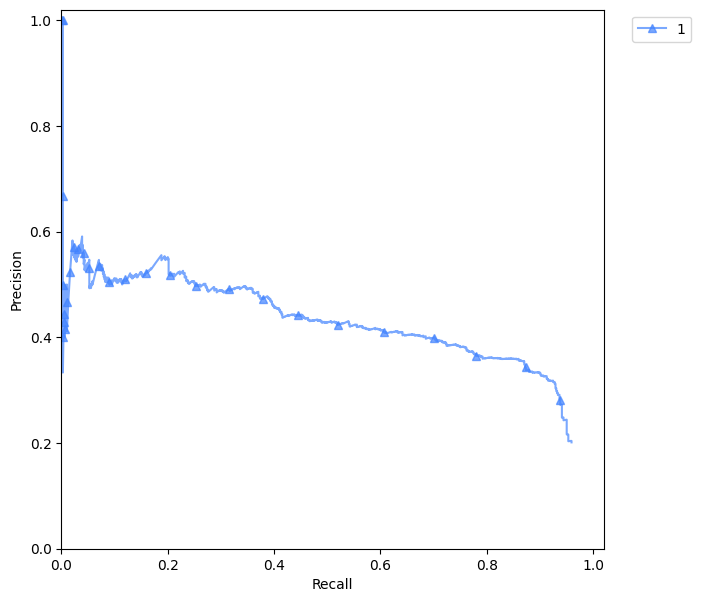

In [ ]:
# precision-recall curves
%matplotlib inline
from animaloc.vizual import PlotPrecisionRecall
pr_curve = PlotPrecisionRecall(legend=True)
metrics = test_evaluator._stored_metrics
for c in range(1, metrics.num_classes):
    rec, pre = metrics.rec_pre_lists(c)
    pr_curve.feed(rec, pre, str(c))

pr_curve.plot()

In [ ]:
# Train config files
%%writefile /content/HerdNet/configs/train/herdnet.yaml
wandb_project: 'hernet-finetunning'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
seed: 1
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  load_from: null
  resume_from: null
  kwargs:
    num_layers: 34
    pretrained: True
    down_ratio: 2
    head_conv: 64
  freeze: null

losses:
  FocalLoss:
    print_name: 'focal_loss'
    from_torch: False
    output_idx: 0
    target_idx: 0
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      normalize: False
  CrossEntropyLoss:
    print_name: 'ce_loss'
    from_torch: True
    output_idx: 1
    target_idx: 1
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      weight: [0.1,5.,15.,1.]

datasets:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  train:
    name: 'CSVDataset'
    csv_file: '/content/Train_patches/gt.csv'
    root_dir: '/content/Train_patches'

    sampler: null

    albu_transforms:
      HorizontalFlip:
        p: 0.5
      MotionBlur:
        p: 0.5
      Normalize:
        p: 1.0

    end_transforms:
      MultiTransformsWrapper:
        FIDT:
          num_classes: ${train.datasets.num_classes}
          down_ratio: ${train.model.kwargs.down_ratio}
        PointsToMask:
          radius: 2
          num_classes: ${train.datasets.num_classes}
          squeeze: True
          down_ratio: 32

  validate:
    name: 'CSVDataset'
    csv_file: '/content/drive/MyDrive/val_patches/gt.csv'
    root_dir: '/content/drive/MyDrive/val_patches'

    albu_transforms:
      Normalize:
        p: 1.0

    end_transforms:
      DownSample:
        down_ratio: ${train.model.kwargs.down_ratio}
        anno_type: ${train.datasets.anno_type}

training_settings:
  trainer: 'Trainer'
  valid_freq: 1
  print_freq: 100
  batch_size: 4
  optimizer: 'adam'
  lr: 1e-4
  weight_decay: 0.0005
  auto_lr:
    mode: 'max'
    patience: 10
    threshold: 1e-4
    threshold_mode: 'rel'
    cooldown: 10
    min_lr: 1e-6
    verbose: True
  warmup_iters: 100
  vizual_fn: null
  epochs: 1
  evaluator:
    name: 'HerdNetEvaluator'
    threshold: 5
    select_mode: 'max'
    validate_on: 'f1_score'
    kwargs:
      print_freq: 10
      lmds_kwargs:
        kernel_size: [3,3]
        adapt_ts: 0.3
  stitcher:
    name: 'HerdNetStitcher'
    kwargs:
      overlap: 0
      down_ratio: ${train.model.kwargs.down_ratio}
      up: False
      reduction: 'mean'

Overwriting /content/HerdNet/configs/train/herdnet.yaml


In [ ]:
# TEST config files
%%writefile /content/HerdNet/configs/test/herdnet.yaml
wandb_project: 'HerdNet'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  pth_file: '/content/drive/MyDrive/output/best_model.pth'
  kwargs:
    num_layers: 34
    pretrained: False
    down_ratio: 2
    head_conv: 64

dataset:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  name: 'CSVDataset'
  csv_file: '/content/test_patches/gt.csv'
  root_dir: '/content/test_patches'

  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]

evaluator:
  name: 'HerdNetEvaluator'
  threshold: 5
  kwargs:
    lmds_kwargs:
      kernel_size: [3,3]
      adapt_ts: 0.3

stitcher:
  name: 'HerdNetStitcher'
  kwargs:
    overlap: 160
    down_ratio: ${test.model.kwargs.down_ratio}
    up: False
    reduction: 'mean'

In [ ]:
# Launching training and testing sessions with config files

!python /content/HerdNet/tools/train.py train=HerdNet

/content/HerdNet/tools/train.py:222: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs', config_name="config")
In 'config': Could not find 'train/HerdNet'

Available options in 'train':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


In [ ]:
!python /content/HerdNet/tools/train.py -m train=HerdNet train.training_settings.batch_size=1,2,4 train.training_settings.lr=1e-3,1e-4

In 'config': Could not find 'train/HerdNet'

Available options in 'train':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


In [ ]:
!python /content/HerdNet/tools/test.py test=HerdNet

In 'config': Could not find 'test/HerdNet'

Available options in 'test':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.
